<h1 style="border-width:2px; border-style:solid; border-color:blue; background-color:#367395; text-align: center; text-shadow: 0px 0px 3px red; padding-bottom: 2em; padding-top: 1em;">INSURANCE CROSS-SELLING PREDICTION<br>Classification Project</h1>

About the project:

- Dataset from: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction

- In this fictional context, the challenge is to create an intelligent method to select the potential customers most likely to buy a new product from an insurance company, in order to maximize the results of the sales team and, consequently, the total invoicing revenue.

- For the present research, the available dataset contains the results of a poll over 381 thousand actual clients of a health insurance contract, who informed if they were interested in the new vehicle insurance. Besides that, the sales team will work with 20 thousand people selected from a group of 127 thousand new potential clients. 

# 0. INITIAL PROCEDURES

## 0.1 Imports

In [1]:
import pandas                          as pd
import numpy                           as np
import pickle
import json
import optuna
from   matplotlib       import pyplot      as plt
import scikitplot                          as skplt
import xgboost                             as xgb
from   boruta           import BorutaPy
from   lightgbm         import LGBMClassifier
import seaborn                                  as sns
from   scipy            import stats            as ss
from   sklearn          import preprocessing    as pp
from   sklearn          import model_selection  as ms
from   sklearn          import ensemble         as en
from   sklearn          import neighbors        as nh
from   sklearn          import linear_model     as lm
from   sklearn          import metrics          as mt
import category_encoders                        as ce
from   IPython.display  import Image
from   imblearn.combine import SMOTETomek
from   sklearn.metrics.pairwise  import rbf_kernel
from   sklearn.neighbors         import KNeighborsClassifier
from   mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from   mlxtend.feature_selection import SequentialFeatureSelector as SFS
from   sklearn.metrics           import precision_score, recall_score, f1_score
from   sklearn.metrics           import balanced_accuracy_score, accuracy_score, silhouette_score
from   sklearn.metrics           import mutual_info_score
from   sklearn.svm               import LinearSVC, SVC
from   sklearn.pipeline          import make_pipeline
from   sklearn.cluster           import DBSCAN, KMeans


c:\Users\Manoel\miniconda3\envs\healthins2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2 Load Dataset

In [2]:
# Kaggle dataset:
# https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction
df_raw = pd.read_csv('../data/raw/train.csv')
df_raw.sample(8).T

,296496,123194,105029,162267,252561,19351,36704,250157
id,296497,123195,105030,162268,252562,19352,36705,250158
Gender,Female,Male,Female,Female,Female,Male,Male,Female
Age,22,73,46,23,71,41,77,45
Driving_License,1,1,1,1,1,1,1,1
Region_Code,5.0,28.0,0.0,50.0,11.0,28.0,28.0,28.0
Previously_Insured,0,0,1,0,0,1,0,0
Vehicle_Age,< 1 Year,1-2 Year,1-2 Year,< 1 Year,1-2 Year,1-2 Year,1-2 Year,1-2 Year
Vehicle_Damage,Yes,Yes,No,Yes,Yes,No,Yes,Yes
Annual_Premium,25946.0,2630.0,2630.0,46229.0,50927.0,32283.0,62433.0,37928.0
Policy_Sales_Channel,152.0,26.0,124.0,151.0,26.0,125.0,26.0,124.0


In [3]:
df_raw.shape

(381109, 12)

# 1. DATA DESCRIPTION

## 1.0. copy data, etc

In [4]:
df1 = df_raw.copy()

# Rename Columns (to lowercase)
df1.columns = df1.columns.str.lower()
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.1. Data Dimension

In [5]:
print( 'N# of rows: {}'.format( df1.shape[0] ) )
print( 'N# of cols: {}'.format( df1.shape[1] ) )

N# of rows: 381109
N# of cols: 12


## 1.2. Verifying Types & Size & Nunique & NAs

In [6]:
aux = pd.DataFrame( {'cols': df1.columns,
                      'DType': df1.dtypes,
                      'size': df1.shape[0],
                      'nunique': df1.nunique(),
                      'NAs': df1.isna().sum()} )
aux['NA_percent'] = round( aux['NAs'] / aux['size'], 2 )
aux

,cols,DType,size,nunique,NAs,NA_percent
id,id,int64,381109,381109,0,0.0
gender,gender,object,381109,2,0,0.0
age,age,int64,381109,66,0,0.0
driving_license,driving_license,int64,381109,2,0,0.0
region_code,region_code,float64,381109,53,0,0.0
previously_insured,previously_insured,int64,381109,2,0,0.0
vehicle_age,vehicle_age,object,381109,3,0,0.0
vehicle_damage,vehicle_damage,object,381109,2,0,0.0
annual_premium,annual_premium,float64,381109,48838,0,0.0
policy_sales_channel,policy_sales_channel,float64,381109,155,0,0.0


In [7]:
df1.sample(8).T

,70449,342380,14719,169795,372908,193648,70669,51061
id,70450,342381,14720,169796,372909,193649,70670,51062
gender,Male,Male,Female,Male,Male,Female,Female,Male
age,47,49,23,45,42,21,59,41
driving_license,1,1,1,1,1,1,1,1
region_code,46.0,30.0,46.0,21.0,42.0,30.0,28.0,28.0
previously_insured,0,1,0,0,0,0,0,1
vehicle_age,1-2 Year,1-2 Year,< 1 Year,1-2 Year,1-2 Year,< 1 Year,1-2 Year,1-2 Year
vehicle_damage,Yes,No,Yes,No,Yes,Yes,Yes,No
annual_premium,33416.0,22511.0,20718.0,28280.0,30062.0,45326.0,2630.0,30844.0
policy_sales_channel,124.0,152.0,152.0,124.0,124.0,152.0,124.0,124.0


## 1.3. Descriptive Statistics

### 1.3.1 Separete Features

In [8]:
# Manually separate numerical features (after meditation...)
num_feat = [ 'id', 'age', 'annual_premium', 'vintage' ]
num_attributes = df1.loc[:, num_feat].copy()

# Manually separete target variable(s)
target_feat = [ 'response' ]

# Manually separate other features (ex: data, id, ...)
other_feat = [  ]

# Categorical features: all the others
cat_feat = []
for a in df1.columns:
    if a in num_feat:
        #print(a)
        continue
    if a in target_feat:
        continue
    if a in other_feat:
        continue
    cat_feat.append(a)
cat_attributes = df1.loc[:, cat_feat].copy()

In [9]:
# Numerical Features: [ 'id', 'age', 'annual_premium', 'vintage' ]
num_attributes.sample(8).T

,276212,235097,72218,309064,276272,27145,221760,123521
id,276213.0,235098.0,72219.0,309065.0,276273.0,27146.0,221761.0,123522.0
age,25.0,22.0,26.0,59.0,58.0,55.0,66.0,62.0
annual_premium,25073.0,46396.0,51276.0,41245.0,22704.0,34671.0,38030.0,25937.0
vintage,136.0,37.0,92.0,235.0,186.0,246.0,121.0,36.0


In [10]:
# Categorical Features: [ gender, driving_license, region_code, previously_insured, 
#                         vehicle_age, vehicle_damage, policy_sales_channel ]
cat_attributes.sample(8).T

,255872,354884,95349,19846,365834,9041,372799,38055
gender,Male,Female,Male,Male,Male,Female,Female,Female
driving_license,1,1,1,1,1,1,1,1
region_code,28.0,1.0,28.0,33.0,8.0,41.0,9.0,33.0
previously_insured,1,0,0,1,0,1,0,1
vehicle_age,1-2 Year,1-2 Year,1-2 Year,< 1 Year,1-2 Year,< 1 Year,< 1 Year,< 1 Year
vehicle_damage,No,Yes,Yes,No,Yes,No,Yes,No
policy_sales_channel,26.0,26.0,26.0,152.0,26.0,152.0,152.0,152.0


### 1.3.2 Numerical Features

In [11]:
# DESCRIPTIVE STATISTICS - NUMERICAL ATTRIBUTES
# Dispersion (variance, standard deviation, max, min, range, skew, kurtosis)
# central tendency (mean, median)

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate the metrics
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).round(2).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.00,190555.0,110016.69,0.00,-1.20
1,age,20.0,85.0,65.0,38.82,36.0,15.51,0.67,-0.57
2,annual_premium,2630.0,540165.0,537535.0,30564.39,31669.0,17213.13,1.77,34.00
3,vintage,10.0,299.0,289.0,154.35,154.0,83.67,0.00,-1.20


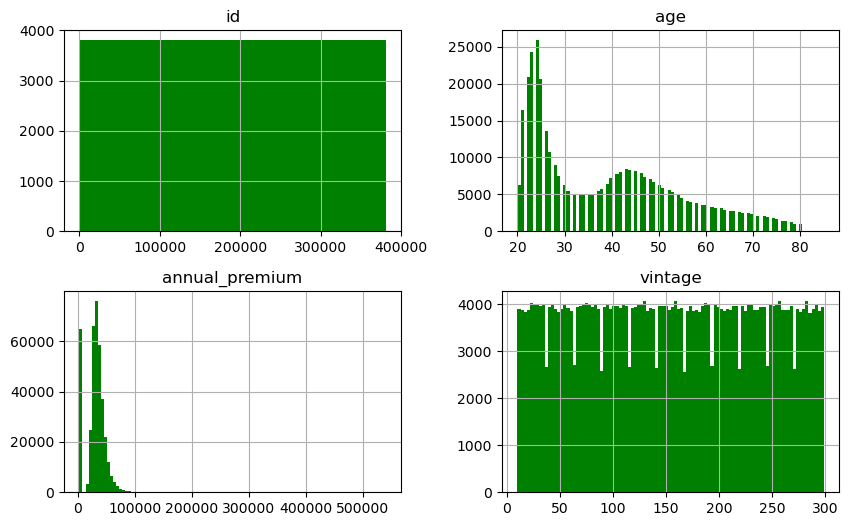

In [12]:
num_attributes.hist( bins=100, figsize=(10,6), color='green' );

### 1.3.3 Categorical Features

In [13]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender                    2
driving_license           2
region_code              53
previously_insured        2
vehicle_age               3
vehicle_damage            2
policy_sales_channel    155
dtype: int64

#### (a) GENDER

In [14]:
# Gender: 2 categories - female/male
df1['gender'].value_counts()

gender
Male      206089
Female    175020
Name: count, dtype: int64

#### (b) DRIVING_LICENSE

In [15]:
# Driving License: 2 categories - 0/1
df1['driving_license'].value_counts()

driving_license
1    380297
0       812
Name: count, dtype: int64

#### (c) REGION_CODE

In [16]:
# Region Code: 53 categories...
df1['region_code'].value_counts()

region_code
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       4038
13.0      4036
7.0       3279
12.0      3198
9.0       3101
27.0      2823
32.0      2787
43.0      2639
17.0      2617
26.0      2587
25.0      2503
24.0      2415
38.0      2026
0.0       2021
16.0      2007
31.0      1960
23.0      1960
20.0      1935
49.0      1832
4.0       1801
34.0      1664
19.0      1535
22.0      1309
40.0      1295
5.0       1279
1.0       1008
44.0       808
42.0       591
52.0       267
51.0       183
Name: count, dtype: int64

#### (d) PREVIOUSLY_INSURED

In [17]:
# Previously Insured: 2 categories - 0/1
df1['previously_insured'].value_counts()

previously_insured
0    206481
1    174628
Name: count, dtype: int64

#### (e) VEHICLE_AGE

In [18]:
# Vehicle Age: 3 categories -  <1Y, 1-2Y, >2Y
df1['vehicle_age'].value_counts()

vehicle_age
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: count, dtype: int64

#### (f) VEHICLE_DAMAGE

In [19]:
# Vehicle Damage: 2 categories - Yes/No
df1['vehicle_damage'].value_counts()

vehicle_damage
Yes    192413
No     188696
Name: count, dtype: int64

#### (g) POLICY SALES CHANNEL

In [20]:
# Policy Sales Channel: 155 categories...
df1['policy_sales_channel'].value_counts()

policy_sales_channel
152.0    134784
26.0      79700
124.0     73995
160.0     21779
156.0     10661
          ...  
149.0         1
43.0          1
144.0         1
143.0         1
41.0          1
Name: count, Length: 155, dtype: int64

### 1.3.4 Target Variable

In [21]:
# Response: 2 categories - 0/1
df1['response'].value_counts()

response
0    334399
1     46710
Name: count, dtype: int64

In [22]:
# Response: 2 categories - 0/1
targ = df1.loc[:, ['response', 'id'] ].groupby('response').count().reset_index()
targ['perc'] = round(100. * targ['id'] / df1.shape[0], 2)
targ.columns = ['response', 'qtty', 'qtty%']
targ

,response,qtty,qtty%
0,0,334399,87.74
1,1,46710,12.26


c:\Users\Manoel\miniconda3\envs\healthins2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


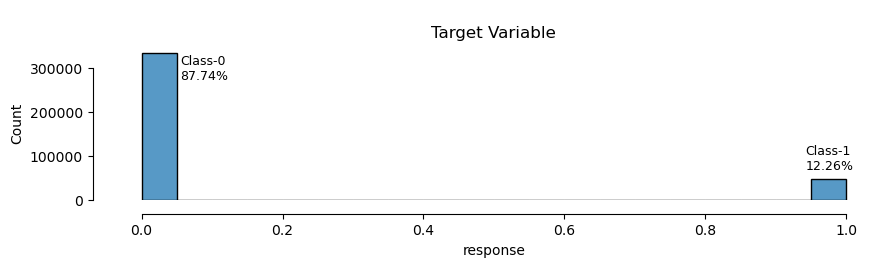

In [23]:
# Target: unbalanced classes
plt.figure( figsize=(10, 2) )
plt.title('Target Variable')
plt.annotate( 'Class-0\n87.74%', xy=(130,135), fontsize=9, xycoords='figure points' );
plt.annotate( 'Class-1\n12.26%', xy=(580,70), fontsize=9, xycoords='figure points' );
sns.histplot(df1, x='response');
sns.despine( offset=10, trim=True );

## 1.4. Fillout NA & Change Data Types

In [24]:
# Nop

# 2. BUSINESS HYPOTHESIS

## 2.1. Mind Map

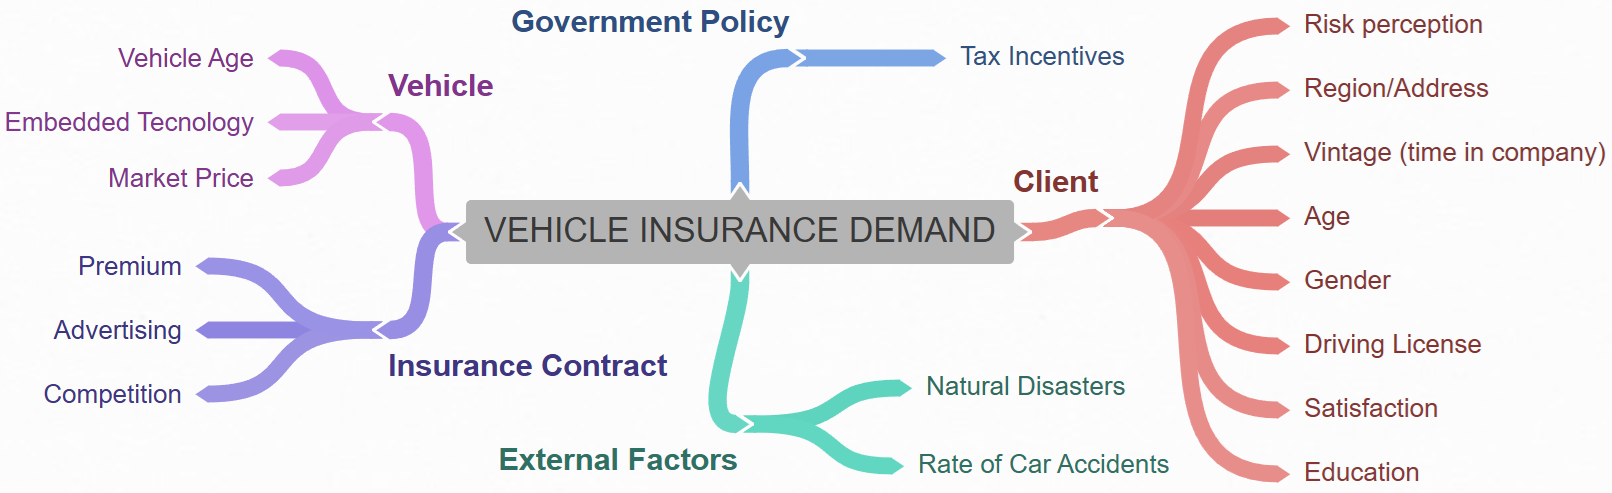

In [25]:
Image('../img/MindMapHypothesis_Insurance.png')

## 2.2. Hypothesis (considering available features)

**H-1.** GENDER: will not influence interest for insurance.

**H-2.** CLIENT AGE: interest for insurance will rise with age.

(since different groups have different needs and risk perceptions, affecting insurance demand)

**H-3.** DRIVING LICENSE: the interest for insurance tends to rise after aquiring a license.

**H-4.** REGION CODE: some regions may generate more interest for insurance than others.

- due to demographic characteristics. That can be a result of factors like regions with higher crime rates or simply due to more vehicles in an area

**H-5.** PREVIOUSLY INSURED: those insured by other insurance companies will be less inclined to become our clients.

**H-6.** VEHICLE AGE: the newer the vehicle, the bigger the interest for insurance.

- That may be due to: (1) higher market value of newer cars, (2) older cars may need less broad insurance, (3) compared to the value of older/cheaper cars, premium become percentually expensive, reducing the demand. To overcome that effect, companies may offer insurance specially suited for older vehicles, which may raise demand

**H-7.** ANNUAL PREMIUM: higher values will result in less interest for insurance.

**H-8.** POLICY SALES CHANNEL: some channels may be more effective in aquiring new clients.

**H-9.** VINTAGE: longer time clients tend to continue clients.


## 2.3. Other Hypothesis

Other factors can be subject of further studies.

**1.** ECONOMIC FACTORS: 

**1.1.** ECONOMIC GROWTH: affecting consumer's purchase power

**1.2.** UNEMPLOYMENT RATE: affecting consumer's purchase power

**1.3.** INFLATION: may inflate premiums, reducing potential demand

**2.** DEMOGRAPHIC FACTORS:

**2.1** POPULATION GROWTH: lead to more vehicles and then more insurance demand

**3.** SOCIOECONOMIC FACTORS:

**3.1** INCOME LEVEL: rise of income tend to increase insurance demand.

**3.2** EDUCATION LEVEL: tend to increase insurance demand.


**4.** TECHNOLOGICAL FACTORS

**4.1** INOVATION & TECHNOLOGY: the influence of telematics and autonomous cars may affect demand.

**5.** REGULATORY FACTORS

**5.1** GOVERNMENT INCENTIVES: tax benefits and other policies applied to vehicles tend to affect insurance demand.

**6.** MARKET FACTORS

**6.1** COMPETITION: affects consumer decision, then affecting insurance demand.

**6.1** ADVERTISING: afffects insurance demand.

**7.** BEHAVIORAL FACTORS

**7.1** RISK PERCEPTION: influences insurance demand.

**7.2** CUSTOMER SATISFACTION: impact retention of current customers and can attract new ones.

**8.** EXTERNAL FACTORS

**8.1** NATURAL AND ACCIDENTAL EVENTS: disasters or higher rate of accidents tend to boost demand for insurance.

REF: question presented to ChatGPT 4o:
- "In an economic analysis of the car insurance sales business, list the main factors that influence sales volume"

# 3. FEATURE ENGINEERING

## 3.0. copy data, etc

In [26]:
df3 = df1.copy()
df3.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [27]:
df3.nunique()

id                      381109
gender                       2
age                         66
driving_license              2
region_code                 53
previously_insured           2
vehicle_age                  3
vehicle_damage               2
annual_premium           48838
policy_sales_channel       155
vintage                    290
response                     2
dtype: int64

## 3.1. New features

Beware of possible "data leakage":
- Use "features" conversions which depend solely of the feature converted. Example: yes=1 / no=0
- Do not use conversions which depend on the whole dataset. Example: rbf_kernel(), target_encoding(), etc
- In such cases, apply conversions after TVT division (TVT = train/validation/test)

In [28]:
#.......... Vehicle Damage Number
df3['vehicle_damage'] = df3['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

#.......... Vehicle Age
df3['vehicle_age'] = df3['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                    'between_1_2_years' if x == '1-2 Year'  else 'bellow_1_year' )

In [29]:
#.......... Annual Premium
# From 'annual_premium', derive 3 features
#    - feature.1: points with values below 2675 (or between 2630-2675), others =ZERO
#    - feature.2: values from 2675 to 74301 (or 83260), others =ZERO
#    - feature.3: values above previous limits, others =ZERO
df3['annual_premium_f1'] = df3['annual_premium'].apply( lambda x: 0.0 if x>2675.0 else x )
df3['annual_premium_f2'] = df3['annual_premium'].apply( lambda x: x if x>2675.0 and x<74301.0 else 0.0 )
df3['annual_premium_f3'] = df3['annual_premium'].apply( lambda x: 0.0 if x<74301.0 else x )

# Verifying...
cols = [ 'annual_premium', 'annual_premium_f1', 'annual_premium_f2', 'annual_premium_f3' ]
aux = df3.loc[:, cols ].copy()
aux = pd.DataFrame( {'cols': aux.columns,
                      'DType': aux.dtypes,
                      'size': aux.shape[0],
                      'nunique': aux.nunique(),
                      'NAs': aux.isna().sum()} )
aux['NA_percent'] = round( aux['NAs'] / aux['size'], 2 )
aux

,cols,DType,size,nunique,NAs,NA_percent
annual_premium,annual_premium,float64,381109,48838,0,0.0
annual_premium_f1,annual_premium_f1,float64,381109,2,0,0.0
annual_premium_f2,annual_premium_f2,float64,381109,46029,0,0.0
annual_premium_f3,annual_premium_f3,float64,381109,2810,0,0.0


In [30]:
#.......... Age
# Since 'age' is a bimodal variable (mode1=23-24, mode2=43): create two features using "rbf_kernel()"
# REF: Géron, pg.77-80

# PS: delete these two new features before SPLITTING data (in step-6)

centers = [23, 43]

rbf_23 = rbf_kernel(df3[['age']], [[centers[0]]], gamma=0.030 )  # GAMMA can be fine-tuned
rbf_43 = rbf_kernel(df3[['age']], [[centers[1]]], gamma=0.015 )  # GAMMA can be fine-tuned

df3['age_rbf_23'] = rbf_23
df3['age_rbf_43'] = rbf_43

In [31]:
#.......... Policy Sales Channel
# KPI: Policy Sales Channel Importance = (N# of regs by channel) / (Total N# of regs)
# (PS: frequency encoding)

# PS: delete this new feature(s) before SPLITTING data (in step-6)

# compute KPI
aux = df3.loc[:, ['policy_sales_channel', 'id'] ].groupby('policy_sales_channel').count().reset_index()
maxval = aux['id'].max()
aux['policy_sales_channel_importance'] = aux['id'] / maxval
aux = aux.drop(columns=['id'])
# include it in df3
df3 = pd.merge( df3, aux, on='policy_sales_channel', how="left" )

In [32]:
df3.nunique()

id                                 381109
gender                                  2
age                                    66
driving_license                         2
region_code                            53
previously_insured                      2
vehicle_age                             3
vehicle_damage                          2
annual_premium                      48838
policy_sales_channel                  155
vintage                               290
response                                2
annual_premium_f1                       2
annual_premium_f2                   46029
annual_premium_f3                    2810
age_rbf_23                             63
age_rbf_43                             43
policy_sales_channel_importance       108
dtype: int64

# 4. DATA FILTERING

## 4.0. Copy data

In [33]:
df4 = df3.copy()
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response', 'annual_premium_f1',
       'annual_premium_f2', 'annual_premium_f3', 'age_rbf_23', 'age_rbf_43',
       'policy_sales_channel_importance'],
      dtype='object')

## 4.1. rows filtering

In [34]:
# nop

## 4.2. cols filtering

In [35]:
# nop

# 5. EDA

## 5.0. copy data, etc

In [36]:
df5 = df4.copy()

### Cramer V

In [37]:
#............... In case of categorical attributes: Cramer V Method
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramer_v( x, y ):
    confusion_matrix = pd.crosstab( x, y ).to_numpy()
    chi2 = ss.chi2_contingency( confusion_matrix )[0]
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape

    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min(kcorr-1, rcorr-1) ) )

### Histogram Table

In [38]:
def histogram_table( num_bins, df, in_feature ):

    qt_tot = df.shape[0]

    # Binned range
    n, bins = np.histogram( df[in_feature], num_bins )
    str_bin = []
    first = True
    #lim_inf = str(bins[0])
    #lim_inf = f'{bins[0]:.1f}'
    lim_inf = str( round( bins[0], 1 ) )
    for bin in bins:
        if first:
            first = False
            continue
        str_bin.append( "(" + lim_inf + " - " + str( round(bin, 1) ) + ")" )
        #lim_inf = str( bin )
        #lim_inf = f'{bin:.1f}'
        lim_inf = str( round(bin, 1) )

    out_table = pd.DataFrame()
    out_table['VALUE RANGE'] = str_bin
    out_table[in_feature + ': all'] = n
    out_table['perc%'] = 100.0 * n / qt_tot

    aux00 = df.loc[ df['response']==0, [in_feature, 'response'] ]
    n0, bins = np.histogram( aux00[in_feature], num_bins )
    out_table['resp.0'] = n0

    aux01 = df.loc[ df['response']==1, [in_feature, 'response'] ]
    n1, bins = np.histogram( aux01[in_feature], num_bins )
    out_table['resp.1'] = n1

    return out_table


## 5.1. Univariate & Bivariate Analysis

In [39]:
# AIM:
# Univariate Analysis: understand the characteristics & behaviour of each feature alone
# Bivariate  Analysis: understand the impact of each attribute to the response variable.

### 5.1.1. Numerical Features

#### Importance of Numerical Features: Correlation

In [40]:
# Correlation Coefficient
# REF: "Machine Learning Bootcamp", pg.86-88

features = [ 'age', 'annual_premium', 'vintage', 
             'annual_premium_f1', 'annual_premium_f2', 'annual_premium_f3', 
             'age_rbf_23', 'age_rbf_43', 
             'policy_sales_channel_importance' ]
df_pearson = df5[features].corrwith(df5.response)
df_pearson = df_pearson.sort_values(ascending=False).to_frame(name='Corr.Coef')
df_pearson


,Corr.Coef
age_rbf_43,0.191985
age,0.111147
annual_premium,0.022575
annual_premium_f2,0.017858
annual_premium_f1,0.011783
annual_premium_f3,0.008185
vintage,-0.001050
policy_sales_channel_importance,-0.145496
age_rbf_23,-0.205519


In [41]:
# RESULTS INDICATE THAT:
#
# "vintage" & "annual_premium_f3" are the least important features
# "age_rbf_23" & "age_rbf_43" are more important than "age"
# Conclusion: "age", "vintage" & "annual_premium_f3" could (supposedly) be discarded.

#### (a) AGE

- **(1)** AGE has bimodal distribution, with two populations having modes in 23 and 43 years.

- **(2)** The graphics indicate that 43-years mode differs from 23-years by presenting, proportionally, more people interest in insurance. So, different marketing strategies (ads & sales) should be considered for each group.

- **(3)** The bimodal distribution is treated by applying Radial Basis Functions (RBF) to create two new features to represent the similarity between the 'age' feature and each mode [ref: Géron, 3rd ed, pg.77]

##### Univariate Analysis

c:\Users\Manoel\miniconda3\envs\healthins2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


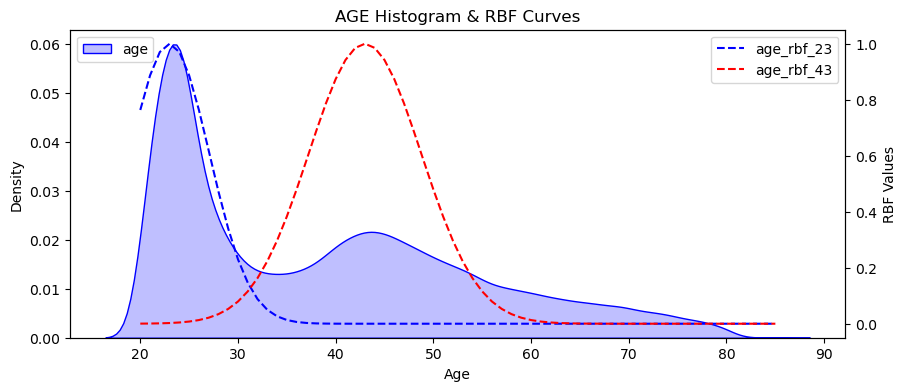

In [42]:
# UNIVARIATE:
# There are 66 unique values in 'age'.
# In order to plot, let's prepare a dataframe...
# ... with 66 lines & 3 columns: 'age', 'age_rbf_23' e 'age_rbf_43'
aux = df5.loc[:, ['age','age_rbf_23','age_rbf_43'] ].groupby('age').mean().reset_index()

# Two Y axes needed...
fig, ax1 = plt.subplots(figsize=(10, 4))
plt.title('AGE Histogram & RBF Curves')

# First Y: KDEPLOT
sns.kdeplot(df5['age'], label='age', fill=True, ax=ax1, color='blue')
ax1.set_ylabel('Density')
ax1.legend(loc='upper left')
ax1.set_xlabel('Age')

# Second Y: RBF curves
ax2 = ax1.twinx()
ax2.plot(aux['age'], aux['age_rbf_23'], 'b--', label='age_rbf_23')
ax2.plot(aux['age'], aux['age_rbf_43'], 'r--', label='age_rbf_43')
ax2.set_ylabel('RBF Values')
ax2.legend(loc='upper right')

plt.show()

##### Bivariate Analysis

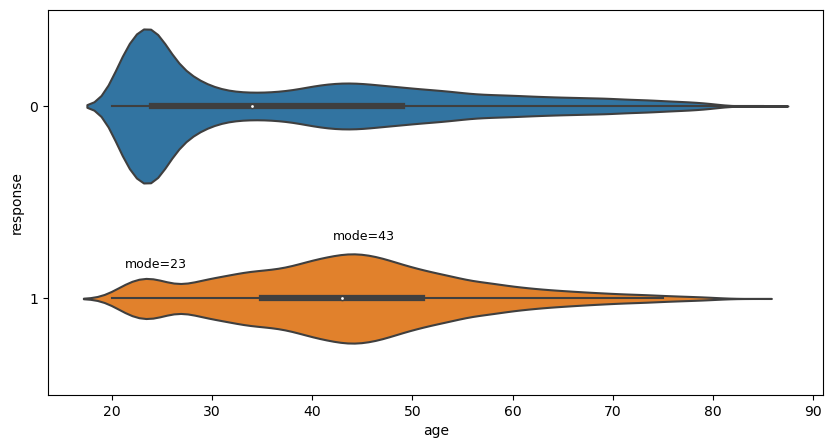

In [43]:
# BIVARIATE ANALYSIS:
plt.figure(figsize=(10, 5))
sns.violinplot(y='response', x='age', orient='h', data=df5);
plt.annotate( 'mode=23', xy=(90,130), fontsize=9, xycoords='figure points' );
plt.annotate( 'mode=43', xy=(240,150), fontsize=9, xycoords='figure points' );

##### digging into age values

In [44]:
# AGE IN THE MICROSCOPE: how we found the modes...
# age histogram:    min=20    max=85

num_bins = 140   # we vary this...
df_hist = histogram_table(num_bins, df5, 'age')
df_hist.head(15) # ...and this.

,VALUE RANGE,age: all,perc%,resp.0,resp.1
0,(20.0 - 20.5),6232,1.635228,6061,171
1,(20.5 - 20.9),0,0.000000,0,0
2,(20.9 - 21.4),16457,4.318187,15883,574
3,(21.4 - 21.9),0,0.000000,0,0
4,(21.9 - 22.3),20964,5.500788,20201,763
5,(22.3 - 22.8),0,0.000000,0,0
6,(22.8 - 23.2),24256,6.364583,23364,892
7,(23.2 - 23.7),0,0.000000,0,0
8,(23.7 - 24.2),25960,6.811700,25047,913
9,(24.2 - 24.6),0,0.000000,0,0


#### (b) ANNUAL PREMIUM

- **(1)** Annual Premium values comprise three groups of values, which we named Low Budget Group, Main Group, Extreme Group

- **(2)** Low budget group - the cheapest premium (= $2.630) occurs in 17% of the database.

- **(3)** Main group - 82% of the database includes insurance premiums ranging from $6.098 to $74.300

- **(4)** Extreme group - 0,9% of the cases range from $74.301 to the maximum value of $540.165

PS: alternativelly, it could be generated three categories with OneHotEncoding.

##### Univariate Analysis

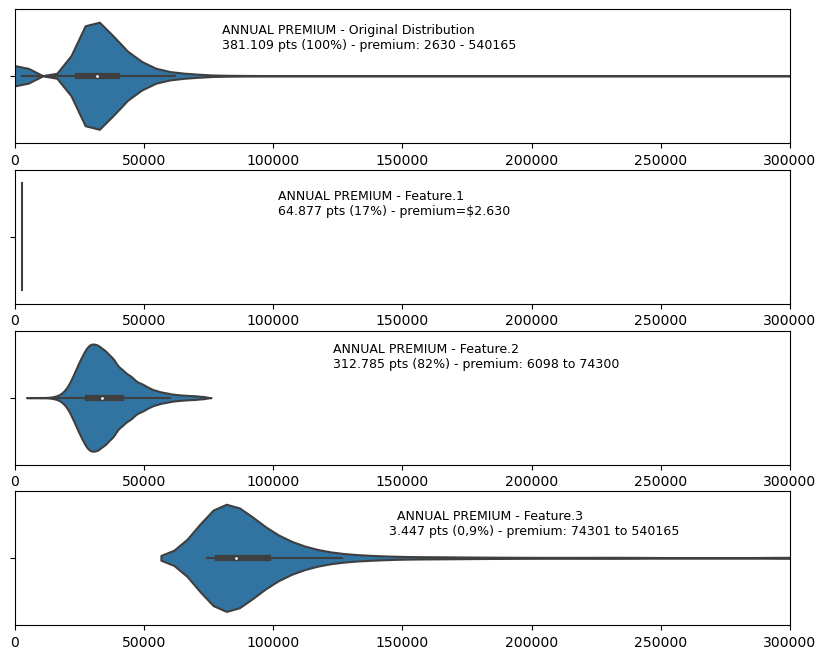

In [45]:
# UNIVARIATE ANALYSIS:
# annual_premium feature.1: points with values between 2630-2675, others =ZERO
# Result: there are 64.877 (17%) contracts of low budget premium of exactly $2630.
auxf1 = df5.loc[ df5['annual_premium_f1']!=0, ['response','annual_premium_f1'] ]

# annual_premium feature.2: values from 2675 to 74301 (or 83260), others =ZERO
# Result: there are 312.785 (82%, vast majority) contracts with premiums from $2675 to $74.301.
auxf2 = df5.loc[ df5['annual_premium_f2']!=0, ['response','annual_premium_f2'] ]

# annual_premium feature.3: values above 74301, others =ZERO
# Result: there are 3.447 (0,9%) contracts with premiums over $74.301.
auxf3 = df5.loc[ df5['annual_premium_f3']!=0, ['response','annual_premium_f3'] ]

plt.figure(figsize=(10, 8))
plt.subplot(4,1,1)
ax0 = sns.violinplot(x='annual_premium', orient='h', data=df5);
ax0.set_xlim(0, 300000)
ax0.set( xlabel='' )
plt.subplot(4,1,2)
ax1 = sns.violinplot(x='annual_premium_f1', orient='h', data=auxf1);
ax1.set_xlim(0, 300000)
ax1.set( xlabel='' )
plt.subplot(4,1,3)
ax2 = sns.violinplot(x='annual_premium_f2', orient='h', data=auxf2);
ax2.set_xlim(0, 300000)
ax2.set( xlabel='' )
plt.subplot(4,1,4)
ax3 = sns.violinplot(x='annual_premium_f3', orient='h', data=auxf3);
ax3.set_xlim(0, 300000)
ax3.set( xlabel='' )
plt.annotate( 'ANNUAL PREMIUM - Original Distribution\n381.109 pts (100%) - premium: 2630 - 540165', xy=(160,440), fontsize=9, xycoords='figure points' );
plt.annotate( 'ANNUAL PREMIUM - Feature.1\n64.877 pts (17%) - premium=$2.630', xy=(200,320), fontsize=9, xycoords='figure points' );
plt.annotate( 'ANNUAL PREMIUM - Feature.2\n312.785 pts (82%) - premium: 6098 to 74300', xy=(240,210), fontsize=9, xycoords='figure points' );
plt.annotate( '  ANNUAL PREMIUM - Feature.3\n3.447 pts (0,9%) - premium: 74301 to 540165', xy=(280,90), fontsize=9, xycoords='figure points' );
plt.show()

##### Bivariate Analysis

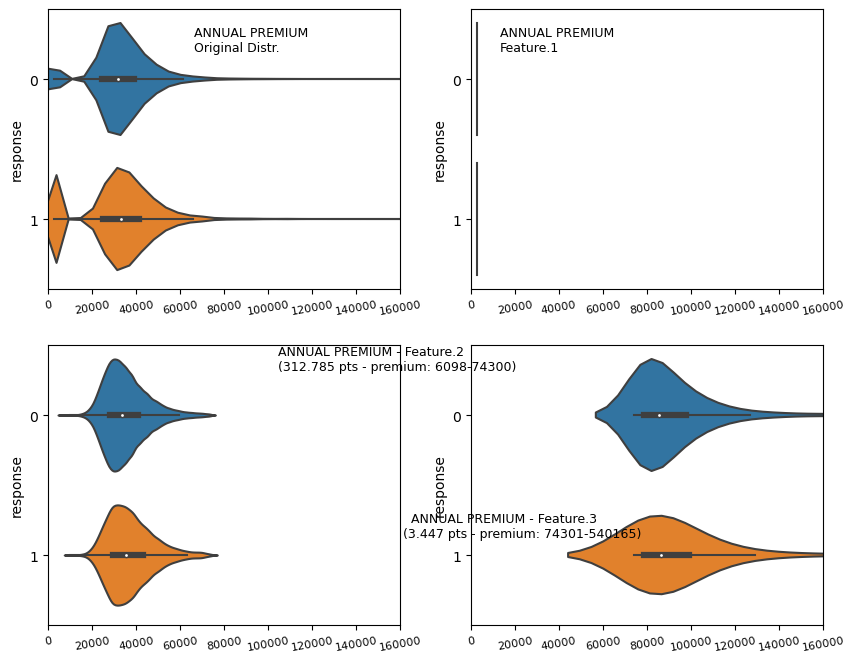

In [46]:
# BIVARIATE ANALYSIS:
#............... PLOTTINGS
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
ax0 = sns.violinplot(y='response', x='annual_premium', orient='h', data=df5);
ax0.set_xlim(0, 160000)
ax0.set( xlabel='' )
plt.xticks(rotation=10, fontsize=8);
plt.subplot(2,2,2)
ax1 = sns.violinplot(y='response', x='annual_premium_f1', orient='h', data=auxf1);
ax1.set_xlim(0, 160000)
ax1.set( xlabel='' )
plt.xticks(rotation=10, fontsize=8);
plt.subplot(2,2,3)
ax2 = sns.violinplot(y='response', x='annual_premium_f2', orient='h', data=auxf2);
ax2.set_xlim(0, 160000)
ax2.set( xlabel='' )
plt.xticks(rotation=10, fontsize=8);
plt.subplot(2,2,4)
ax3 = sns.violinplot(y='response', x='annual_premium_f3', orient='h', data=auxf3);
ax3.set_xlim(0, 160000)
ax3.set( xlabel='' )
plt.xticks(rotation=10, fontsize=8);
plt.annotate( 'ANNUAL PREMIUM\nOriginal Distr.', xy=(140,440), fontsize=9, xycoords='figure points' );
plt.annotate( 'ANNUAL PREMIUM\nFeature.1', xy=(360,440), fontsize=9, xycoords='figure points' );
plt.annotate( 'ANNUAL PREMIUM - Feature.2\n(312.785 pts - premium: 6098-74300)', xy=(200,210), fontsize=9, xycoords='figure points' );
plt.annotate( '  ANNUAL PREMIUM - Feature.3\n(3.447 pts - premium: 74301-540165)', xy=(290,90), fontsize=9, xycoords='figure points' );
plt.show()

In [47]:
#............... TABLE

tabela = df5.loc[:, ['annual_premium', 'response'] ].groupby('response').count().reset_index()
tabela['ap%'] = np.round(100.0 * tabela['annual_premium'] / df5.shape[0], 2)
t1 = df5[df5['annual_premium_f1'] != 0].loc[:, ['annual_premium_f1', 'response']].groupby('response').count().reset_index()
t2 = df5[df5['annual_premium_f2'] != 0].loc[:, ['annual_premium_f2', 'response']].groupby('response').count().reset_index()
t3 = df5[df5['annual_premium_f3'] != 0].loc[:, ['annual_premium_f3', 'response']].groupby('response').count().reset_index()
tabela['annual_premium_f1'] = t1['annual_premium_f1']
tabela['apf1%'] = np.round(100.0 * tabela['annual_premium_f1'] / t1['annual_premium_f1'].sum(), 2)
tabela['annual_premium_f2'] = t2['annual_premium_f2']
tabela['apf2%'] = np.round(100.0 * tabela['annual_premium_f2'] / t2['annual_premium_f2'].sum(), 2)
tabela['annual_premium_f3'] = t3['annual_premium_f3']
tabela['apf3%'] = np.round(100.0 * tabela['annual_premium_f3'] / t3['annual_premium_f3'].sum(), 2)
annualpremium_tab = tabela
annualpremium_tab

,response,annual_premium,ap%,annual_premium_f1,apf1%,annual_premium_f2,apf2%,annual_premium_f3,apf3%
0,0,334399,87.74,56372,86.89,275093,87.95,2934,85.12
1,1,46710,12.26,8505,13.11,37692,12.05,513,14.88


##### digging into annual premium values

In [48]:
# HOW WE FOUND THE LIMITS OF FEATURES...
# annual_premium:    min=2630.0    max=540165.0

# From 'annual_premium', derived 3 features
#    - feature.1: points with values between 2630-2675, others =ZERO
#    - feature.2: values from 2675 to 74301 (or 83260), others =ZERO
#    - feature.3: values above previous limits, others =ZERO

In [49]:
# annual_premium histogram:    min=2630.0    max=540165.0
# --> first 15% of range (limit to 83260) comprise 99,48% of measurement points

num_bins = 20
df_hist = histogram_table(num_bins, df5, 'annual_premium')
df_hist.head(4)

,VALUE RANGE,annual_premium: all,perc%,resp.0,resp.1
0,(2630.0 - 29506.8),158799,41.667607,141071,17728
1,(29506.8 - 56383.5),205268,53.860707,178880,26388
2,(56383.5 - 83260.2),15080,3.956873,12796,2284
3,(83260.2 - 110137.0),1480,0.388340,1246,234


In [50]:
# annual_premium histogram:    min=2630.0    max=540165.0
# --> first 13,33% of range (limit 74301) comprise 99,10% of measurement points

num_bins = 30
df_hist = histogram_table(num_bins, df5, 'annual_premium')
df_hist.head(5)

,VALUE RANGE,annual_premium: all,perc%,resp.0,resp.1
0,(2630.0 - 20547.8),72226,18.951534,63121,9105
1,(20547.8 - 38465.7),204503,53.659977,182061,22442
2,(38465.7 - 56383.5),87338,22.916803,74769,12569
3,(56383.5 - 74301.3),13596,3.567483,11514,2082
4,(74301.3 - 92219.2),2270,0.595630,1939,331


In [51]:
# annual_premium histogram:    min=2630.0    max=540165.0
# --> ~17% of the measurement points (=64877) are located in the very beginning, values between 2630-2675

num_bins = 12000
df_hist = histogram_table(num_bins, df5, 'annual_premium')
df_hist.head(4)

,VALUE RANGE,annual_premium: all,perc%,resp.0,resp.1
0,(2630.0 - 2674.8),64877,17.023214,56372,8505
1,(2674.8 - 2719.6),0,0.000000,0,0
2,(2719.6 - 2764.4),0,0.000000,0,0
3,(2764.4 - 2809.2),0,0.000000,0,0


#### (c) VINTAGE

- 'vintage' shows almost uniform distribution. Probably, no benefit to the present study.

##### Univariate Analysis

c:\Users\Manoel\miniconda3\envs\healthins2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


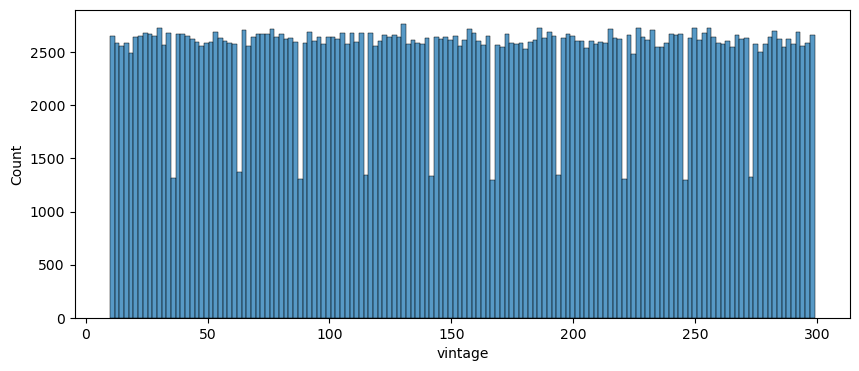

In [52]:
# Univariate Analysis:
plt.figure(figsize=(10, 4))
sns.histplot( df5['vintage'], bins=150 );

##### Bivariate Analysis

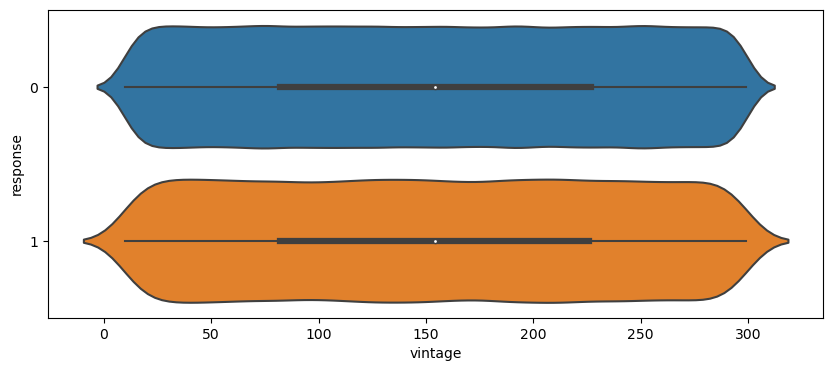

In [53]:
# Bivariate Analysis
plt.figure(figsize=(10, 4))
sns.violinplot(y='response', x='vintage', orient='h', data=df5);

### 5.1.2. Categorical Features

#### Importance of Categorical Features: Mutual Information

In [54]:
# Mutual Information
# REF: "Machine Learning Bootcamp", pg.85

def calculate_mi(series):
    return mutual_info_score( series, df5.response )

features = [ 'gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'vehicle_damage', 'policy_sales_channel' ]
df_mi = df5[features].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')
df_mi


,MI
previously_insured,0.079515
vehicle_damage,0.079027
policy_sales_channel,0.039176
vehicle_age,0.026214
region_code,0.009445
gender,0.001388
driving_license,0.000064


In [55]:
# RESULTS INDICATE THAT: "driving_license" & "gender" are the least important categorical features, and could be discarded.

#### (a) GENDER

- **(1)** The base comprises 45,9% of female people & 54,1% of male people.

- **(2)** More male people (13,84% or 28.525) are inclined to purchase the vehicle insurance contract, when compared to female people (10,39% or 18.185)

##### Univariate Analysis

,gender,qtty,qtty%
0,Female,175020,45.92
1,Male,206089,54.08


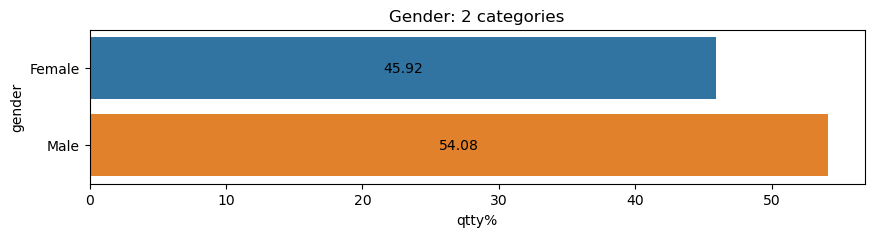

In [56]:
# Gender: 2 categories - female/male
tabela = df5.loc[:, ['gender', 'id'] ].groupby('gender').count().reset_index()
tabela['perc'] = round(100. * tabela['id'] / df5.shape[0], 2)
tabela.columns = ['gender', 'qtty', 'qtty%']

# Plot
plt.figure(figsize=(10,2))
b2 = sns.barplot(tabela, y='gender', x='qtty%', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='center')
plt.title('Gender: 2 categories');

gender_tab1 = tabela

tabela

##### Bivariate Analysis

In [57]:
# função "crosstab": monta tabela de contingência
gender_tab2 = pd.crosstab( df5['gender'], df5['response'] )
gender_tab2

response,0,1
gender,,
Female,156835,18185
Male,177564,28525


In [58]:
# tabela de contingência percentual
gender_tab3 = pd.crosstab( df5['gender'], df5['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )
gender_tab3

response,0,1
gender,,
Female,89.61,10.39
Male,86.16,13.84


#### (b) DRIVING_LICENSE

- Since almost the entire population (99,8%) has a driving license, this feature won't probably be of any benefit to the present study.

##### Univariate Analysis

,driving_license,qtty,qtty%
0,0,812,0.21
1,1,380297,99.79


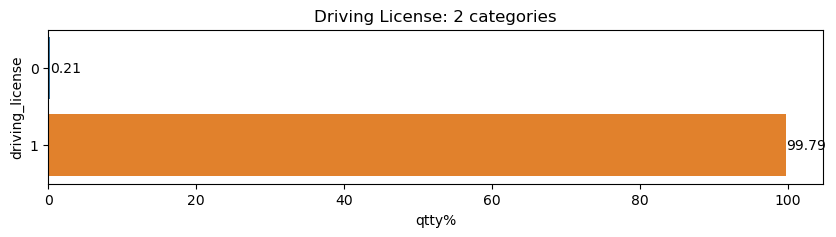

In [59]:
# Driving License: 2 categories - 0/1
tabela = df5.loc[:, ['driving_license', 'id'] ].groupby('driving_license').count().reset_index()
tabela['perc'] = round(100. * tabela['id'] / df5.shape[0], 2)
tabela.columns = ['driving_license', 'qtty', 'qtty%']

# Plot
plt.figure(figsize=(10,2))
b2 = sns.barplot(tabela, y='driving_license', x='qtty%', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='edge')
plt.title('Driving License: 2 categories');

tabela

##### Bivariate Analysis

In [60]:
# função "crosstab": monta tabela de contingência
drivinglicence_tab1 = pd.crosstab( df5['driving_license'], df5['response'] )
drivinglicence_tab1

response,0,1
driving_license,,
0,771,41
1,333628,46669


In [61]:
# tabela de contingência percentual
drivinglicence_tab2 = pd.crosstab( df5['driving_license'], df5['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )
drivinglicence_tab2

response,0,1
driving_license,,
0,94.95,5.05
1,87.73,12.27


#### (c) REGION_CODE

- **(1)** The 53 region codes are probably very important for the analysis, since they represent 53 different socio-economic consumer conditions for the target area.

- **(2)** From the univariate analysis, it can be observed that the first five regions with the greatest amount of registers comprise >50% of the total base, and the first 16 regions comprise >75%.

- **(3)** A new KPI can be derived: region_code_importance = (N# regs by region) / (Total N# regs)

##### Univariate Analysis

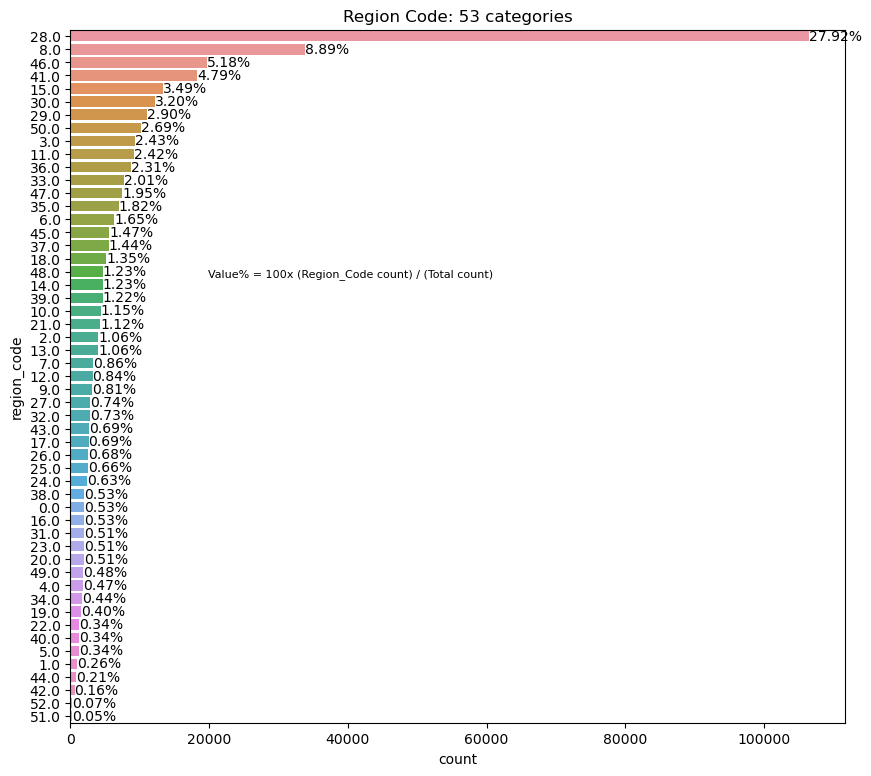

In [62]:
# UNIVARIATE ANALYSIS - Region Code: 53 categories...
plt.figure( figsize=(10, 9) )
b2 = sns.countplot( y='region_code', data=df5, order=df5['region_code'].value_counts().index );
tot = df5['region_code'].count()
for i in b2.containers:
    b2.bar_label(i, label_type='edge', fmt=lambda x: f'{(x/tot)*100:0.2f}%')
plt.title('Region Code: 53 categories');
plt.annotate( 'Value% = 100x (Region_Code count) / (Total count)', xy=(150,360), fontsize=8, xycoords='figure points' );


##### Bivariate Analysis

In [63]:
aux1 = df5.loc[:, ['region_code', 'response'] ].groupby('region_code').sum().reset_index()
aux2 = df5.loc[:, ['region_code', 'id'] ].groupby('region_code').count().reset_index()
regcode = pd.merge( aux1, aux2, how="inner", on=['region_code'] )
regcode.columns = ['region_code', 'response1', 'qtd']
regcode['response0'] = regcode['qtd'] - regcode['response1']
regcode['response%'] = regcode['response1'] / regcode['qtd']

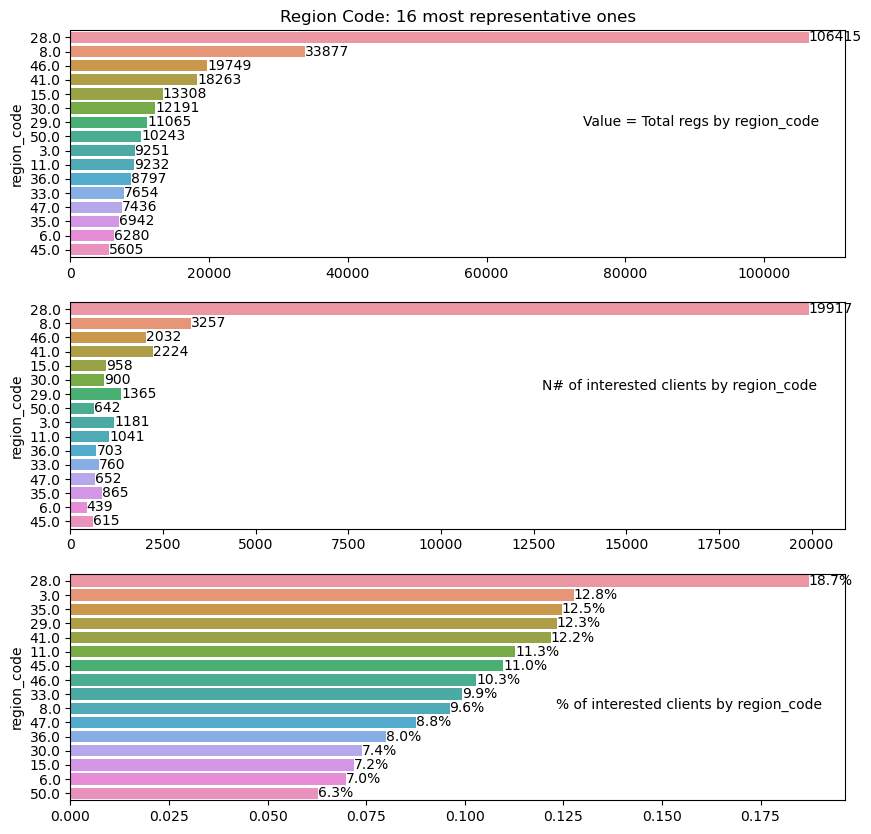

In [64]:
plt.figure(figsize=(10, 10))

# Total pts/Region
plt.subplot(3,1,1)
plt.title('Region Code: 16 most representative ones')
aux = regcode.loc[ regcode['qtd']>5604 , ['region_code', 'qtd'] ].sort_values('qtd', ascending=False).copy()
b1 = sns.barplot( aux, y='region_code', x='qtd', orient='h', order=aux['region_code'] );
b1.set_xlabel('')
tot = regcode['qtd'].sum()
for i in b1.containers:
    #b1.bar_label(i, label_type='edge', fmt=lambda x: f'{(100 * x/tot):0.1f}%')
    b1.bar_label(i, label_type='edge')

# Total pts where response=1
plt.subplot(3,1,2)
aux = regcode.loc[ regcode['qtd']>5604 , ['region_code', 'response1', 'qtd'] ].sort_values('qtd', ascending=False).copy()
b2 = sns.barplot( aux, y='region_code', x='response1', orient='h', order=aux['region_code'] );
b2.set_xlabel('')
tot = regcode['qtd'].sum()
for i in b2.containers:
    #b2.bar_label(i, label_type='edge', fmt=lambda x: f'{(100 * x/tot):0.2f}%')
    b2.bar_label(i, label_type='edge')

# % of pts where response=1
plt.subplot(3,1,3)
aux = regcode.loc[ regcode['qtd']>5604 , ['region_code', 'response%' ] ].sort_values('response%', ascending=False).copy()
b3 = sns.barplot( aux, y='region_code', x='response%', orient='h', order=aux['region_code'] );
b3.set_xlabel('')
for i in b3.containers:
    b3.bar_label(i, label_type='edge', fmt=lambda x: f'{100 * x:0.1f}%')
    #b3.bar_label(i, label_type='edge')

plt.annotate( 'Value = Total regs by region_code', xy=(420,510), fontsize=10, xycoords='figure points' );
plt.annotate( 'N# of interested clients by region_code', xy=(390,320), fontsize=10, xycoords='figure points' );
plt.annotate( '% of interested clients by region_code', xy=(400,90), fontsize=10, xycoords='figure points' );
plt.show()

#### (d) PREVIOUSLY_INSURED

- **(1)** From the whole database, 54,2% of customers do not have a vehicle insurance, while 45,8% already have it.

- **(2)** From those who do not have a vehicle insurance, 22,6% are interested in contracting one.

- **(3)** On the other hand, from those who already have it, 99,91% have NO interest in buying a vehicle insurance.

##### Univariate Analysis

,previously_insured,qtty,qtty%
0,0,206481,54.18
1,1,174628,45.82


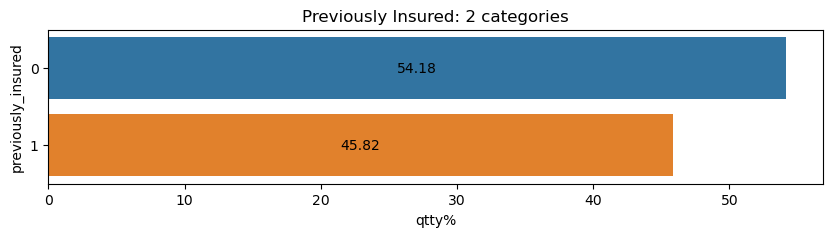

In [65]:
# Previously Insured: 2 categories - 0/1
tabela = df5.loc[:, ['previously_insured', 'id'] ].groupby('previously_insured').count().reset_index()
tabela['perc'] = round(100. * tabela['id'] / df5.shape[0], 2)
tabela.columns = ['previously_insured', 'qtty', 'qtty%']

# Plot
plt.figure(figsize=(10,2))
b2 = sns.barplot(tabela, y='previously_insured', x='qtty%', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='center')
plt.title('Previously Insured: 2 categories');

tabela

##### Bivariate Analysis

In [66]:
# Possíveis problemas:
# 1) o fato de 99,9% dos que já têm seguro não quererem, isso pode significar que não querem mudar de empresa
# 2) pode estar havendo vazamento de dados, pois "previously_insured" está muito relacionado a "response", ie,...
#    ...a variável de entrada está extremamente correlacionada com a saída.

In [67]:
# função "crosstab": monta tabela de contingência
pd.crosstab( df5['previously_insured'], df5['response'] )

response,0,1
previously_insured,,
0,159929,46552
1,174470,158


In [68]:
# aqui: tabela de contingência percentual
previouslyinsured_tab = pd.crosstab( df5['previously_insured'], df5['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )
previouslyinsured_tab

response,0,1
previously_insured,,
0,77.45,22.55
1,99.91,0.09


#### (e) VEHICLE_AGE

- **(1)** Only 4,2% of registers refer to vehicles aging > 2 years. On the other hand, 29,4% of them are inclined to purchase a vehicle insurance. So, raising the number of this kind of clients would probably be beneficial to the business.

- **(2)** Customers with newer cars (<1 year) represent 43,24% of the total, but only 4,4% of these customers are inclined to purchase a vehicle insurance. Why? Do they want to run the risk? Or do they already have a previous insurance?

- **(3)** Customers with cars between 1 and 2 years represent 52,56% of the whole, and 17,4% of them are inclined to purchase a vehicle insurance.

##### Univariate Analysis

,vehicle_age,qtty,qtty%
0,bellow_1_year,164786,43.24
1,between_1_2_years,200316,52.56
2,over_2_years,16007,4.20


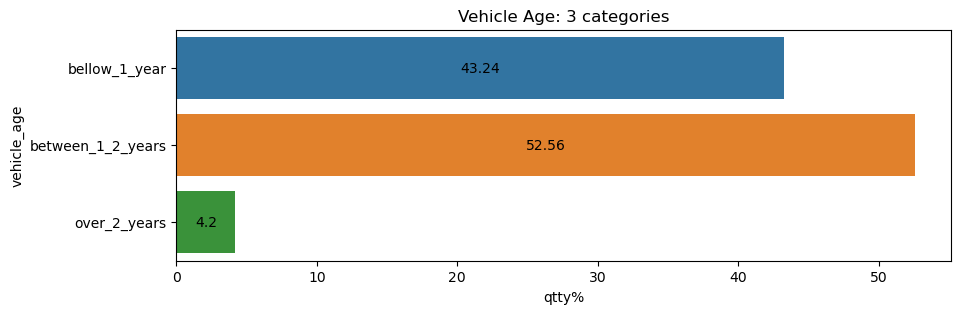

In [69]:
# Vehicle Age: 3 categories -  <1Y, 1-2Y, >2Y
tabela = df5.loc[:, ['vehicle_age', 'id'] ].groupby('vehicle_age').count().reset_index()
tabela['perc'] = round(100. * tabela['id'] / df5.shape[0], 2)
tabela.columns = ['vehicle_age', 'qtty', 'qtty%']

# Plot
plt.figure(figsize=(10,3))
b2 = sns.barplot(tabela, y='vehicle_age', x='qtty%', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='center')
plt.title('Vehicle Age: 3 categories');

tabela

##### Bivariate Analysis

In [70]:
# função "crosstab": monta tabela de contingência
pd.crosstab( df5['vehicle_age'], df5['response'] )

response,0,1
vehicle_age,,
bellow_1_year,157584,7202
between_1_2_years,165510,34806
over_2_years,11305,4702


In [71]:
# aqui: tabela de contingência percentual
vehicleage_tab = pd.crosstab( df5['vehicle_age'], df5['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )
vehicleage_tab

response,0,1
vehicle_age,,
bellow_1_year,95.63,4.37
between_1_2_years,82.62,17.38
over_2_years,70.63,29.37


In [72]:
# ideia: fazer o gráfico de barras sobrepostas...

# Gráficos de barras superpostas e com label:
#REF: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

#### (f) VEHICLE_DAMAGE

- **(1)** The database comprises 49,5% customers who never got their vehicles damaged in the past. And only 0,52% of this group are inclined to purchase a vehicle insurance.

- **(2)** The other customers (50,5%) have already had their vehicles damaged in the past. Among these, 23,8% are inclined to purchase a vehicle insurance.

##### Univariate Analysis

,vehicle_damage,qtty,qtty%
0,0,188696,49.51
1,1,192413,50.49


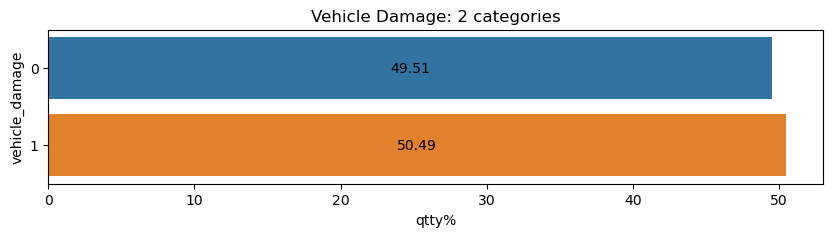

In [73]:
# Vehicle Damage: 2 categories - Yes/No
tabela = df5.loc[:, ['vehicle_damage', 'id'] ].groupby('vehicle_damage').count().reset_index()
tabela['perc'] = round(100. * tabela['id'] / df5.shape[0], 2)
tabela.columns = ['vehicle_damage', 'qtty', 'qtty%']

# Plot
plt.figure(figsize=(10,2))
b2 = sns.barplot(tabela, y='vehicle_damage', x='qtty%', orient='h');
for i in b2.containers:
    b2.bar_label(i, label_type='center')
plt.title('Vehicle Damage: 2 categories');

tabela

##### Bivariate Analysis

In [74]:
# função "crosstab": monta tabela de contingência
pd.crosstab( df5['vehicle_damage'], df5['response'] )

response,0,1
vehicle_damage,,
0,187714,982
1,146685,45728


In [75]:
# tabela de contingência percentual
pd.crosstab( df5['vehicle_damage'], df5['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )

response,0,1
vehicle_damage,,
0,99.48,0.52
1,76.23,23.77


#### (g) POLICY_SALES_CHANNEL

- **(1)** From the univariate analysis, it can be observed that the two most representative channels (152 & 26) comprise more than 56% of the total base, and 90% of the base is spread in just 8 channels.

- **(2)** A new KPI can be derived: policy_sales_channel_importance = (N# regs by channel) / (Total N# regs)

##### Univariate Analysis

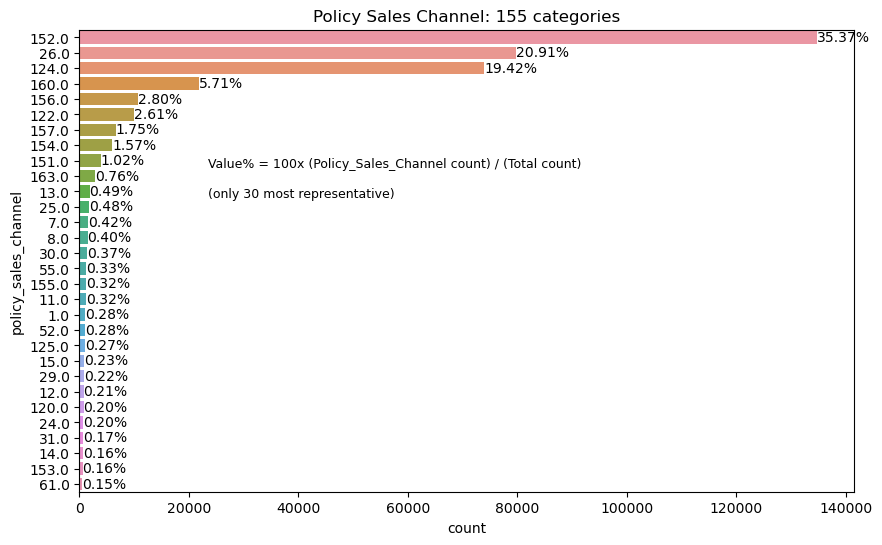

In [76]:
# UNIVARIATE ANALYSIS - Policy Sales Channel: 155 categories...
plt.figure( figsize=(10, 6) )
b2 = sns.countplot( y='policy_sales_channel', 
                   data=df5, order=df5['policy_sales_channel'].value_counts().iloc[:30].index );
tot = df5['policy_sales_channel'].count()
for i in b2.containers:
    b2.bar_label(i, label_type='edge', fmt=lambda x: f'{(x/tot)*100:0.2f}%')
plt.title('Policy Sales Channel: 155 categories');
plt.annotate( 'Value% = 100x (Policy_Sales_Channel count) / (Total count)\n\n(only 30 most representative)', xy=(150,250), fontsize=9, xycoords='figure points' );


##### Bivariate Analysis

In [77]:
aux1 = df5.loc[:, ['policy_sales_channel', 'response'] ].groupby('policy_sales_channel').sum().reset_index()
aux2 = df5.loc[:, ['policy_sales_channel', 'id'] ].groupby('policy_sales_channel').count().reset_index()
regcode = pd.merge( aux1, aux2, how="inner", on=['policy_sales_channel'] )
regcode.columns = ['policy_sales_channel', 'response1', 'qtd']
regcode['response0'] = regcode['qtd'] - regcode['response1']
regcode['response%'] = regcode['response1'] / regcode['qtd']

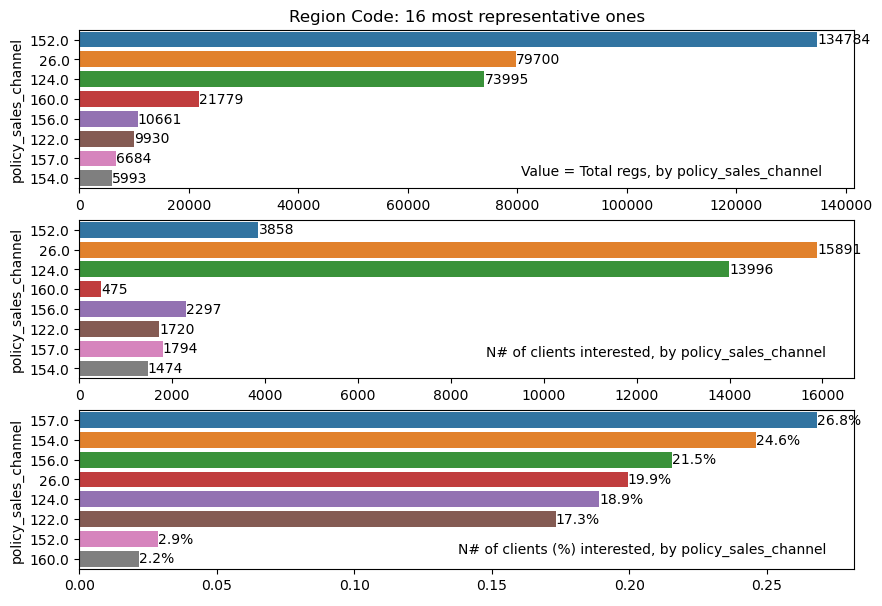

In [78]:
# BIVARIATE ANALYSIS
plt.figure(figsize=(10, 7))

# Total pts/Region
plt.subplot(3,1,1)
plt.title('Region Code: 16 most representative ones')
aux = regcode.loc[ regcode['qtd']>5604 , ['policy_sales_channel', 'qtd'] ].sort_values('qtd', ascending=False).copy()
b1 = sns.barplot( aux, y='policy_sales_channel', x='qtd', orient='h', order=aux['policy_sales_channel'] );
b1.set_xlabel('')
tot = regcode['qtd'].sum()
for i in b1.containers:
    #b1.bar_label(i, label_type='edge', fmt=lambda x: f'{(100 * x/tot):0.1f}%')
    b1.bar_label(i, label_type='edge')

# Total pts where response=1
plt.subplot(3,1,2)
aux = regcode.loc[ regcode['qtd']>5604 , ['policy_sales_channel', 'response1', 'qtd'] ].sort_values('qtd', ascending=False).copy()
b2 = sns.barplot( aux, y='policy_sales_channel', x='response1', orient='h', order=aux['policy_sales_channel'] );
b2.set_xlabel('')
tot = regcode['qtd'].sum()
for i in b2.containers:
    #b2.bar_label(i, label_type='edge', fmt=lambda x: f'{(100 * x/tot):0.2f}%')
    b2.bar_label(i, label_type='edge')

# % of pts where response=1
plt.subplot(3,1,3)
aux = regcode.loc[ regcode['qtd']>5604 , ['policy_sales_channel', 'response%' ] ].sort_values('response%', ascending=False).copy()
b3 = sns.barplot( aux, y='policy_sales_channel', x='response%', orient='h', order=aux['policy_sales_channel'] );
b3.set_xlabel('')
for i in b3.containers:
    b3.bar_label(i, label_type='edge', fmt=lambda x: f'{100 * x:0.1f}%')
    #b3.bar_label(i, label_type='edge')

plt.annotate( 'Value = Total regs, by policy_sales_channel', xy=(375,310), fontsize=10, xycoords='figure points' );
plt.annotate( 'N# of clients interested, by policy_sales_channel', xy=(350,180), fontsize=10, xycoords='figure points' );
plt.annotate( 'N# of clients (%) interested, by policy_sales_channel', xy=(330,38), fontsize=10, xycoords='figure points' );
plt.show()

## 5.2. Multivariate Analysis

In [79]:
# Aim: discover relation among attributes.

### 5.2.1. Numerical Attributes

- **1.** Feature 'vintage' has almost no correlation to the other features, confirming previous analysis of no benefit to the present study.

- **2.** Feature 'annual premium f3' consists of 0,9% of annual_premium points, and shows almost no correlation to the other features, probably bringing no benefit to the present study.

- **3.** Synthetic features 'annual_premium_f1' and 'annual_premium_f2' show important negative correlation to one another, which may enhance machine learning models' results.

- **4.** Synthetic features 'age_rbf_23' and 'age_rbf_43' show important negative correlation to one another, which may enhance machine learning models' results.

- **5.** Synthetic feature 'policy_sales_channel_importance' shows important correlation to all the other numeric features, which may enhance machine learning models' results.

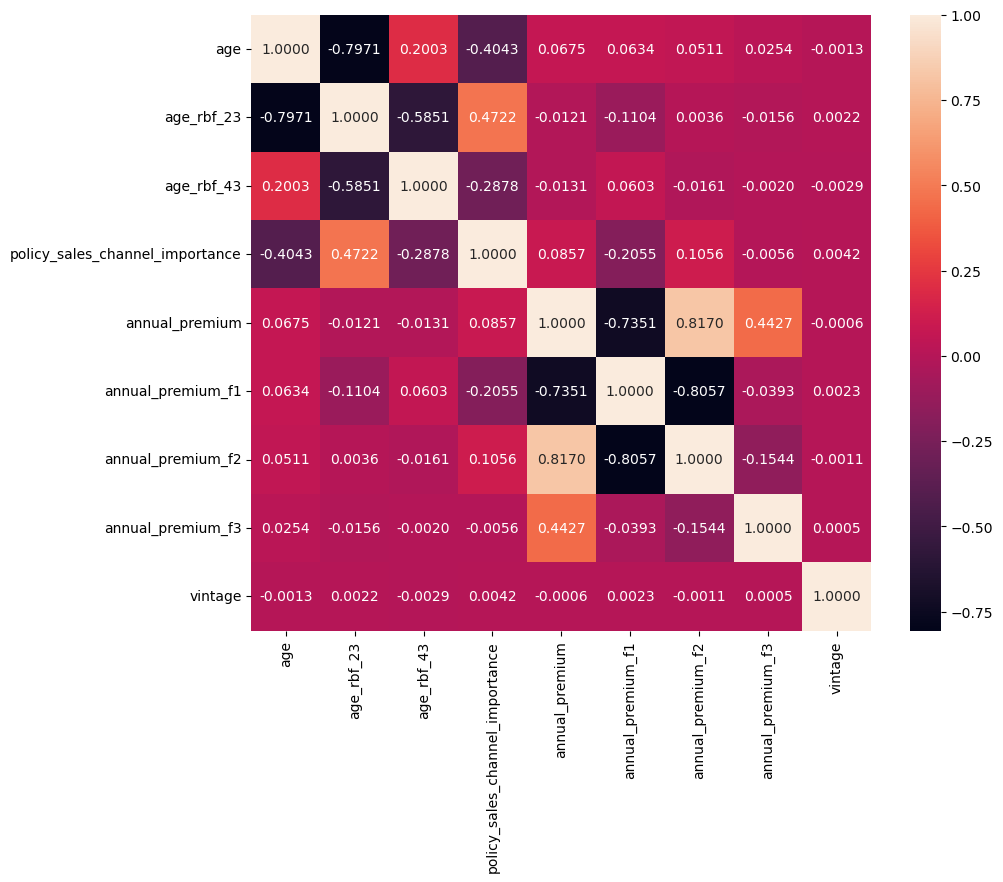

In [80]:
# Select numerical attributes for correlation

num_feat = [ 'age', 'age_rbf_23', 'age_rbf_43', 
             'policy_sales_channel_importance', 
             'annual_premium', 'annual_premium_f1', 'annual_premium_f2', 
             'annual_premium_f3', 'vintage' ]
num_attributes = df5.loc[:, num_feat].copy()

#num_vars = len(num_attributes.columns)

# calcula a matriz de correlação
#correlation_matrix = np.zeros((num_vars, num_vars))
correlation = num_attributes.corr( method='pearson' )

plt.figure( figsize=(10, 8) );
sns.heatmap(correlation, annot=True, fmt='.4f' )
#sns.heatmap( correlation, annot=True, fmt='.4f', cmap='crest', annot_kws={'color':'black'} );

plt.show()


### 5.2.2. Categorical Attributes

**OBSERVAÇÕES** QUANTO AOS SEGUINTES PARES DE CORRELAÇÕES POSITIVAS:

**1.** 'driving_licence' & 'gender' = forte correlação positiva

**2.** 'region_code' & 'policy_sales_channel' = forte correlação positiva

**3.** 'previously_insured' & 'gender' = forte correlação positiva

**OBSERVAÇÕES** QUANTO AOS SEGUINTES PARES DE CORRELAÇÕES NEGATIVAS:

**1.** 'previously_insured' & 'vehicle damage' = correlação negativa.

**2.** 'policy_sales_channel' & 'vehicle_age' = correlação negativa

In [81]:
# Assembling 'correlation' matrix for categorical attributes

# Select categorical features to apply CRAMER'S V function
df_cramer = df5.loc[:,
       ['gender',         'region_code',  'driving_license', 'previously_insured',
        'vehicle_damage', 'vehicle_age',  'policy_sales_channel' ]]

num_vars = len(df_cramer.columns)
correlation_matrix = np.zeros((num_vars, num_vars))

# Create correlation matrix using CRAMER'S V function
for i in range(num_vars):
    for j in range(num_vars):
        if i != j:
            corr = cramer_v(df_cramer.iloc[:, i], df_cramer.iloc[:, j])
            correlation_matrix[i, j] = corr

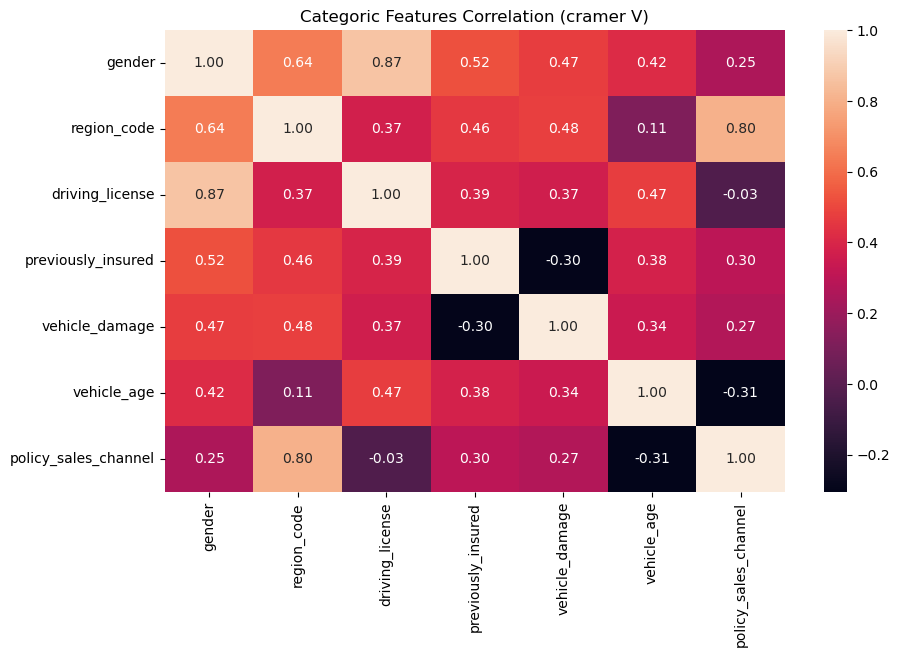

In [82]:
plt.figure(figsize=(10,6))

correlation_df = pd.DataFrame(correlation_matrix, columns=df_cramer.columns, index=df_cramer.columns)
#sns.set(font_scale=0.6)
sns.heatmap(correlation_df.corr(), annot=True, fmt='.2f');
#sns.heatmap(correlation_df.corr(), annot=True, fmt='.3f', cmap='crest');
plt.title("Categoric Features Correlation (cramer V)");

## 5.3. Testing of Hypothesis

### H1. GENDER: will not influence interest for insurance - **FALSE**

**FALSE hypothesis** More male gender people (13.84%) are interested in contracting insurance, when compared to female gender people (10.39%).

In [83]:
gender_tab3

response,0,1
gender,,
Female,89.61,10.39
Male,86.16,13.84


In [84]:
gender_tab1  # total amount per gender

,gender,qtty,qtty%
0,Female,175020,45.92
1,Male,206089,54.08


### H2. CLIENT AGE: interest for insurance will rise with age - **TRUE**

**TRUE hypothesis** People aging around 23 years are less interested (3.7%) in insurance than those around 43 years (27.2%).

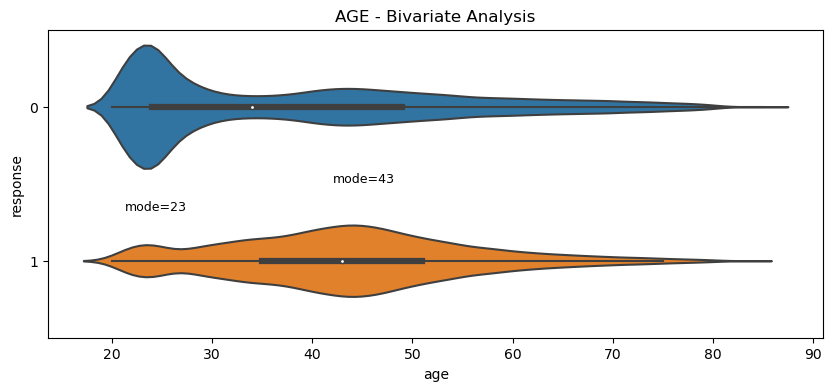

In [85]:
# AGE BIVARIATE ANALYSIS:
plt.figure(figsize=(10, 4))
sns.violinplot(y='response', x='age', orient='h', data=df5);
plt.title('AGE - Bivariate Analysis');
plt.annotate( 'mode=23', xy=(90,130), fontsize=9, xycoords='figure points' );
plt.annotate( 'mode=43', xy=(240,150), fontsize=9, xycoords='figure points' );

In [86]:
# For ages between 21 & 25 years, 3.7% are interested in insurance
aux23 = df5.loc[ (df5['age']>20) & (df5['age']<26), ['response','id'] ].groupby('response').count().reset_index()
aux23

,response,id
0,0,104397
1,1,3876


In [87]:
# For ages between 39 & 47 years, 27.2% are interested in insurance
aux43 = df5.loc[ (df5['age']>38) & (df5['age']<48), ['response','id'] ].groupby('response').count().reset_index()
aux43

,response,id
0,0,54682
1,1,14896


### H3. DRIVING LICENSE: the interest for insurance tends to rise after aquiring a license - **TRUE**

**TRUE hypothesis** From those with driving license, 12.27% are interested in insurance, while just 5.05% of those not licensed are.

In [88]:
drivinglicence_tab2

response,0,1
driving_license,,
0,94.95,5.05
1,87.73,12.27


### H4. REGION CODE: some regions may generate more interest for insurance than others - **TRUE**

**TRUE hypothesis** Some regions present more clients interested in insurance. That can be due to demographic characteristics, like regions with higher crime rates or simply due to more vehicles in an area.

In [89]:
aux1 = df5.loc[:, ['region_code', 'response'] ].groupby('region_code').sum().reset_index()
aux2 = df5.loc[:, ['region_code', 'id'] ].groupby('region_code').count().reset_index()
regcode = pd.merge( aux1, aux2, how="inner", on=['region_code'] )
regcode.columns = ['region_code', 'response1', 'qtd']
regcode['response0'] = regcode['qtd'] - regcode['response1']
regcode['response%'] = regcode['response1'] / regcode['qtd']

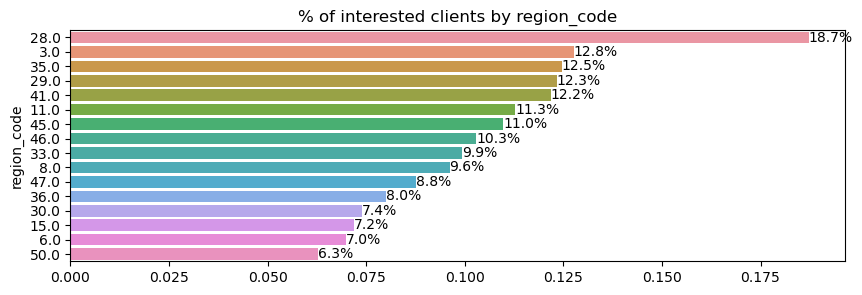

In [90]:
# % of pts where response=1
plt.figure(figsize=(10, 3))
aux = regcode.loc[ regcode['qtd']>5604 , ['region_code', 'response%' ] ].sort_values('response%', ascending=False).copy()
b3 = sns.barplot( aux, y='region_code', x='response%', orient='h', order=aux['region_code'] );
b3.set_xlabel('')
for i in b3.containers:
    b3.bar_label(i, label_type='edge', fmt=lambda x: f'{100 * x:0.1f}%')
    #b3.bar_label(i, label_type='edge')
plt.title('% of interested clients by region_code')
plt.show()

### H5. PREVIOUSLY INSURED: those insured by other insurance companies will be less inclined to become our clients - **TRUE**

**TRUE hypothesis** From those already insured, only less than 0.1% are interested in becoming our client.

- **(1)** From the whole database, 54,2% of customers do not have a vehicle insurance, while 45,8% already have it.

- **(2)** From those who do not have a vehicle insurance, 22,6% are interested in contracting one.

- **(3)** On the other hand, from those who already have it, 99,91% have NO interest in buying a vehicle insurance.

In [91]:
previouslyinsured_tab

response,0,1
previously_insured,,
0,77.45,22.55
1,99.91,0.09


### H6. VEHICLE AGE: the newer the vehicle, the bigger the interest for insurance - **FALSE**

**FALSE hypothesis** Clients with older cars (from one year old) are more inclined to purchase a vehicle insurance, while those with newer cars are less interested. That happens even considering only those who do not already have this kind of insurance.

- **(1)** The third-table consider only those who do not have a previous car insurance (previously_insured = 0). It shows that people with newer cars are less inclined to purchase our car insurance product.


In [92]:
# FIRST TABLE
vehicleage_tab

response,0,1
vehicle_age,,
bellow_1_year,95.63,4.37
between_1_2_years,82.62,17.38
over_2_years,70.63,29.37


In [93]:
# SECOND TABLE
# Let's analyse "vehicle_age", given "previously_insured" = 0
df_not_previously_insured = df5.loc[ df5['previously_insured']==0, ['vehicle_age', 'response', 'id'] ]
# Contingency table
pd.crosstab( df_not_previously_insured['vehicle_age'], df_not_previously_insured['response'] )


response,0,1
vehicle_age,,
bellow_1_year,48389,7140
between_1_2_years,100280,34711
over_2_years,11260,4701


In [94]:
# THIRD TABLE
# Percentual contingency table
pd.crosstab( df_not_previously_insured['vehicle_age'], df_not_previously_insured['response'] ).apply( lambda x: round( 100.0 * x / x.sum(), 2), axis=1 )

response,0,1
vehicle_age,,
bellow_1_year,87.14,12.86
between_1_2_years,74.29,25.71
over_2_years,70.55,29.45


### H7. ANNUAL PREMIUM: higher values will result in less interest for insurance - **TRUE**

**TRUE hypothesis** The so-called "low budget group" shows a discretly higher interest for insurance (13.11% against 12.05%).

- **(1)** Annual Premium values comprise three groups of values, which we named Low Budget Group, Main Group, Extreme Group

- **(2)** Low budget group - the cheapest premium (= $2.630) occurs in 17% of the database.

- **(3)** Main group - 82% of the database includes insurance premiums ranging from $6.098 to $74.300

- **(4)** Extreme group - 0,9% of the cases range from $74.301 to the maximum value of $540.165 [sounds like an outliers group]

In [95]:
annualpremium_tab

,response,annual_premium,ap%,annual_premium_f1,apf1%,annual_premium_f2,apf2%,annual_premium_f3,apf3%
0,0,334399,87.74,56372,86.89,275093,87.95,2934,85.12
1,1,46710,12.26,8505,13.11,37692,12.05,513,14.88


### H8. POLICY SALES CHANNEL: some channels may be more effective in aquiring new clients - **TRUE**

**TRUE hypothesis** There are six channels which are far better then the other 149 ones.

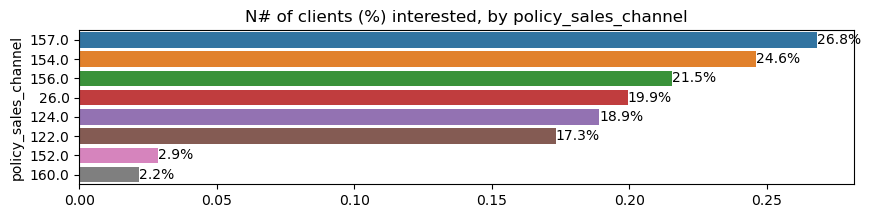

In [96]:
aux1 = df5.loc[:, ['policy_sales_channel', 'response'] ].groupby('policy_sales_channel').sum().reset_index()
aux2 = df5.loc[:, ['policy_sales_channel', 'id'] ].groupby('policy_sales_channel').count().reset_index()
regcode = pd.merge( aux1, aux2, how="inner", on=['policy_sales_channel'] )
regcode.columns = ['policy_sales_channel', 'response1', 'qtd']
regcode['response0'] = regcode['qtd'] - regcode['response1']
regcode['response%'] = regcode['response1'] / regcode['qtd']

# POLICY SALES CHANNEL: BIVARIATE ANALYSIS
plt.figure(figsize=(10, 2))
aux = regcode.loc[ regcode['qtd']>5604 , ['policy_sales_channel', 'response%' ] ].sort_values('response%', ascending=False).copy()
b3 = sns.barplot( aux, y='policy_sales_channel', x='response%', orient='h', order=aux['policy_sales_channel'] );
b3.set_xlabel('')
for i in b3.containers:
    b3.bar_label(i, label_type='edge', fmt=lambda x: f'{100 * x:0.1f}%')
    #b3.bar_label(i, label_type='edge')

plt.title( 'N# of clients (%) interested, by policy_sales_channel' );
plt.show()

### H9. VINTAGE: longer time clients tend to continue clients, supposing they are satisfied with the quality of offered service - **FALSE**

**FALSE hypothesis** 'vintage' shows almost uniform distribution. Probably, no benefit to the present study.

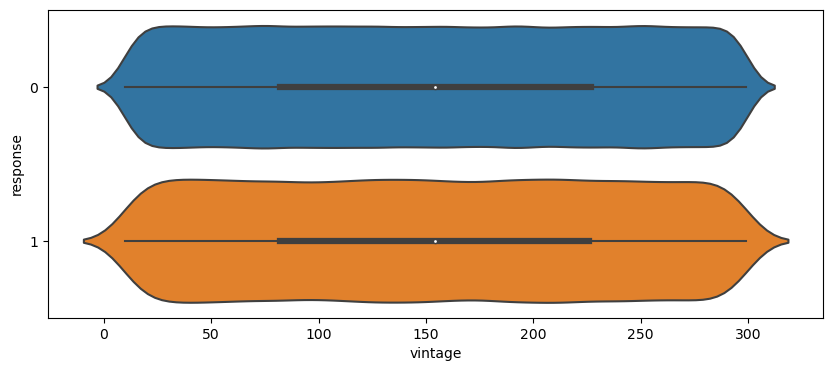

In [97]:
# Bivariate Analysis
plt.figure(figsize=(10, 4))
sns.violinplot(y='response', x='vintage', orient='h', data=df5);

# 6. DATA PREPARATION

In [98]:
# Delete these features, since they were first calculated using train+validation+test lines.
cols_drop = [ 'age_rbf_23', 'age_rbf_43', 'policy_sales_channel_importance' ]
df5 = df5.drop( cols_drop, axis=1 )

## 6.1. DataFitAndTransform Class

In [99]:
class DataFitAndTransform:

    def __init__(self):
        self.ss0 = pp.StandardScaler()
        self.ss1 = pp.StandardScaler()
        self.ss2 = pp.StandardScaler()
        self.ss3 = pp.StandardScaler()
        self.mms_age = pp.MinMaxScaler()
        self.mms_vintage = pp.MinMaxScaler()
        self.ohe_gender_enc = pp.OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
        self.looe_region_code_enc = ce.LeaveOneOutEncoder(cols=['region_code'])
        self.ohe_vehicle_age = pp.OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
        self.fe_policy_sales_channel = None
        self.policy_sales_channel_importance_dict = {}
        self.list_of_features = []
        self.age_rbf_dict = None
        self.age_rbf_23_dict = {}
        self.age_rbf_43_dict = {}

    def DataFitting(self, in_df, y_train):
        """
        Fits the scalers and encoders on the training data.

        Parameters:
        in_df (DataFrame): Input DataFrame containing the training data.
        y_train (Series): Target variable for encoding.
        
        Returns:
        out_df (DataFrame): Prepared DataFrame with all transformations applied.
        """
        
        out_df = in_df.copy()

        #........ Encoding: apply one-hot, target, leave-one-out
        ohe_gender = self.ohe_gender_enc.fit_transform(out_df[['gender']])
        out_df = pd.concat([out_df, ohe_gender], axis=1).drop(columns=['gender'])

        out_df = self.looe_region_code_enc.fit_transform(out_df, y_train)

        #........ Standardization: apply standard-scaler
        out_df['annual_premium'] = self.ss0.fit_transform(out_df[['annual_premium']].values)
        out_df['annual_premium_f1'] = self.ss1.fit_transform(out_df[['annual_premium_f1']].values)
        out_df['annual_premium_f2'] = self.ss2.fit_transform(out_df[['annual_premium_f2']].values)
#        out_df['annual_premium_f3'] = self.ss3.fit_transform(out_df[['annual_premium_f3']].values)

        #.......... Policy Sales Channel
        aux = out_df.loc[:, ['policy_sales_channel', 'id'] ].groupby('policy_sales_channel').count().reset_index()
        aux['policy_sales_channel_importance'] = aux['id'] / aux['id'].max()
        self.policy_sales_channel_importance_dict = aux.set_index('policy_sales_channel')['policy_sales_channel_importance'].to_dict()
        out_df['policy_sales_channel_importance'] = out_df['policy_sales_channel'].map(self.policy_sales_channel_importance_dict)

        self.fe_policy_sales_channel = out_df.groupby('policy_sales_channel').size() / len(out_df)
        out_df['policy_sales_channel'] = out_df['policy_sales_channel'].map(self.fe_policy_sales_channel)

        #.......... Age
        # Since 'age' is a bimodal variable (mode1=23-24, mode2=43): create two features using "rbf_kernel()"
        # REF: Géron, pg.77-80
        centers = [23, 43]
        gamma_23 = 0.030
        gamma_43 = 0.015

        # Use train data to populate dictionaries
        for age in out_df['age'].unique():
            self.age_rbf_23_dict[age] = rbf_kernel([[age]], [[centers[0]]], gamma=gamma_23).flatten()[0]
            self.age_rbf_43_dict[age] = rbf_kernel([[age]], [[centers[1]]], gamma=gamma_43).flatten()[0]

        min_age = int(out_df['age'].min())
        max_age = int(out_df['age'].max())
        #print(f"MinAge={min_age}   MaxAge={max_age}")
        self.rbf_fill_age_rbf_dict(self.age_rbf_23_dict, min_age, max_age)
        self.rbf_fill_age_rbf_dict(self.age_rbf_43_dict, min_age, max_age)

        # Apply results to train data
        out_df['age_rbf_23'] = out_df['age'].map(self.age_rbf_23_dict)
        out_df['age_rbf_43'] = out_df['age'].map(self.age_rbf_43_dict)

        # age (detail: let "age" be the last to be transformed...)
        out_df['age'] = self.mms_age.fit_transform(out_df[['age']].values)

        #........ Encoding: apply one-hot, target, leave-one-out
        ohe = self.ohe_vehicle_age.fit_transform(out_df[['vehicle_age']])
        out_df = pd.concat([out_df, ohe], axis=1).drop(columns=['vehicle_age'])

        #........ vintage: apply min-max-scaler
        out_df['vintage'] = self.mms_vintage.fit_transform(out_df[['vintage']].values)

        return out_df

    def DataTransforming(self, in_df):
        """
        Transforms the test data using the fitted scalers and encoders.

        Parameters:
        in_df (DataFrame): Input DataFrame containing the test data.
        
        Returns:
        out_df (DataFrame): Transformed DataFrame with all transformations applied.
        """
        
        out_df = in_df.copy()
        
        # Encoding
        ohe_gender = self.ohe_gender_enc.transform(out_df[['gender']])
        out_df = pd.concat([out_df, ohe_gender], axis=1).drop(columns=['gender'])

        out_df = self.looe_region_code_enc.transform(out_df)

        # Standardization
        out_df['annual_premium'] = self.ss0.transform(out_df[['annual_premium']].values)
        out_df['annual_premium_f1'] = self.ss1.transform(out_df[['annual_premium_f1']].values)
        out_df['annual_premium_f2'] = self.ss2.transform(out_df[['annual_premium_f2']].values)
#       out_df['annual_premium_f3'] = self.ss3.transform(out_df[['annual_premium_f3']].values)

        # policy_sales_channel (detail: let "policy_sales_channel" be the last to be transformed...)
        out_df['policy_sales_channel_importance'] = out_df['policy_sales_channel'].map(self.policy_sales_channel_importance_dict)
        out_df['policy_sales_channel'] = out_df['policy_sales_channel'].map(self.fe_policy_sales_channel)

        # age (detail: let "age" be the last to be transformed...)
        out_df['age_rbf_23'] = out_df['age'].map(self.age_rbf_23_dict)
        out_df['age_rbf_43'] = out_df['age'].map(self.age_rbf_43_dict)
        out_df['age'] = self.mms_age.transform(out_df[['age']].values)

        ohe = self.ohe_vehicle_age.transform(out_df[['vehicle_age']])
        out_df = pd.concat([out_df, ohe], axis=1).drop(columns=['vehicle_age'])

        # Rescaling
        out_df['vintage'] = self.mms_vintage.transform(out_df[['vintage']].values)

        return out_df

    def get_parameters(self):
        """
        Returns the fitted scalers and encoders.

        Returns:
        dict: Dictionary containing the scalers and encoders.
        """
        return {
            'mms_age': self.mms_age,
            'age_rbf_23': self.age_rbf_23_dict,
            'age_rbf_43': self.age_rbf_43_dict,
            'ss0': self.ss0,  # annual_premium
            'ss1': self.ss1,  # annual_premium_f1
            'ss2': self.ss2,  # annual_premium_f2
            'ss3': self.ss3,  # annual_premium_f3
            'ohe_gender_enc': self.ohe_gender_enc,
            'fe_policy_sales_channel': self.fe_policy_sales_channel,
            'policy_importance_dict': self.policy_sales_channel_importance_dict,
            'looe_region_code_enc': self.looe_region_code_enc,
            'ohe_vehicle_age': self.ohe_vehicle_age,
            'mms_vintage': self.mms_vintage,
        }

    def SaveSelectedFeatures( self, inListOfFeatures ):
        """
        Save list of selected features to future use

        Returns:
        nop: nothing.
        """
        self.list_of_features = inListOfFeatures

    def GetSelectedFeatures( self ):
        """
        Returns list of features.

        Returns:
        list: list of features.
        """
        return self.list_of_features

    def rbf_interpolate_missing_value( self, year, in_dict ):
        previous_year = year - 1
        next_year = year + 1
        prev_val = in_dict.get(previous_year)
        next_val = in_dict.get(next_year)
        
        if prev_val is not None and next_val is not None:
            return (prev_val + next_val) / 2.0
        elif prev_val is not None:
            return prev_val
        elif next_val is not None:
            return next_val
        else:
            return 0

    def rbf_fill_age_rbf_dict( self, in_dict, min_age, max_age ):
        for year in range(min_age, max_age + 1):
            if year not in in_dict:
                in_dict[year] = self.rbf_interpolate_missing_value(year, in_dict)


## 6.2. Split data

In [100]:
#............... SPLIT data & then (later) apply transformations

X = df5.drop( 'response', axis=1 )
y = df5['response'].copy()

# Select ~127k potential clients to run final performance test
x_train_val, x_test, y_train_val, y_test = ms.train_test_split( X, y, test_size=0.3333 )

# divide the "train_val" in train and validation sets.
x_train, x_validation, y_train, y_validation = ms.train_test_split( x_train_val, y_train_val, test_size=0.20 )

In [101]:
# Delete all rows in 'train' where 'annual_premium_f3' <> 0
df6 = x_train
df6['response'] = y_train
df6 = df6[ (df6['annual_premium_f3'] == 0) ]
x_train = df6.drop( 'response', axis=1 )
y_train = df6['response'].copy()

# Delete 'annual_premium_f3' column
x_train = x_train.drop( 'annual_premium_f3', axis=1 )
x_validation = x_validation.drop( 'annual_premium_f3', axis=1 )


In [102]:
( x_train.shape, x_validation.shape, x_test.shape )

((201485, 13), (50817, 13), (127024, 14))

In [103]:
(x_train.shape, y_train.shape)

((201485, 13), (201485,))

In [104]:
# Preparation after splitting: SCALLERS AND ENCODINGS...

# create object
data_preparation_models = DataFitAndTransform()

# Fit train data (create encodings & apply to features)
x_train_prep = data_preparation_models.DataFitting(x_train, y_train)
y_train_prep = y_train  # readability

( x_train_prep.shape, y_train_prep.shape )

((201485, 19), (201485,))

In [105]:
# debug
trained_models = data_preparation_models.get_parameters()
print( trained_models['fe_policy_sales_channel'] )
print( trained_models['policy_importance_dict'] )


policy_sales_channel
1.0      0.002779
2.0      0.000015
3.0      0.001335
4.0      0.001380
6.0      0.000005
           ...   
157.0    0.017426
158.0    0.001216
159.0    0.000099
160.0    0.057334
163.0    0.007733
Length: 149, dtype: float64
{1.0: 0.007836003638144547, 2.0: 4.1978590918631495e-05, 3.0: 0.003764080319037291, 4.0: 0.0038900160917931855, 6.0: 1.3992863639543833e-05, 7.0: 0.011586091093542293, 8.0: 0.011362205275309591, 9.0: 0.0014692506821521025, 10.0: 0.0019590009095361367, 11.0: 0.009137339956622123, 12.0: 0.005904988455887498, 13.0: 0.013629049184915693, 14.0: 0.00467361645560764, 15.0: 0.006478695865108794, 16.0: 0.0039180018190722735, 17.0: 6.996431819771916e-05, 18.0: 0.001077450500244875, 19.0: 0.0016931365003848037, 20.0: 0.00016791436367452598, 21.0: 0.001077450500244875, 22.0: 0.0026166655005946966, 23.0: 0.003022458546141468, 24.0: 0.005275309592108025, 25.0: 0.013699013503113412, 26.0: 0.5878821800881551, 27.0: 1.3992863639543833e-05, 28.0: 2.798572727908

In [106]:
# Apply scalers&encodings to validation set
x_validation_prep = data_preparation_models.DataTransforming(x_validation)
x_validation_prep = x_validation_prep.fillna(0)    # fillna

y_validation_prep = y_validation
( x_validation_prep.shape, y_validation_prep.shape )

((50817, 19), (50817,))

## 6.3. Resampling (x_train)

In [107]:
# Informing: characteristics of "Response" variable: 2 categories - 0/1
targ = df1.loc[:, ['response', 'id'] ].groupby('response').count().reset_index()
targ['perc'] = round(100. * targ['id'] / df1.shape[0], 2)
targ.columns = ['response', 'qtty', 'qtty%']
targ

,response,qtty,qtty%
0,0,334399,87.74
1,1,46710,12.26


- The TARGET data is unballanced, with **87,74%** of ZEROES & **12,26%** of ONES

- Possible solutions:

- **(1)** SMOTE + Tomek

- **(2)** ADASYN

- **(3)** Balanced Random Forest Classifier

- **(4)** Balanced RFC with balanced classes

In [108]:
# Solution used: SMOTE + Tomek
x_train_prep, y_train_prep = SMOTETomek(random_state=42).fit_resample(x_train_prep, y_train_prep)

(x_train_prep.shape, y_train_prep.shape)

((315664, 19), (315664,))

# 7. FEATURE IMPORTANCE / SELECTION

In [109]:
Run_Feature_Importance = True

In [110]:
# save a copy
x_train_prep1 = x_train_prep
x_validation_prep1 = x_validation_prep
#x_test_prep1 = x_test_prep

## 7.0 functions

### Single-Validation function

In [111]:
def performance_metrics_at_k( data, k=20000 ):
    """
    Calculates metrics to the first "k" points of "data"

    Args:
    data: DataFrame containing predictions sorted by score.
    k: position up to which recall is calculated.

    Returns: precision, recall, f1, TN, FP, FN, TP
    """
    df = data.head(k)

    df = df.reset_index(drop=True)

    # metrics
    precision_k = precision_score(df['response'], df['preview'])
    recall_k = recall_score(df['response'], df['preview'])
    f1_k = f1_score(df['response'], df['preview'])
    cm_k = mt.confusion_matrix( df['response'], df['preview'] )
    print( f"TOT={k}  TP={cm_k[1,1]}  FP={cm_k[0,1]}  FN={cm_k[1,0]}  TN={cm_k[0,0]}" )

    # list of return values
    ret_val = [
        precision_k,
        recall_k,
        f1_k,
        cm_k[0,0],  # TN
        cm_k[0,1],  # FP
        cm_k[1,0],  # FN
        cm_k[1,1],  # TP
    ]
    return ret_val


In [112]:
def single_validation_metrics(model_name, x_val, y_val, yhat_proba, yhat ):

    # metrics
    data = x_val.copy()
    data['response'] = y_val.copy()
    data['preview'] = yhat.copy()
    data['score'] = yhat_proba[:, 1].tolist()
    data = data.sort_values('score', ascending=False)

    cm = mt.confusion_matrix( y_val, yhat )
    print( f"TOT={data.shape[0]}  TP={cm[1,1]}  FP={cm[0,1]}  FN={cm[1,0]}  TN={cm[0,0]}" )

    # Why k=20000? See problem definition
    vals = performance_metrics_at_k( data, 20000 )
    nprec_k20 = vals[0]
    nrec_k20 = vals[1]
    f1_k20 = vals[2]
    tn_k20 = vals[3]
    fp_k20 = vals[4]
    fn_k20 = vals[5]
    tp_k20 = vals[6]
    # Why k=40000? See problem definition
    vals = performance_metrics_at_k( data, 40000 )
    nprec_k40 = vals[0]
    nrec_k40 = vals[1]
    f1_k40 = vals[2]
    tn_k40 = vals[3]
    fp_k40 = vals[4]
    fn_k40 = vals[5]
    tp_k40 = vals[6]

    # return dataframe with calculated metrics
    ndecs = 6
    df = pd.DataFrame({
        'Model Name': model_name,
        'Accuracy': 100. * np.round(accuracy_score(y_val, yhat), ndecs),
        'Precision': 100. * np.round(precision_score(y_val, yhat), ndecs),
        'Recall': 100. * np.round(recall_score(y_val, yhat), ndecs),
        'F1': 100. * f1_score(y_val, yhat),
        'cm.pos': f"TP={cm[1,1]}  FP={cm[0,1]}",
        'cm.neg': f"FN={cm[1,0]}  TN={cm[0,0]}  TOT={data.shape[0]}",
        'Precision@20k': 100. * np.round(nprec_k20, ndecs),
        'Recall@20k': 100. * np.round(nrec_k20, ndecs),
        'F1@20k': 100. * np.round(f1_k20, ndecs),
        'cm.pos.20k': f"TP={tp_k20}  FP={fp_k20}",
        'cm.neg.20k': f"FN={fn_k20}  TN={tn_k20}  TOT=20k",
        'Precision@40k': 100. * np.round(nprec_k40, ndecs),
        'Recall@40k': 100. * np.round(nrec_k40, ndecs),
        'F1@40k': 100. * np.round(f1_k40, ndecs),
        'cm.pos.40k': f"TP={tp_k40}  FP={fp_k40}",
        'cm.neg.40k': f"FN={fn_k40}  TN={tn_k40}  TOT=40k",
    }, index=[0])

    return df

In [113]:
#def precision_at_k(data, k=20000):
#    """
#    Calculates precision up to the first "k" points of "data"
#    
#    Args:
#    data: DataFrame containing predictions sorted by score.
#    k: position up to which precision is calculated.

#    Returns:
#    precision_at_k: precision at point k.
#    data: updated DataFrame.
#    """
#    data = data.reset_index(drop=True)
#    # create ranking order
#    data['ranking'] = data.index + 1
#    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
#    return data.loc[k, 'precision_at_k'], data

#def recall_at_k(data, k=20000):
#    """
#    Calculates recall up to the first "k" points of "data"

#    Args:
#    data: DataFrame containing predictions sorted by score.
#    k: position up to which recall is calculated.

#    Returns:
#    recall_at_k: recall at point k.
#    data: updated DataFrame.
#    """
#    data = data.reset_index(drop=True)
#    # create ranking order
#    data['ranking'] = data.index + 1
#    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
#    return data.loc[k, 'recall_at_k'], data

### Cross-Validation function

In [114]:
def cross_validation(model, x_train, y_train, n_of_folds, encoder=0, Verbose=True):
    """
    Performs stratified k-fold cross-validation on a machine learning model.

    Args:
    model: machine learning model to be trained and evaluated.
    x_train: DataFrame containing the training features.
    y_train: Series containing the training labels.
    n_of_folds: number of folds for cross-validation.
    encoder: a function or transformer that applies the encoding.
    Verbose: if True, prints progress information.

    Returns:
    df: DataFrame containing model performance metrics.
    """
    
    # Initialize StratifiedKFold to ensure class proportion in each fold
    kfold = ms.StratifiedKFold(n_splits=n_of_folds, shuffle=True, random_state=28)

    # Initialize lists to store metrics
    balanced_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []
#    precision_k_list = []
    precision_20k_list = []
    precision_40k_list = []
#    recall_k_list = []
    recall_20k_list = []
    recall_40k_list = []
    f1_20k_list = []
    f1_40k_list = []
    tp_20k_list = []
    tn_20k_list = []
    fp_20k_list = []
    fn_20k_list = []
    tp_40k_list = []
    tn_40k_list = []
    fp_40k_list = []
    fn_40k_list = []

    i = 1  # Fold counter

    # Perform cross-validation
    for train_cv, val_cv in kfold.split(x_train, y_train):

        print(f'{i}', end=" ")
        #print( f"x_in={x_train.shape}  y={y_train.shape}" )

        # Split the data into training and validation sets for the current fold
        x_train_fold = x_train.iloc[train_cv].copy()
        y_train_fold = y_train.iloc[train_cv].copy()
        x_val_fold = x_train.iloc[val_cv].copy()
        y_val_fold = y_train.iloc[val_cv].copy()

        if encoder != 0:
            # From 6.2 - Fit training fold & transform validation fold
            #print( f"x_tr_fold={x_train_fold.shape}  y={y_train_fold.shape}" )
            x_train_fold_encoded = encoder.DataFitting(x_train_fold, y_train_fold)
            #print( f"x_val_fold={x_val_fold.shape}" )
            x_val_fold_encoded = encoder.DataTransforming(x_val_fold)
            x_val_fold_encoded = x_val_fold_encoded.fillna(0)    # fillna
            # From 6.3 - Apply resampling (SMOTE + Tomek)
            x_train_fold_encoded, y_train_fold = (
                SMOTETomek(random_state=42).fit_resample(x_train_fold_encoded, y_train_fold)
            )
            # From 7.8 and 8.0 - Filter selected features
            selected_features = encoder.GetSelectedFeatures()
            #print( f"selected = {selected_features}" )
            x_train_fold_encoded = x_train_fold_encoded[ selected_features ]
            x_val_fold_encoded = x_val_fold_encoded[ selected_features ]

        # Train the model on the current fold
        #print( f"x_encoded={x_train_fold_encoded.shape}  y={y_train_fold.shape}" )
        #print( x_train_fold_encoded.sample(4).T )
        model.fit(x_train_fold_encoded, y_train_fold.values.ravel())

        # Make probability and label predictions on the validation set
        yhat = model.predict_proba(x_val_fold_encoded)
        yhat_1 = model.predict(x_val_fold_encoded)

        # Prepare data for metrics calculation
        validation_data = x_val_fold_encoded.copy()
        validation_data['response'] = y_val_fold.copy()
        validation_data['score'] = yhat[:, 1].tolist()
        validation_data = validation_data.sort_values('score', ascending=False)

        # Calculate and store precision
        precision = precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)
        # Calculate and store recall
        recall = recall_score(y_val_fold, yhat_1)
        recall_list.append(recall)
        # Calculate and store balanced accuracy
        balanced_accuracy = balanced_accuracy_score(y_val_fold, yhat_1)
        balanced_list.append(balanced_accuracy)
        # Calculate and store f1
        f1 = f1_score(y_val_fold, yhat_1)
        f1_list.append(f1)
        # Calculate Confusion Matrix
        cm = mt.confusion_matrix( y_val_fold, yhat_1 )
        tp_list.append(cm[1,1])
        tn_list.append(cm[0,0])
        fp_list.append(cm[0,1])
        fn_list.append(cm[1,0])

        # Calculate and store metrics at k
        data = x_val_fold_encoded.copy()
        data['response'] = y_val_fold.copy()
        data['preview'] = yhat_1.copy()
        data['score'] = yhat[:, 1].tolist()  # ...proba
        data = data.sort_values('score', ascending=False)
        # Metrics for k = 20k
        vals = performance_metrics_at_k( data, 20000 )
        precision_20k_list.append(vals[0])
        recall_20k_list.append(vals[1])
        f1_20k_list.append(vals[2])
        tn_20k_list.append(vals[3])
        fp_20k_list.append(vals[4])
        fn_20k_list.append(vals[5])
        tp_20k_list.append(vals[6])
        # Metrics for k = 40k
        vals = performance_metrics_at_k( data, 40000 )
        precision_40k_list.append(vals[0])
        recall_40k_list.append(vals[1])
        f1_40k_list.append(vals[2])
        tn_40k_list.append(vals[3])
        fp_40k_list.append(vals[4])
        fn_40k_list.append(vals[5])
        tp_40k_list.append(vals[6])

        i += 1  # Increment fold counter

    # Create a DataFrame with calculated metrics
    df = pd.DataFrame({
        'Model Name': type(model).__name__,
        'Balanced Accuracy Mean': 100.0 * np.mean(balanced_list),
        'Precision Mean': 100.0 * np.round(np.mean(precision_list), 7),
        'Precision STD': 100.0 * np.round(np.std(precision_list), 4),
        'Recall Mean': 100.0 * np.round(np.mean(recall_list), 7),
        'Recall STD': 100.0 * np.round(np.std(recall_list), 4),
        'F1 Mean': 100.0 * np.round(np.mean(f1_list), 7),
        'F1 STD': 100.0 * np.round(np.std(f1_list), 4),
        'cm.pos': f"TP={int(np.mean(tp_list))}  FP={int(np.mean(fp_list))}",
        'cm.neg': f"FN={int(np.mean(fn_list))}  TN={int(np.mean(tn_list))}  TOT={x_train.shape[0]}",
        'Precision@20k Mean': 100.0 * np.round(np.mean(precision_20k_list), 7),
        'Precision@20k STD': 100.0 * np.round(np.std(precision_20k_list), 4),
        'Recall@20k Mean': 100.0 * np.round(np.mean(recall_20k_list), 7),
        'Recall@20k STD': 100.0 * np.round(np.std(recall_20k_list), 4),
        'F1@20k Mean': 100.0 * np.round(np.mean(f1_20k_list), 7),
        'F1@20k STD': 100.0 * np.round(np.std(f1_20k_list), 4),
        'TP@20k': int(np.mean(tp_20k_list)),
        'cm.pos.20k': f"TP={int(np.mean(tp_20k_list))}  FP={int(np.mean(fp_20k_list))}",
        'cm.neg.20k': f"FN={int(np.mean(fn_20k_list))}  TN={int(np.mean(tn_20k_list))}  TOT=20k",
        'Precision@40k Mean': 100.0 * np.round(np.mean(precision_40k_list), 7),
        'Precision@40k STD': 100.0 * np.round(np.std(precision_40k_list), 4),
        'Recall@40k Mean': 100.0 * np.round(np.mean(recall_40k_list), 7),
        'Recall@40k STD': 100.0 * np.round(np.std(recall_40k_list), 4),
        'F1@40k Mean': 100.0 * np.round(np.mean(f1_40k_list), 7),
        'F1@40k STD': 100.0 * np.round(np.std(f1_40k_list), 4),
        'cm.pos.40k': f"TP={int(np.mean(tp_40k_list))}  FP={int(np.mean(fp_40k_list))}",
        'cm.neg.40k': f"FN={int(np.mean(fn_40k_list))}  TN={int(np.mean(tn_40k_list))}  TOT=40k",
    }, index=[0])
    
    return df


### KNN Optimization Function

In [115]:
# There was a time when KNN sounded like the best model...
def KNN_optimization( k_init, k_end, in_weights='uniform', in_metric='minkowski', in_p=2 ):

    Precision_list = list()
    F1_list = list()
    best_k_f1 = 0
    best_F1 = 0

    best_k_pr = 0
    best_Precision = 0
    knn_BestClassifier = 0

    Recall_list = list()
    best_k_rc = 0
    best_Recall = 0

    KK = range( k_init, k_end+1, 2 )
    for k in KK:

        print(k, end = " ")
        knn_classifier = KNeighborsClassifier( 
                            n_neighbors = k,
                            weights = in_weights,
                            metric = in_metric,
                            p = in_p
                        )
        knn_classifier.fit( x_train_prep, y_train_prep )
        yhat_val = knn_classifier.predict( x_validation_prep )
        # Save result in dataset
        df_result = x_validation_prep.copy()
        df_result['classification'] = yhat_val

        # Performance Metrics
        Precision = mt.precision_score( y_validation_prep, yhat_val )
        Recall = mt.recall_score( y_validation_prep, yhat_val )
        F1 = mt.f1_score( y_validation_prep, yhat_val )

        Precision_list.append(Precision)
        Recall_list.append(Recall)
        F1_list.append(F1)

        if Recall > best_Recall:
            best_Recall = Recall
            best_k_rc = k

        if Precision > best_Precision:
            best_Precision = Precision
            best_k_pr = k

        if F1 > best_F1:
            best_F1 = F1
            best_k_f1 = k
            knn_BestClassifier = knn_classifier
            print( f"\nk={k}  F1={best_F1}", end = " " )

    # Show best result:
    print(f"\nKNN - best Precision .. k: {best_k_pr}")
    print(  f"KNN - best F1 ......... k: {best_k_f1}")
    print(  f"KNN - best Recall ..... k: {best_k_rc}")

    # Create a list with the return values
    retlist = [
        knn_BestClassifier,
        best_k_f1,
        best_k_rc, 
        Precision_list, 
        Recall_list,
        KK,
        best_k_pr
    ]
    return retlist


## 7.1 Feature Importance: Boruta + ExtraTrees

In [116]:
x_train_prep.columns

Index(['id', 'age', 'driving_license', 'region_code', 'previously_insured',
       'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage',
       'annual_premium_f1', 'annual_premium_f2', 'gender_Female',
       'gender_Male', 'policy_sales_channel_importance', 'age_rbf_23',
       'age_rbf_43', 'vehicle_age_bellow_1_year',
       'vehicle_age_between_1_2_years', 'vehicle_age_over_2_years'],
      dtype='object')

In [117]:
if Run_Feature_Importance:

    x_train_n = x_train_prep.drop( ['id'], axis=1).values
    y_train_n = y_train_prep.values.ravel()

    # Define model
    et = en.ExtraTreesClassifier( n_jobs=-1 )

    # Define boruta
    np.int = np.int32
    np.float = np.float64
    np.bool = np.bool_
    boruta = BorutaPy( et, n_estimators='auto', verbose=2, random_state=42 ).fit(x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	1


In [118]:
cols_selected_boruta = 0
cols_not_selected_boruta = 0

if Run_Feature_Importance:

    cols_selected = boruta.support_.tolist()

    # best features
    x_train_fs = x_train_prep.drop( ['id'], axis=1 )
    cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

    # not selected boruta
    cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

cols_selected_boruta

['age',
 'region_code',
 'previously_insured',
 'vehicle_damage',
 'annual_premium',
 'policy_sales_channel',
 'vintage',
 'annual_premium_f1',
 'annual_premium_f2',
 'gender_Female',
 'gender_Male',
 'policy_sales_channel_importance',
 'age_rbf_23',
 'age_rbf_43',
 'vehicle_age_bellow_1_year',
 'vehicle_age_between_1_2_years',
 'vehicle_age_over_2_years']

In [119]:
cols_not_selected_boruta

# 23.7.2024: cols_not_selected_boruta = ['annual_premium_f3', 'driving_license']
# Results similar to 5.1.1 & 5.1.2

['driving_license']

## 7.2 Feature Importance: ExtraTrees

In [120]:
# Alternative to BORUTA

if Run_Feature_Importance:

    # model definition
    forest = en.ExtraTreesClassifier( n_estimators=1000, random_state=42, n_jobs=-1 )

    # data preparation
    x_train_n = x_train_prep.drop( ['id'], axis=1 )
    y_train_n = y_train_prep.values
    forest.fit( x_train_n, y_train_n )

Feature ranking:
                           feature  importance
0               previously_insured    0.175017
0                   vehicle_damage    0.127521
0                      region_code    0.114970
0                       age_rbf_43    0.064907
0  policy_sales_channel_importance    0.056890
0             policy_sales_channel    0.053340
0        vehicle_age_bellow_1_year    0.051363
0    vehicle_age_between_1_2_years    0.047394
0                       age_rbf_23    0.043535
0                              age    0.042824
0                          vintage    0.039712
0                annual_premium_f2    0.035956
0                      gender_Male    0.035892
0                    gender_Female    0.035395
0                   annual_premium    0.035166
0                annual_premium_f1    0.026776
0         vehicle_age_over_2_years    0.013047
0                  driving_license    0.000294


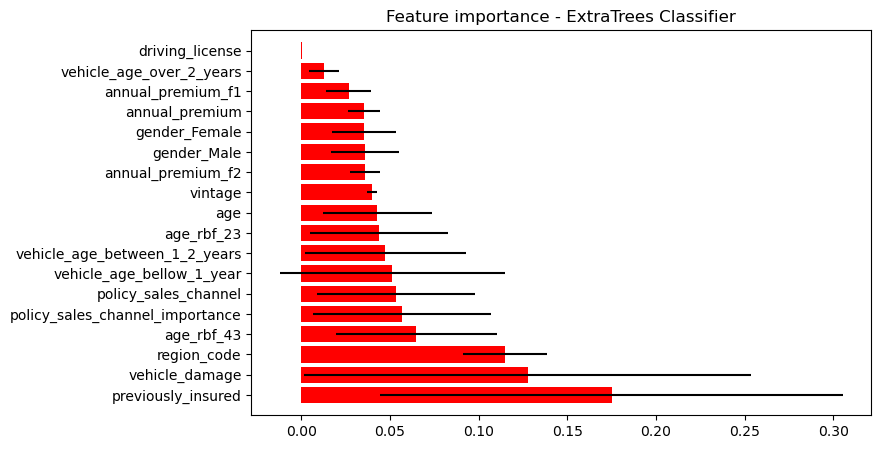

In [121]:
if Run_Feature_Importance:

    importances = forest.feature_importances_
    std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
    indices = np.argsort(importances)[::-1]

    # print feature ranking
    print("Feature ranking:")
    df = pd.DataFrame()
    for i, j in zip( x_train_n, forest.feature_importances_ ):
        aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
        df = pd.concat( [df, aux], axis=0 )

    df = df.sort_values( 'importance', ascending=False )
    print( df )

    # Plot the impurity-based feature importance from random forest
    plt.figure( figsize=(8, 5) )
    plt.title( "Feature importance - ExtraTrees Classifier" )
    plt.barh( df['feature'], df['importance'], color="r", xerr=std[indices] )
    plt.yticks( range(x_train_n.shape[1]), df['feature'] )
    plt.ylim( [-1, x_train_n.shape[1]] )
    plt.show()

## 7.3 Feature Importance: Boruta + LightGBM

In [122]:
if Run_Feature_Importance:

    x_train_n = x_train_prep.drop( ['id'], axis=1).values
    y_train_n = y_train_prep.values.ravel()

    # define RandomForestRegressor
    lgb = LGBMClassifier( n_estimators=100, random_state=42, n_jobs=-1, verbose=-1 )

    # Define boruta
    boruta = BorutaPy( estimator=lgb, n_estimators=100, verbose=2, random_state=42 )
    boruta.fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	18
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	3
Rejected: 	2
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	3
Rejected: 	2
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	3
Rejected: 	2
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	3
Rejected: 	2
Iteration: 	12 / 100
Confirmed: 	14
Tentative: 	2
Rejected: 	2
Iteration: 	13 / 100
Confirmed: 	14
Tentative: 	1
Rejected: 	3
Iteration: 	14 / 100
Confirmed: 	14
Tentative: 	1
Rejected: 	3
Iteration: 	15 / 100
Confirmed: 	14
Tentative: 	1
Rejected: 	3
Iteration: 	16 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	4



In [123]:
cols_selected = 0
cols_not_selected_boruta = 0

if Run_Feature_Importance:

    cols_selected = boruta.support_.tolist()

    # best features
    x_train_fs = x_train_prep.drop( ['id'], axis=1 )
    cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

    # not selected boruta
    cols_not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

cols_selected_boruta

['age',
 'region_code',
 'previously_insured',
 'vehicle_damage',
 'annual_premium',
 'policy_sales_channel',
 'vintage',
 'annual_premium_f1',
 'gender_Female',
 'age_rbf_23',
 'age_rbf_43',
 'vehicle_age_bellow_1_year',
 'vehicle_age_between_1_2_years',
 'vehicle_age_over_2_years']

In [124]:
cols_not_selected_boruta

# 23.7.2024: ['annual_premium_f3', 'driving_license', 'gender_Male', 'vintage', 'vehicle_age_over_2_years']
# 12.8.2024: ['annual_premium_f3', 'driving_license', 'gender_Male', 'vintage']


['annual_premium_f2',
 'driving_license',
 'gender_Male',
 'policy_sales_channel_importance']

## 7.4 Feature Importance: LightGBM

In [125]:
# Alternative to BORUTA

if Run_Feature_Importance:

    # model definition
    lgb = LGBMClassifier( n_estimators=1000, random_state=42, n_jobs=-1, verbose=-1 )

    # data preparation
    x_train_n = x_train_prep.drop( ['id'], axis=1 )
    y_train_n = y_train_prep.values
    lgb.fit( x_train_n, y_train_n )

Feature ranking:
                           feature  importance
0                      region_code        8792
0                          vintage        4486
0                   annual_premium        3232
0             policy_sales_channel        2623
0                              age        2300
0                       age_rbf_43        2280
0                       age_rbf_23        2268
0                annual_premium_f2        1182
0                   vehicle_damage         549
0                    gender_Female         506
0               previously_insured         358
0                annual_premium_f1         342
0                      gender_Male         326
0    vehicle_age_between_1_2_years         297
0        vehicle_age_bellow_1_year         235
0         vehicle_age_over_2_years         206
0                  driving_license          18
0  policy_sales_channel_importance           0


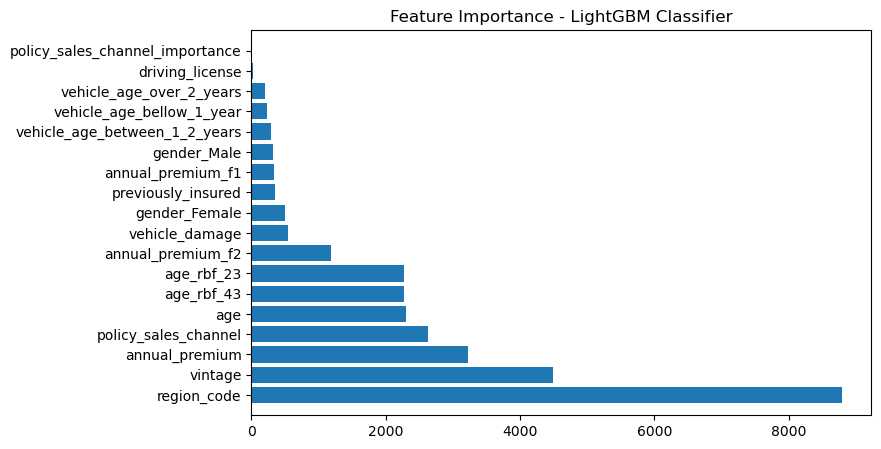

In [126]:
if Run_Feature_Importance:

    # Obter a importância das características
    importances = lgb.feature_importances_

    # Obter os índices das características ordenadas pela importância
    indices = np.argsort(importances)[::-1]

    # Imprimir as características e suas importâncias ordenadas
    print("Feature ranking:")
    df = pd.DataFrame()
    for i, j in zip( x_train_n, lgb.feature_importances_ ):
        aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
        df = pd.concat( [df, aux], axis=0 )

    df = df.sort_values( 'importance', ascending=False )
    print( df )

    # Ordenar as características por importância
    sorted_indices = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_indices]
    sorted_features = x_train_n.columns[sorted_indices]

    # Criar o gráfico de barras
    plt.figure(figsize=(8, 5))
    plt.title("Feature Importance - LightGBM Classifier")
    plt.barh(range(x_train_n.shape[1]), sorted_importances, align='center')
    plt.yticks(range(x_train_n.shape[1]), sorted_features)
    plt.ylim([-1, x_train_n.shape[1]])
    plt.show()

## 7.5 Gradual Exclusion of Features

- More properly: "Recursive Feature Elimination", as observed by Gabriel Teixeira (comments in [this post](https://www.linkedin.com/posts/manoelmendonca-eng-adv_datascience-machinelearning-featureselection-activity-7236360978865545219--TO_?utm_source=share&utm_medium=member_desktop))

In [127]:
# get a copy of the dataframe (in case you want to run from here)
x_train_prep = x_train_prep1
x_validation_prep = x_validation_prep1
#x_test_prep = x_test_prep1

### Logistic Regression

In [128]:
cols_selected_boruta = [
 'age',                    # trial&error excluded
 'age_rbf_23',             # trial&error excluded
 'age_rbf_43',
 'annual_premium',         # trial&error excluded
 'annual_premium_f1',
 'annual_premium_f2',
# 'annual_premium_f3',           # excluded by boruta
 'driving_license',             # excluded by boruta
 'gender_Female',
 'gender_Male',                     # trial&error included
 'policy_sales_channel',
 'policy_sales_channel_importance',
 'previously_insured',
 'region_code',
 'vehicle_age_bellow_1_year',
# 'vehicle_age_between_1_2_years',
# 'vehicle_age_over_2_years',    # excluded by boruta
 'vehicle_damage',
 'vintage',                     # excluded by boruta
]


In [129]:
#............... Exclude features, one after the other, and adjust the model
# (runs fast...)
if Run_Feature_Importance:

    Single0_1CrossVal = False

    #............... Default case
    selected_features = cols_selected_boruta
    # prepare dataframe
    x_train_prep = x_train_prep1[ selected_features ]
    x_validation_prep = x_validation_prep1[ selected_features ]
    # KNN Optimization
    print("")
    print(f"==================== Benchmark case ====================")
    print(f"selected features = {selected_features}")
    lr_model = lm.LogisticRegression( random_state=42 )
    lr_model.fit( x_train_prep, y_train_prep )

    # model prediction - verifica o poder de generalização (não o de aprendizado)
    yhat_lr = lr_model.predict_proba( x_validation_prep )
    yhat_lr_1 = lr_model.predict( x_validation_prep )

    # Metrics
    if Single0_1CrossVal:
        lr_result = cross_validation( lr_model, 
                                        x_train, y_train, 
                                        2, 
                                        data_preparation_models, True )
        lr_result = lr_result.rename(columns={'Precision@20k Mean': 'Precision@20k'})
    else:
        lr_result = single_validation_metrics( 
                        type(lr_model).__name__, 
                        x_validation_prep, y_validation_prep,
                        yhat_lr, yhat_lr_1 )

    print(lr_result.T)
    lr_result['Model Name'] = 'benchmark'
    all_results = lr_result

    for i in range( len( cols_selected_boruta ) ):
        if i<0:     # adjust this threshold (from zero on) to start from where you stopped before.
            continue
        selected_features = cols_selected_boruta[:i] + cols_selected_boruta[i+1:]
        # prepare dataframe
        x_train_prep = x_train_prep1[ selected_features ]
        x_validation_prep = x_validation_prep1[ selected_features ]
        # Model Optimization
        print("")
        print(f"==================== {i} without: {cols_selected_boruta[i]} ====================")
        #print(f"selected features = {selected_features}")

        lr_model = lm.LogisticRegression( random_state=42 )
        lr_model.fit( x_train_prep, y_train_prep )

        # model prediction - verifica o poder de generalização (não o de aprendizado)
        yhat_lr = lr_model.predict_proba( x_validation_prep )
        yhat_lr_1 = lr_model.predict( x_validation_prep )

        # Metrics
        if Single0_1CrossVal:
            lr_result = cross_validation( lr_model, 
                                          x_train, y_train, 
                                          2, 
                                          data_preparation_models, True )
            lr_result = lr_result.rename(columns={'Precision@20k Mean': 'Precision@20k'})
        else:
            lr_result = single_validation_metrics( 
                            type(lr_model).__name__, 
                            x_validation_prep, y_validation_prep,
                            yhat_lr, yhat_lr_1 )
    
        lr_result['Model Name'] = cols_selected_boruta[i]

        print( lr_result.loc[:, ['Model Name', 'Precision@20k', 'cm.pos.20k'] ] )
        all_results = pd.concat( [all_results, lr_result] )
    
    print( all_results.loc[:, ['Model Name', 'Precision@20k', 'cm.pos.20k'] ] )



==================== Benchmark case ====================
selected features = ['age', 'age_rbf_23', 'age_rbf_43', 'annual_premium', 'annual_premium_f1', 'annual_premium_f2', 'driving_license', 'gender_Female', 'gender_Male', 'policy_sales_channel', 'policy_sales_channel_importance', 'previously_insured', 'region_code', 'vehicle_age_bellow_1_year', 'vehicle_damage', 'vintage']
TOT=50817  TP=5689  FP=15023  FN=561  TN=29544
TOT=20000  TP=5613  FP=14387  FN=0  TN=0
TOT=40000  TP=5689  FP=15023  FN=558  TN=18730
                                         0
Model Name              LogisticRegression
Accuracy                           69.3331
Precision                          27.4672
Recall                              91.024
F1                               42.200134
cm.pos                   TP=5689  FP=15023
cm.neg         FN=561  TN=29544  TOT=50817
Precision@20k                       28.065
Recall@20k                           100.0
F1@20k                             43.8293
cm.pos.20k   

### KNN

In [130]:
# There was a time when KNN sounded like the best model...

#............... Exclude features, one after the other, and adjust KNN
# (It's great, but waay too slow)

if Run_Feature_Importance:

    #............... Default case
    selected_features = cols_selected_boruta
    # prepare dataframe
    x_train_prep = x_train_prep1[ selected_features ]
    x_validation_prep = x_validation_prep1[ selected_features ]
    # KNN Optimization
    print("")
    print(f"==================== Benchmark case ====================")
    print(f"selected features = {selected_features}")
    knn_out = KNN_optimization( 77, 77, in_metric='manhattan' )
    # prediction
    yhat_knn = knn_out[0].predict_proba( x_validation_prep )
    yhat_knn_1 = knn_out[0].predict( x_validation_prep )

    # Metrics
    knn_result = single_validation_metrics( 
                    type(knn_out[0]).__name__, 
                    x_validation_prep, y_validation_prep,
                    yhat_knn, yhat_knn_1 )
    print(knn_result.T)

    for i in range( len( cols_selected_boruta ) ):
        if i<90:     # adjust this threshold (from zero on) to start from where you stopped before.
            continue
        selected_features = cols_selected_boruta[:i] + cols_selected_boruta[i+1:]
        # prepare dataframe
        x_train_prep = x_train_prep1[ selected_features ]
        x_validation_prep = x_validation_prep1[ selected_features ]
        # KNN Optimization
        print("")
        print(f"==================== {i} without: {cols_selected_boruta[i]} ====================")
        print(f"selected features = {selected_features}")
        knn_out = KNN_optimization( 47, 97, in_metric='manhattan' )
        # prediction
        yhat_knn = knn_out[0].predict_proba( x_validation_prep )
        yhat_knn_1 = knn_out[0].predict( x_validation_prep )

        # Metrics
        knn_result = single_validation_metrics( 
                        type(knn_out[0]).__name__, 
                        x_validation_prep, y_validation_prep,
                        yhat_knn, yhat_knn_1 )
        print(knn_result.T)



==================== Benchmark case ====================
selected features = ['age', 'age_rbf_23', 'age_rbf_43', 'annual_premium', 'annual_premium_f1', 'annual_premium_f2', 'driving_license', 'gender_Female', 'gender_Male', 'policy_sales_channel', 'policy_sales_channel_importance', 'previously_insured', 'region_code', 'vehicle_age_bellow_1_year', 'vehicle_damage', 'vintage']
77 
k=77  F1=0.41373047584453326 
KNN - best Precision .. k: 77
KNN - best F1 ......... k: 77
KNN - best Recall ..... k: 77
TOT=50817  TP=3417  FP=6851  FN=2833  TN=37716
TOT=20000  TP=3417  FP=6851  FN=2181  TN=7551
TOT=40000  TP=3417  FP=6851  FN=2828  TN=26904
                                          0
Model Name             KNeighborsClassifier
Accuracy                            80.9434
Precision                           33.2781
Recall                               54.672
F1                                41.373048
cm.pos                     TP=3417  FP=6851
cm.neg         FN=2833  TN=37716  TOT=50817
Preci

## 7.6 Manual Feature Selection

In [131]:
## MANUAL FEATURE SELECTION

# Compare features from BORUTA and from BIVARIATE ANALYSIS


# Features from Boruta & tested for LogisticRegression
cols_selected_boruta = [
 'age',
 'age_rbf_23',
 'age_rbf_43',
 'annual_premium',
 'annual_premium_f1',
 'annual_premium_f2',
 'driving_license',
 'gender_Female',
 'gender_Male',
 'policy_sales_channel',
 'policy_sales_channel_importance',
 'previously_insured',
 'region_code',
 'vehicle_age_bellow_1_year',
 'vehicle_damage',
 'vintage',
]


cols_not_selected_boruta = [
 'gender_Male',                 # excluded by boruta
 'annual_premium_f3',           # excluded by boruta
 'vehicle_age_over_2_years',    # excluded by boruta
 'vintage',                     # excluded by boruta
]

# Save selected features
data_preparation_models.SaveSelectedFeatures( cols_selected_boruta )

# debug
print( data_preparation_models.GetSelectedFeatures() )


['age', 'age_rbf_23', 'age_rbf_43', 'annual_premium', 'annual_premium_f1', 'annual_premium_f2', 'driving_license', 'gender_Female', 'gender_Male', 'policy_sales_channel', 'policy_sales_channel_importance', 'previously_insured', 'region_code', 'vehicle_age_bellow_1_year', 'vehicle_damage', 'vintage']


# 8. MACHINE LEARNING MODELS

## 8.0. Initial Procedures - selected features

In [132]:
# get the copied dataframe (in case you want to run from here)
x_train_prep = x_train_prep1
x_validation_prep = x_validation_prep1
#x_test_prep = x_test_prep1

In [133]:
# Keep selected features
x_train_prep = x_train_prep[ cols_selected_boruta ]
x_validation_prep = x_validation_prep[ cols_selected_boruta ]
#x_test_prep  = x_test_prep[ cols_selected_boruta ]

( x_train_prep.shape, y_train_prep.shape )

((315664, 16), (315664,))

In [134]:
( x_validation_prep.shape, y_validation_prep.shape )

((50817, 16), (50817,))

## 8.1. Single-Validation

### 8.1.1. Logistic Regression

In [135]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train_prep, y_train_prep )

# model prediction - verifica o poder de generalização (não o de aprendizado)
yhat_lr = lr_model.predict_proba( x_validation_prep )
yhat_lr_1 = lr_model.predict( x_validation_prep )

# Metrics
lr_result = single_validation_metrics( 
                type(lr_model).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_lr, yhat_lr_1 ) 
lr_result

TOT=50817  TP=5689  FP=15023  FN=561  TN=29544
TOT=20000  TP=5613  FP=14387  FN=0  TN=0
TOT=40000  TP=5689  FP=15023  FN=558  TN=18730


,Model Name,Accuracy,Precision,Recall,F1,cm.pos,cm.neg,Precision@20k,Recall@20k,F1@20k,cm.pos.20k,cm.neg.20k,Precision@40k,Recall@40k,F1@40k,cm.pos.40k,cm.neg.40k
0,LogisticRegression,69.3331,27.4672,91.024,42.200134,TP=5689 FP=15023,FN=561 TN=29544 TOT=50817,28.065,100.0,43.8293,TP=5613 FP=14387,FN=0 TN=0 TOT=20k,27.4672,91.0677,42.2048,TP=5689 FP=15023,FN=558 TN=18730 TOT=40k


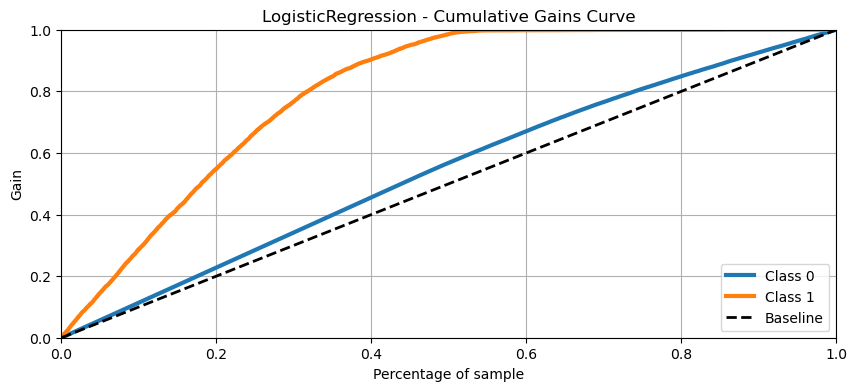

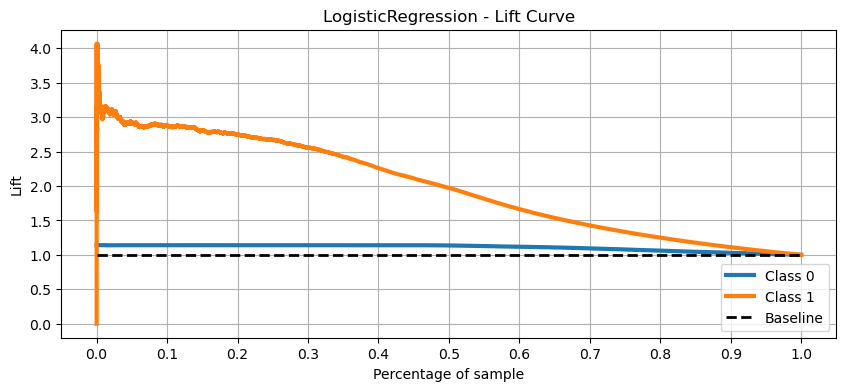

In [136]:
# Cumulative gain plot
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_lr, figsize=(10, 4) );
plt.title('LogisticRegression - Cumulative Gains Curve')
lr_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_lr, ax=ax);
#ax.set_ylim([0, 8.5])
plt.title('LogisticRegression - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])
plt.show()

### 8.1.2. XGBoost

In [137]:
# model definition
model_xgb = xgb.XGBClassifier( n_estimators=10,
                               eta=0.01,
                               max_depth=10,
                               subsample=0.7,
                               eval_metric = 'aucpr' )

# PS: not used "colsample_bytee=0.9" & "use_label_encoder = False"

# model fit
model_xgb.fit( x_train_prep, y_train_prep )

# model predict
yhat_xgb = model_xgb.predict_proba( x_validation_prep)
yhat_xgb_1 = model_xgb.predict( x_validation_prep)

# Metrics
xgb_result = single_validation_metrics( 
                type(model_xgb).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_xgb, yhat_xgb_1 ) 
xgb_result

TOT=50817  TP=4472  FP=11293  FN=1778  TN=33274
TOT=20000  TP=4472  FP=11293  FN=1034  TN=3201
TOT=40000  TP=4472  FP=11293  FN=1770  TN=22465


,Model Name,Accuracy,Precision,Recall,F1,cm.pos,cm.neg,Precision@20k,Recall@20k,F1@20k,cm.pos.20k,cm.neg.20k,Precision@40k,Recall@40k,F1@40k,cm.pos.40k,cm.neg.40k
0,XGBClassifier,74.2783,28.3666,71.552,40.626845,TP=4472 FP=11293,FN=1778 TN=33274 TOT=50817,28.3666,81.2205,42.0479,TP=4472 FP=11293,FN=1034 TN=3201 TOT=20k,28.3666,71.6437,40.6416,TP=4472 FP=11293,FN=1770 TN=22465 TOT=40k


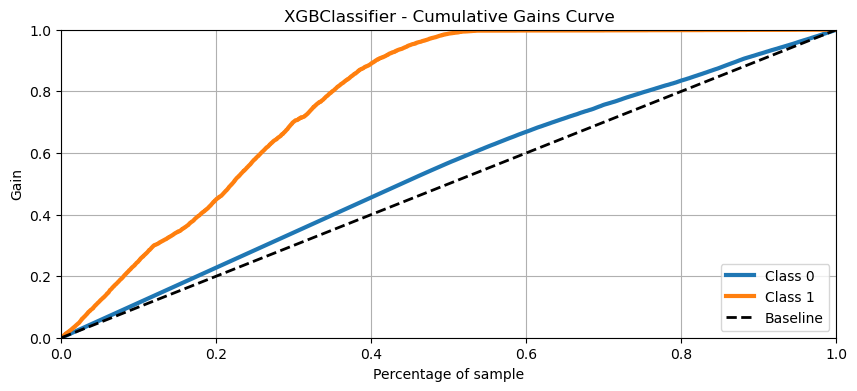

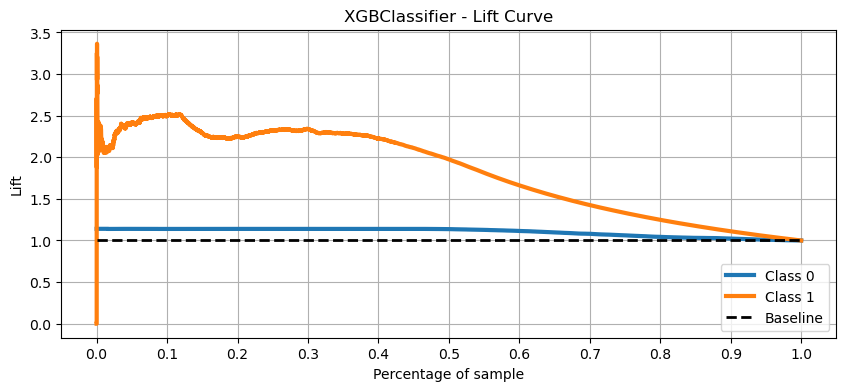

In [138]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_xgb, figsize=(10, 4) );
plt.title('XGBClassifier - Cumulative Gains Curve')
xgb_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_xgb, ax=ax);
#ax.set_ylim([0, 8.5])
plt.title('XGBClassifier - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])  # Exibir ticks principais a cada 0.10
plt.show()

### 8.1.3. KNN

In [139]:
x_train_prep.columns

Index(['age', 'age_rbf_23', 'age_rbf_43', 'annual_premium',
       'annual_premium_f1', 'annual_premium_f2', 'driving_license',
       'gender_Female', 'gender_Male', 'policy_sales_channel',
       'policy_sales_channel_importance', 'previously_insured', 'region_code',
       'vehicle_age_bellow_1_year', 'vehicle_damage', 'vintage'],
      dtype='object')

In [140]:
knn_out = KNN_optimization( 53, 53, in_metric='manhattan' )

53 
k=53  F1=0.4102435977514054 
KNN - best Precision .. k: 53
KNN - best F1 ......... k: 53
KNN - best Recall ..... k: 53


In [141]:
# prediction
yhat_knn = knn_out[0].predict_proba( x_validation_prep )
yhat_knn_1 = knn_out[0].predict( x_validation_prep )

# Metrics
knn_result = single_validation_metrics( 
                type(knn_out[0]).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_knn, yhat_knn_1 ) 
knn_result.T

TOT=50817  TP=3284  FP=6476  FN=2966  TN=38091
TOT=20000  TP=3284  FP=6476  FN=2306  TN=7934
TOT=40000  TP=3284  FP=6476  FN=2958  TN=27282


,0
Model Name,KNeighborsClassifier
Accuracy,81.4196
Precision,33.6475
Recall,52.544
F1,41.02436
cm.pos,TP=3284 FP=6476
cm.neg,FN=2966 TN=38091 TOT=50817
Precision@20k,33.6475
Recall@20k,58.7478
F1@20k,42.7883


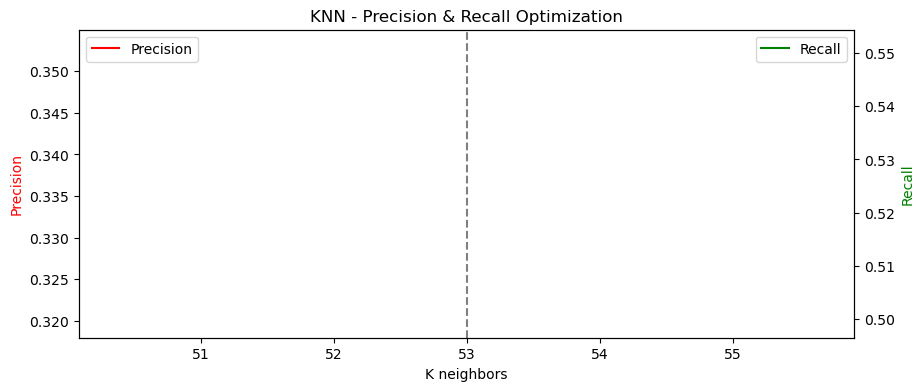

In [142]:
# Plotting  two Y axes
knn_BestClassifier = knn_out[0]
best_k_pr = knn_out[1]
Precision_list = knn_out[3]
Recall_list = knn_out[4]
KK = knn_out[5]

# Plotting  two Y axes
fig, ax1 = plt.subplots(figsize=(10, 4))
plt.title('KNN - Precision & Recall Optimization')
# First Y: precision
ax1.plot( KK, Precision_list,  'r-', label='Precision' )
ax1.set_xlabel('K neighbors')
ax1.set_ylabel('Precision', color='r')
ax1.legend(loc='upper left')
ax1.axvline(x=best_k_pr, color='gray', linestyle='--')
ax1.annotate(f"x = {best_k_pr}", xy=(best_k_pr+6, (min(Precision_list) + max(Precision_list)) / 2), fontsize=8, ha='center')
# Second Y: recall
ax2 = ax1.twinx()
ax2.plot( KK, Recall_list,  'g-', label='Recall')
ax2.set_ylabel('Recall', color='g')
ax2.legend(loc='upper right')
plt.show()

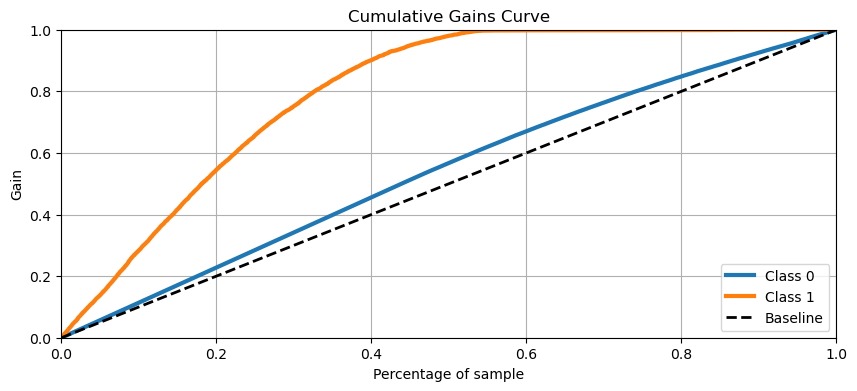

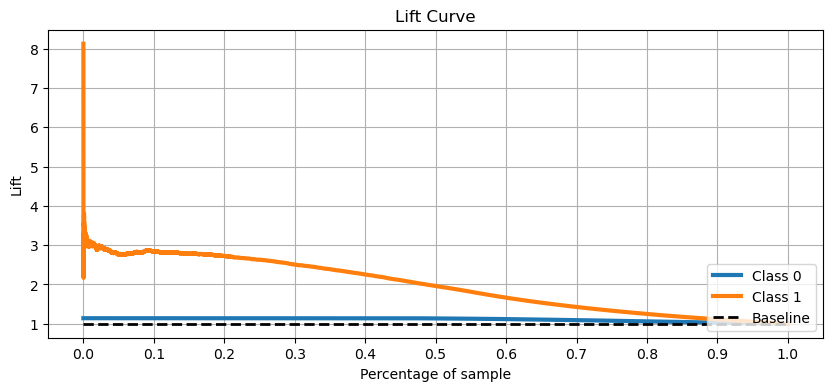

In [143]:
# Metric: cumulative gain
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_knn, figsize=(10, 4) );
knn_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_knn, ax=ax);
#ax.set_ylim([0, 5])
plt.xticks([i/10.0 for i in range(11)])  # Exibir ticks principais a cada 0.10
plt.show()

### 8.1.4. Random Forest

In [144]:
# model definition
rf = en.RandomForestClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
rf.fit( x_train_prep, y_train_prep )

# model predict
yhat_rf = rf.predict_proba( x_validation_prep)
yhat_rf_1 = rf.predict( x_validation_prep )

# Metrics
rf_result = single_validation_metrics( 
                type(rf).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_rf, yhat_rf_1 ) 
rf_result

TOT=50817  TP=626  FP=1199  FN=5624  TN=43368
TOT=20000  TP=626  FP=1199  FN=3195  TN=14980
TOT=40000  TP=626  FP=1199  FN=5236  TN=32939


,Model Name,Accuracy,Precision,Recall,F1,cm.pos,cm.neg,Precision@20k,Recall@20k,F1@20k,cm.pos.20k,cm.neg.20k,Precision@40k,Recall@40k,F1@40k,cm.pos.40k,cm.neg.40k
0,RandomForestClassifier,86.5734,34.3014,10.016,15.504644,TP=626 FP=1199,FN=5624 TN=43368 TOT=50817,34.3014,16.3831,22.175,TP=626 FP=1199,FN=3195 TN=14980 TOT=20k,34.3014,10.6789,16.2872,TP=626 FP=1199,FN=5236 TN=32939 TOT=40k


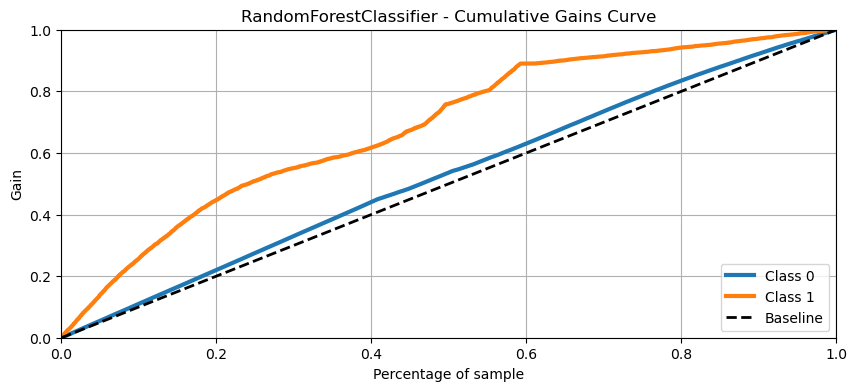

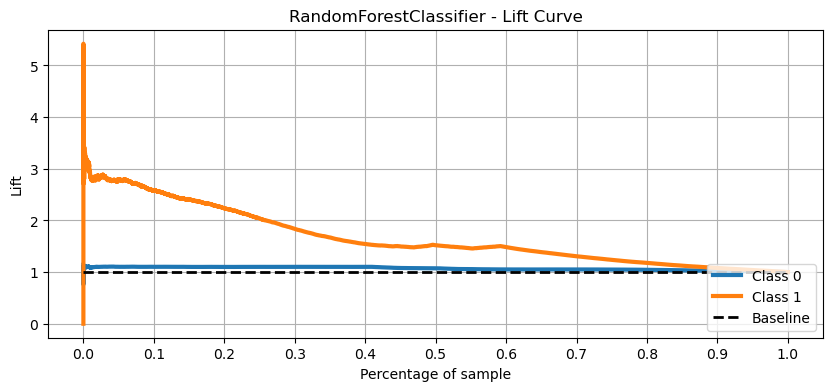

In [145]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_rf, figsize=(10, 4) );
plt.title('RandomForestClassifier - Cumulative Gains Curve')
rf_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_rf, ax=ax);
#ax.set_ylim([0, 4.5])
plt.title('RandomForestClassifier - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])  # Exibir ticks principais a cada 0.10
plt.show()

### 8.1.5. Extra Trees

In [146]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=1000, n_jobs=-1, random_state=42 )

# model fit
et.fit( x_train_prep, y_train_prep )

# model predict
yhat_et = et.predict_proba( x_validation_prep)
yhat_et_1 = et.predict( x_validation_prep )

# Metrics
et_result = single_validation_metrics( 
                type(et).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_et, yhat_et_1 ) 
et_result.T

TOT=50817  TP=885  FP=1686  FN=5365  TN=42881
TOT=20000  TP=885  FP=1686  FN=4601  TN=12828
TOT=40000  TP=885  FP=1686  FN=5357  TN=32072


,0
Model Name,ExtraTreesClassifier
Accuracy,86.1247
Precision,34.4224
Recall,14.16
F1,20.065752
cm.pos,TP=885 FP=1686
cm.neg,FN=5365 TN=42881 TOT=50817
Precision@20k,34.4224
Recall@20k,16.132
F1@20k,21.9685


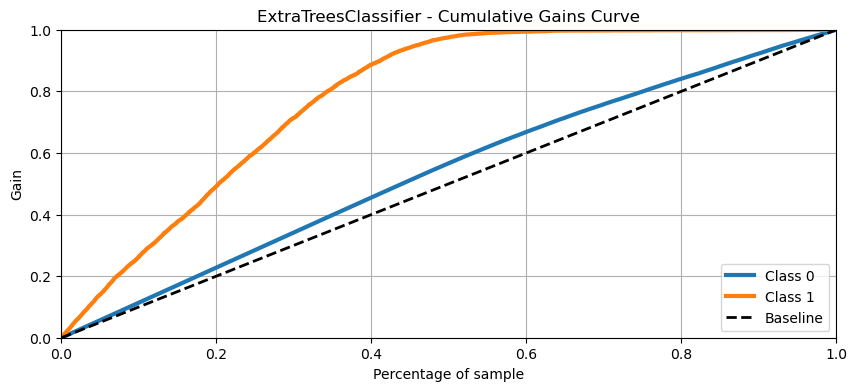

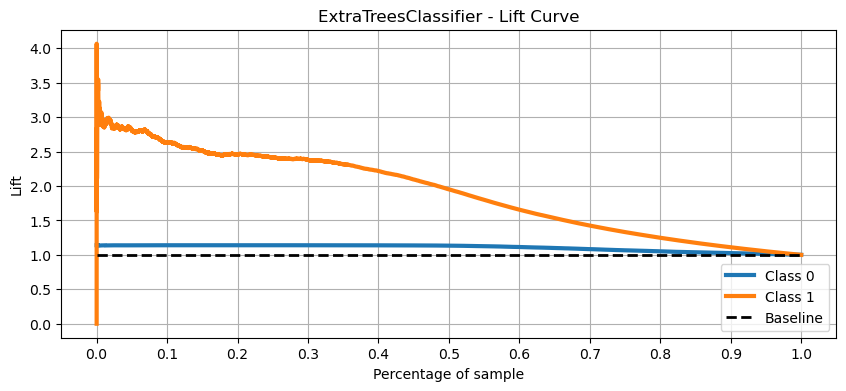

In [147]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_et, figsize=(10, 4) );
plt.title('ExtraTreesClassifier - Cumulative Gains Curve')
et_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_et, ax=ax);
#ax.set_ylim([0, 8.5])
plt.title('ExtraTreesClassifier - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])  # Exibir ticks principais a cada 0.10
plt.show()

### 8.1.6. LightGBM

In [148]:
# model definition
lgb = LGBMClassifier( n_estimators=100, random_state=42, n_jobs=-1, verbose=-1 )

# model fit
lgb.fit( x_train_prep, y_train_prep )

# model predict
yhat_lgb = lgb.predict_proba( x_validation_prep)
yhat_lgb_1 = lgb.predict( x_validation_prep)

# Metrics
lgb_result = single_validation_metrics( 
                type(lgb).__name__, 
                x_validation_prep, y_validation_prep,
                yhat_lgb, yhat_lgb_1 ) 
lgb_result

TOT=50817  TP=857  FP=3142  FN=5393  TN=41425
TOT=20000  TP=857  FP=3142  FN=2743  TN=13258
TOT=40000  TP=857  FP=3142  FN=2800  TN=33201


,Model Name,Accuracy,Precision,Recall,F1,cm.pos,cm.neg,Precision@20k,Recall@20k,F1@20k,cm.pos.20k,cm.neg.20k,Precision@40k,Recall@40k,F1@40k,cm.pos.40k,cm.neg.40k
0,LGBMClassifier,83.2044,21.4304,13.712,16.723583,TP=857 FP=3142,FN=5393 TN=41425 TOT=50817,21.4304,23.8056,22.5556,TP=857 FP=3142,FN=2743 TN=13258 TOT=20k,21.4304,23.4345,22.3877,TP=857 FP=3142,FN=2800 TN=33201 TOT=40k


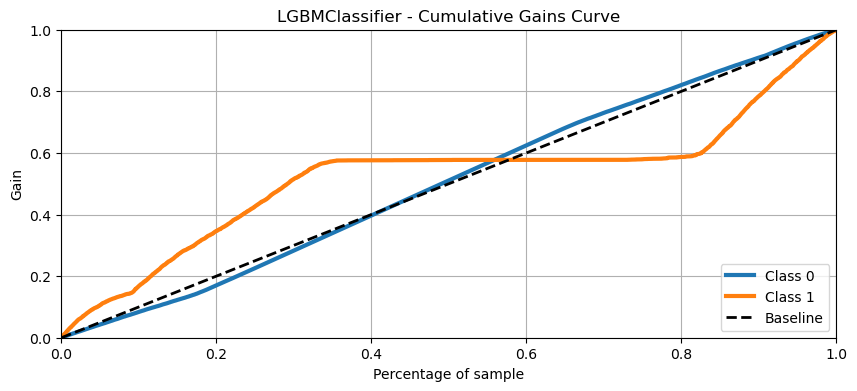

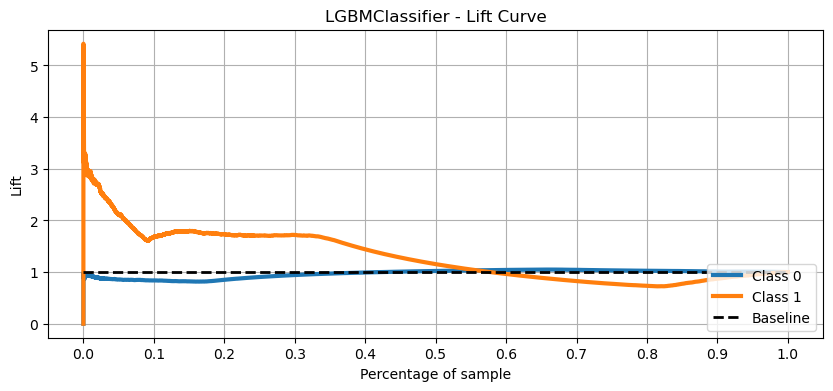

In [149]:
# Cumulative Gain
skplt.metrics.plot_cumulative_gain( y_validation_prep, yhat_lgb, figsize=(10, 4) );
plt.title('LGBMClassifier - Cumulative Gains Curve')
lgbm_line = plt.gca().lines[1].get_data()
#plt.gca().lines.clear()
plt.show()

# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_validation_prep, yhat_lgb, ax=ax);
#ax.set_ylim([0, 3.5])
plt.title('LGBMClassifier - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])  # Exibir ticks principais a cada 0.10
plt.show()

### 8.1.7. Performance

In [150]:
# Single-validation Performance
sgl = pd.concat( [
        knn_result, lr_result, et_result, rf_result, xgb_result, lgb_result
    ] ).round(4).T.reset_index()
sgl.columns = [ 'metrics', 'knn', 'logistic reg.', 'extra trees', 'random forest', 'xgboost', 'LightGBM' ]
# Order columns by one metric
ordering_line = 3  # "Recall" metrics
#ordering_line = 2  # "Precision" metrics
col_metrics = sgl.iloc[:,0]
cols_ordered = sgl.iloc[:,1:].loc[ordering_line].sort_values(ascending=False).index
sgl = pd.concat( [col_metrics, sgl[cols_ordered]], axis=1 )

sgl

,metrics,logistic reg.,xgboost,knn,extra trees,LightGBM,random forest
0,Model Name,LogisticRegression,XGBClassifier,KNeighborsClassifier,ExtraTreesClassifier,LGBMClassifier,RandomForestClassifier
1,Accuracy,69.3331,74.2783,81.4196,86.1247,83.2044,86.5734
2,Precision,27.4672,28.3666,33.6475,34.4224,21.4304,34.3014
3,Recall,91.024,71.552,52.544,14.16,13.712,10.016
4,F1,42.2001,40.6268,41.0244,20.0658,16.7236,15.5046
5,cm.pos,TP=5689 FP=15023,TP=4472 FP=11293,TP=3284 FP=6476,TP=885 FP=1686,TP=857 FP=3142,TP=626 FP=1199
6,cm.neg,FN=561 TN=29544 TOT=50817,FN=1778 TN=33274 TOT=50817,FN=2966 TN=38091 TOT=50817,FN=5365 TN=42881 TOT=50817,FN=5393 TN=41425 TOT=50817,FN=5624 TN=43368 TOT=50817
7,Precision@20k,28.065,28.3666,33.6475,34.4224,21.4304,34.3014
8,Recall@20k,100.0,81.2205,58.7478,16.132,23.8056,16.3831
9,F1@20k,43.8293,42.0479,42.7883,21.9685,22.5556,22.175


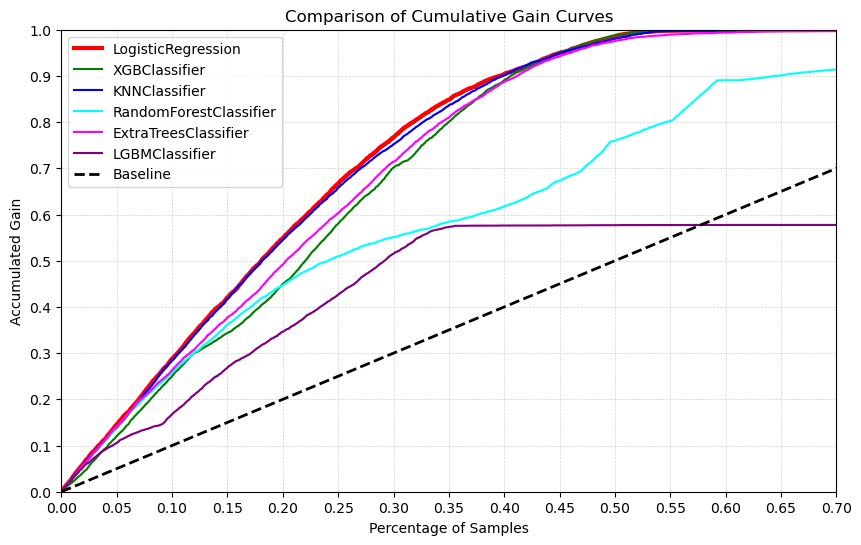

In [199]:
plt.figure(figsize=(10, 6))
plt.plot(lr_line[0], lr_line[1], label='LogisticRegression', color='red', lw=3)
plt.plot(xgb_line[0], xgb_line[1], label='XGBClassifier', color='green')
plt.plot(knn_line[0], knn_line[1], label='KNNClassifier', color='blue')
plt.plot(rf_line[0], rf_line[1], label='RandomForestClassifier', color='cyan')
plt.plot(et_line[0], et_line[1], label='ExtraTreesClassifier', color='magenta')
plt.plot(lgbm_line[0], lgbm_line[1], label='LGBMClassifier', color='purple')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Baseline', lw=2)

# Adicionar labels etc...
plt.title('Comparison of Cumulative Gain Curves')
plt.xlabel('Percentage of Samples')
plt.ylabel('Accumulated Gain')
plt.grid(True, which='both', axis='both', color='lightgray', linestyle='--', linewidth=0.5)
plt.xlim([0.0, 0.7])
plt.ylim([0.0, 1.0])
plt.xticks([i/20.0 for i in range(15)])
plt.yticks([i/10.0 for i in range(11)])
plt.legend()

# Mostrar o gráfico
plt.show()


## 8.2. Cross-Validation

### 8.2.1. Logistic Regression

In [152]:
lr_cv_result = cross_validation( lr_model, 
                                 x_train, y_train, 
                                 5, 
                                 data_preparation_models, True )

lr_cv_result.T

1 TOT=20000  TP=4512  FP=12130  FN=332  TN=3026
TOT=40000  TP=4512  FP=12130  FN=418  TN=22940
2 TOT=20000  TP=4453  FP=12014  FN=383  TN=3150
TOT=40000  TP=4453  FP=12014  FN=476  TN=23057
3 TOT=20000  TP=4521  FP=12256  FN=300  TN=2923
TOT=40000  TP=4521  FP=12256  FN=409  TN=22814
4 TOT=20000  TP=4461  FP=12027  FN=367  TN=3145
TOT=40000  TP=4461  FP=12027  FN=470  TN=23042
5 TOT=20000  TP=4469  FP=12114  FN=362  TN=3055
TOT=40000  TP=4469  FP=12114  FN=462  TN=22955


,0
Model Name,LogisticRegression
Balanced Accuracy Mean,78.346759
Precision Mean,27.0214
Precision STD,0.06
Recall Mean,90.92977
Recall STD,0.57
F1 Mean,41.66181
F1 STD,0.09
cm.pos,TP=4483 FP=12108
cm.neg,FN=447 TN=23258 TOT=201485


### 8.2.2. XGBoost

In [153]:
xgb_cv_result = cross_validation( model_xgb, 
                                  x_train, y_train, 
                                  5, 
                                  data_preparation_models, True )

xgb_cv_result

1 TOT=20000  TP=3498  FP=8829  FN=1327  TN=6346
TOT=40000  TP=3498  FP=8829  FN=1432  TN=26241
2 TOT=20000  TP=3603  FP=9212  FN=1246  TN=5939
TOT=40000  TP=3603  FP=9212  FN=1327  TN=25858
3 TOT=20000  TP=3538  FP=9155  FN=1273  TN=6034
TOT=40000  TP=3538  FP=9155  FN=1392  TN=25915
4 TOT=20000  TP=3630  FP=9234  FN=1203  TN=5933
TOT=40000  TP=3630  FP=9234  FN=1301  TN=25835
5 TOT=20000  TP=3617  FP=9247  FN=1238  TN=5898
TOT=40000  TP=3617  FP=9247  FN=1314  TN=25822


,Model Name,Balanced Accuracy Mean,Precision Mean,Precision STD,Recall Mean,Recall STD,F1 Mean,F1 STD,cm.pos,cm.neg,...,cm.pos.20k,cm.neg.20k,Precision@40k Mean,Precision@40k STD,Recall@40k Mean,Recall@40k STD,F1@40k Mean,F1@40k STD,cm.pos.40k,cm.neg.40k
0,XGBClassifier,73.361643,28.14027,0.16,72.55388,1.02,40.55012,0.22,TP=3577 FP=9135,FN=1353 TN=26231 TOT=201485,...,TP=3577 FP=9135,FN=1257 TN=6030 TOT=20k,28.14027,0.16,72.55388,1.02,40.55012,0.22,TP=3577 FP=9135,FN=1353 TN=25934 TOT=40k


### 8.2.3. KNN

In [154]:
knn_cv_result = cross_validation( knn_BestClassifier, 
                                  x_train, y_train, 
                                  5, 
                                  data_preparation_models, True )

knn_cv_result.T

1 TOT=20000  TP=2673  FP=5288  FN=2150  TN=9889
TOT=40000  TP=2673  FP=5288  FN=2257  TN=29782
2 TOT=20000  TP=2598  FP=5110  FN=2219  TN=10073
TOT=40000  TP=2598  FP=5110  FN=2331  TN=29961
3 TOT=20000  TP=2557  FP=5195  FN=2260  TN=9988
TOT=40000  TP=2557  FP=5195  FN=2372  TN=29876
4 TOT=20000  TP=2641  FP=5259  FN=2176  TN=9924
TOT=40000  TP=2641  FP=5259  FN=2290  TN=29810
5 TOT=20000  TP=2583  FP=5263  FN=2224  TN=9930
TOT=40000  TP=2583  FP=5263  FN=2348  TN=29806


,0
Model Name,KNeighborsClassifier
Balanced Accuracy Mean,69.08841
Precision Mean,33.32361
Precision STD,0.32
Recall Mean,52.94499
Recall STD,0.84
F1 Mean,40.90154
F1 STD,0.45
cm.pos,TP=2610 FP=5223
cm.neg,FN=2320 TN=30143 TOT=201485


In [155]:
knn_cv_result.T

,0
Model Name,KNeighborsClassifier
Balanced Accuracy Mean,69.08841
Precision Mean,33.32361
Precision STD,0.32
Recall Mean,52.94499
Recall STD,0.84
F1 Mean,40.90154
F1 STD,0.45
cm.pos,TP=2610 FP=5223
cm.neg,FN=2320 TN=30143 TOT=201485


### 8.2.4. Random Forest

In [156]:
rf_cv_result = cross_validation( rf, 
                                 x_train, y_train, 
                                 5, 
                                 data_preparation_models, True )

rf_cv_result.T

1 TOT=20000  TP=518  FP=968  FN=2977  TN=15537
TOT=40000  TP=518  FP=968  FN=4396  TN=34118
2 TOT=20000  TP=507  FP=969  FN=3055  TN=15469
TOT=40000  TP=507  FP=969  FN=4402  TN=34122
3 TOT=20000  TP=500  FP=958  FN=2958  TN=15584
TOT=40000  TP=500  FP=958  FN=4408  TN=34134
4 TOT=20000  TP=505  FP=916  FN=3107  TN=15472
TOT=40000  TP=505  FP=916  FN=4409  TN=34170
5 TOT=20000  TP=521  FP=998  FN=3079  TN=15402
TOT=40000  TP=521  FP=998  FN=4401  TN=34080


,0
Model Name,RandomForestClassifier
Balanced Accuracy Mean,53.814263
Precision Mean,34.66781
Precision STD,0.48
Recall Mean,10.34804
Recall STD,0.16
F1 Mean,15.93719
F1 STD,0.19
cm.pos,TP=510 FP=961
cm.neg,FN=4420 TN=34404 TOT=201485


### 8.2.5. Extra Trees

In [157]:
et_cv_result = cross_validation( et, 
                                 x_train, y_train, 
                                 5, 
                                 data_preparation_models, True )

et_cv_result.T

1 TOT=20000  TP=737  FP=1406  FN=4064  TN=13793
TOT=40000  TP=737  FP=1406  FN=4193  TN=33664
2 TOT=20000  TP=688  FP=1394  FN=4107  TN=13811
TOT=40000  TP=688  FP=1394  FN=4241  TN=33677
3 TOT=20000  TP=670  FP=1405  FN=4102  TN=13823
TOT=40000  TP=670  FP=1405  FN=4260  TN=33665
4 TOT=20000  TP=714  FP=1361  FN=4080  TN=13845
TOT=40000  TP=714  FP=1361  FN=4217  TN=33708
5 TOT=20000  TP=683  FP=1390  FN=4106  TN=13821
TOT=40000  TP=683  FP=1390  FN=4248  TN=33679


,0
Model Name,ExtraTreesClassifier
Balanced Accuracy Mean,55.115762
Precision Mean,33.41648
Precision STD,0.84
Recall Mean,14.16518
Recall STD,0.49
F1 Mean,19.89564
F1 STD,0.62
cm.pos,TP=698 FP=1391
cm.neg,FN=4232 TN=33975 TOT=201485


### 8.2.6. LightGBM

In [158]:
lgb_cv_result = cross_validation( lgb, 
                                 x_train, y_train, 
                                 5, 
                                 data_preparation_models, True )

lgb_cv_result.T

1 TOT=20000  TP=1217  FP=3742  FN=1594  TN=13447
TOT=40000  TP=1217  FP=3742  FN=3608  TN=31433
2 TOT=20000  TP=1040  FP=3326  FN=1796  TN=13838
TOT=40000  TP=1040  FP=3326  FN=3806  TN=31828
3 TOT=20000  TP=967  FP=3135  FN=1899  TN=13999
TOT=40000  TP=967  FP=3135  FN=3909  TN=31989
4 TOT=20000  TP=666  FP=2021  FN=2205  TN=15108
TOT=40000  TP=666  FP=2021  FN=4224  TN=33089
5 TOT=20000  TP=913  FP=3004  FN=1934  TN=14149
TOT=40000  TP=913  FP=3004  FN=3923  TN=32160


,0
Model Name,LGBMClassifier
Balanced Accuracy Mean,55.435995
Precision Mean,24.00604
Precision STD,0.57
Recall Mean,19.48349
Recall STD,3.64
F1 Mean,21.3047
F1 STD,2.33
cm.pos,TP=960 FP=3045
cm.neg,FN=3969 TN=32321 TOT=201485


### 8.2.7. Performance Table

In [159]:
# Cross-validation Performance
cvp = pd.concat( [
        knn_cv_result, lr_cv_result, et_cv_result, rf_cv_result, xgb_cv_result, lgb_cv_result
    ] ).round(8).T.reset_index()
cvp.columns = [ 'metrics', 'knn', 'logistic reg.', 'extra trees', 'random forest', 'xgboost', 'LightGBM' ]
# Order columns by one metric
ordering_line = 4  # "Recall Mean" metrics
#ordering_line = 2  # "Precision Mean" metrics
col_metrics = cvp.iloc[:,0]
cols_ordered = cvp.iloc[:,1:].loc[ordering_line].sort_values(ascending=False).index
cvp = pd.concat( [col_metrics, cvp[cols_ordered]], axis=1 )

cvp

,metrics,logistic reg.,xgboost,knn,LightGBM,extra trees,random forest
0,Model Name,LogisticRegression,XGBClassifier,KNeighborsClassifier,LGBMClassifier,ExtraTreesClassifier,RandomForestClassifier
1,Balanced Accuracy Mean,78.346759,73.361643,69.08841,55.435995,55.115762,53.814263
2,Precision Mean,27.0214,28.14027,33.32361,24.00604,33.41648,34.66781
3,Precision STD,0.06,0.16,0.32,0.57,0.84,0.48
4,Recall Mean,90.92977,72.55388,52.94499,19.48349,14.16518,10.34804
5,Recall STD,0.57,1.02,0.84,3.64,0.49,0.16
6,F1 Mean,41.66181,40.55012,40.90154,21.3047,19.89564,15.93719
7,F1 STD,0.09,0.22,0.45,2.33,0.62,0.19
8,cm.pos,TP=4483 FP=12108,TP=3577 FP=9135,TP=2610 FP=5223,TP=960 FP=3045,TP=698 FP=1391,TP=510 FP=961
9,cm.neg,FN=447 TN=23258 TOT=201485,FN=1353 TN=26231 TOT=201485,FN=2320 TN=30143 TOT=201485,FN=3969 TN=32321 TOT=201485,FN=4232 TN=33975 TOT=201485,FN=4420 TN=34404 TOT=201485


# 9. HYPERPARAMETER FINE TUNING

## 9.1. KNN Fine Tuning

In [160]:
# There was a time when KNN sounded like the best model...
#
# Test the following hyperparameters for "KNeighborsClassifier":
#  - weights: can be [ 'uniform', 'distance' ]
#  - metric: can be [ 'minkowski', 'euclidean', 'manhattan', 'chebyshev', 'mahalanobis' ]
#  - in case of metric='minkowski', make p = [ 3, 4, ... ]

wgt   = [ 'distance' ]
metr  = [ 'minkowski', 'euclidean', 'manhattan', 'chebyshev' ]
metr  = [  ] # debug: don't do a thing
hyp_p = [ 3, 4, 5 ]

for wg in wgt:
    for mtr in metr:
        if mtr == 'minkowski':
            p_vals = hyp_p
        else:
            p_vals = [ 1 ]
        for pv in p_vals:
            print('\n====================================================')
            print(f"Params:  weight={wg}   metric={mtr}   p={pv}")
            print('====================================================')
            knn_classifier = KNeighborsClassifier( 
                                n_neighbors = 55,
                                weights = wg,
                                metric = mtr,
                                p = pv
                            )
            result = cross_validation( knn_classifier, 
                                    x_train, y_train, 
                                    3, 
                                    data_preparation_models, True )
            print(result.T)


## 9.2. Winner Model Fine Tuning

In [161]:
# Define Optuna Objective Function
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

def objective_rf( trial ):

    lr_model = lm.LogisticRegression(
                class_weight='balanced',
                #solver=trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga']),
                solver='lbfgs',
                #penalty=trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet', None]),
                penalty='l2',
                #l1_ratio=trial.suggest_float('l1_ratio', 0, 1), # for "elasticnet" only
                #C=0.1,
                C=trial.suggest_float('C', 3.91, 3.92, log=True),
                max_iter=200
                #max_iter=trial.suggest_int("max_iter", 50, 500, step=50)
    )

    result = cross_validation( lr_model, 
                               x_train, y_train, 
                               3, 
                               data_preparation_models, True )
    
    #print(result.T)

    return result['F1@20k Mean'][0]

#......... Results:
# BEST F1=45.28445 - for: solver='lbfgs',     penalty='l2',         max_iter=200, C=3.9152224535720896
# BEST F1=45.27047 - for: solver='liblinear', penalty=None,         max_iter=200, C=7.893619910985317
# BEST F1=45.27046 - for: solver='liblinear', penalty='l1',         max_iter=200, C=2.6583106154783627
# BEST F1=45.27046 - for: solver='saga',      penalty='l2',         max_iter=200, C=3.474893237951662
# BEST F1=45.27046 - for: solver='saga',      penalty=None,         max_iter=200, C=3.4361675051532212
# BEST F1=45.27045 - for: solver='saga',      penalty='elasticnet', max_iter=200, C=1.7286427795493322, l1_ratio=0.719133171278076
# BEST F1=45.27045 - for: solver='saga',      penalty='l1',         max_iter=200, C=6.325433111540967
# BEST F1=45.26847 - for: solver='liblinear', penalty='l2',         max_iter=200, C=5.530577352171207

# BEST F1=45.06133 - for: solver='lbfgs',     penalty=None,         max_iter=200, C=8.933234431998905



In [162]:
# 
study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=1)

print('Best hyperparameters:', study.best_params)
print('Best result.........:', study.best_value)


[I 2024-09-12 08:06:47,976] A new study created in memory with name: no-name-e549c832-5f86-4701-af03-a0f8188f6982


1 TOT=20000  TP=6246  FP=13754  FN=0  TN=0
TOT=40000  TP=7476  FP=20173  FN=725  TN=11626
2 TOT=20000  TP=6255  FP=13745  FN=0  TN=0
TOT=40000  TP=7476  FP=20047  FN=729  TN=11748
3 

[I 2024-09-12 08:10:02,791] Trial 0 finished with value: 47.512389999999996 and parameters: {'C': 3.9179200277419337}. Best is trial 0 with value: 47.512389999999996.


TOT=20000  TP=6194  FP=13806  FN=0  TN=0
TOT=40000  TP=7401  FP=20023  FN=803  TN=11773
Best hyperparameters: {'C': 3.9179200277419337}
Best result.........: 47.512389999999996


In [163]:
fig = optuna.visualization.plot_slice(study)
fig.update_layout(template='plotly_dark', title='<b>Slice Plot', title_x=0.2)
fig.show()

## 9.3. Winner Model - test dataset

- The idea is: train the winner model with train+val dataset, then evaluate using test dataset

In [164]:
# Model defined: let's train it with both TRAIN+VAL dataframes & apply to TEST dataframe
final_model = lm.LogisticRegression(
                class_weight='balanced',
                solver='lbfgs',
                penalty='l2',
                C=3.9152224535720896,
                max_iter=200
)

In [165]:
# Prepare dataframe (as in section 6.2)

# Delete all rows in 'train' where 'annual_premium_f3' <> 0
df_trval = x_train_val.copy()
df_trval['response'] = y_train_val
df_trval = df_trval[ (df_trval['annual_premium_f3'] == 0) ]
x_train_final = df_trval.drop( 'response', axis=1 )
y_train_final = df_trval['response'].copy()

# Delete 'annual_premium_f3' column
x_train_final = x_train_final.drop( 'annual_premium_f3', axis=1 )
x_test = x_test.drop( 'annual_premium_f3', axis=1 )

# Adjust train data
x_train_val_prep = data_preparation_models.DataFitting(x_train_final, y_train_final)
y_train_val_prep = y_train_final
# Resampling: Smote+Tomek
x_train_val_prep, y_train_val_prep = SMOTETomek(random_state=42).fit_resample(x_train_val_prep, y_train_val_prep)

# apply changes to test data
x_test_prep = data_preparation_models.DataTransforming(x_test)
x_test_prep = x_test_prep.fillna(0)    # fillna
y_test_prep = y_test

( x_train_val_prep.shape, y_train_val_prep.shape, x_test_prep.shape, y_test_prep.shape )

((400718, 19), (400718,), (127024, 19), (127024,))

In [166]:
# train+val model
x_train_val_prep = x_train_val_prep[ cols_selected_boruta ]
x_test_prep = x_test_prep[ cols_selected_boruta ]
final_model.fit( x_train_val_prep, y_train_val_prep )

# model prediction
yhat_final_model = final_model.predict_proba( x_test_prep )
yhat_final_model_1 = final_model.predict( x_test_prep )

In [167]:
# Metrics
final_result = single_validation_metrics( 
                type(final_model).__name__, 
                x_test_prep, y_test_prep,
                yhat_final_model, yhat_final_model_1 ) 
final_result.T

TOT=127024  TP=14212  FP=37875  FN=1316  TN=73621
TOT=20000  TP=6839  FP=13161  FN=0  TN=0
TOT=40000  TP=12301  FP=27699  FN=0  TN=0


,0
Model Name,LogisticRegression
Accuracy,69.1468
Precision,27.2851
Recall,91.525
F1,42.038009
cm.pos,TP=14212 FP=37875
cm.neg,FN=1316 TN=73621 TOT=127024
Precision@20k,34.195
Recall@20k,100.0
F1@20k,50.9632


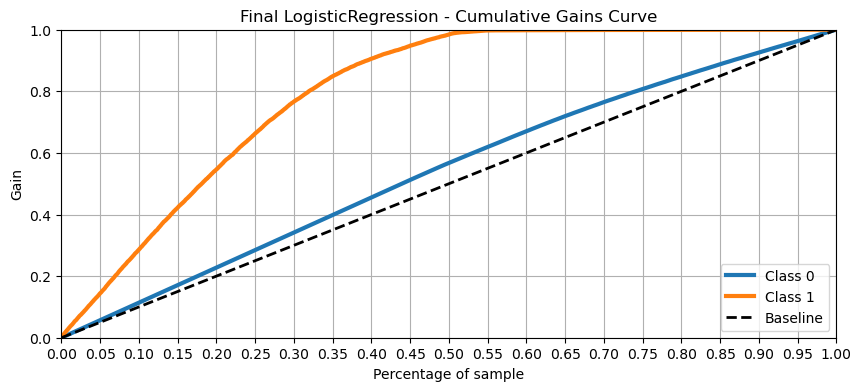

In [168]:
# Cumulative gain plot
skplt.metrics.plot_cumulative_gain( y_test_prep, yhat_final_model, figsize=(10, 4) );
plt.title('Final LogisticRegression - Cumulative Gains Curve')
plt.xticks([i/20.0 for i in range(21)])
plt.show()

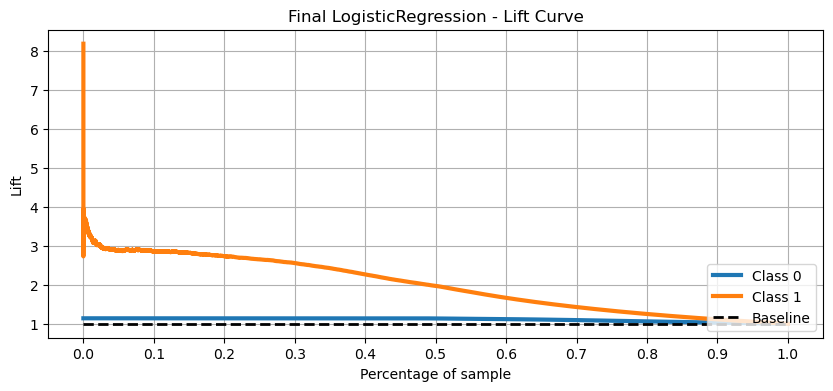

In [169]:
# Lift curve
fig, ax = plt.subplots(figsize=(10, 4))
skplt.metrics.plot_lift_curve(y_test_prep, yhat_final_model, ax=ax);
#ax.set_ylim([0, 8.5])
plt.title('Final LogisticRegression - Lift Curve')
plt.xticks([i/10.0 for i in range(11)])
plt.show()

# 10. PERFORMANCE EVALUATION

## 10.1. Prepare data

In [170]:
df10 = x_test_prep.copy()
df10['response'] = y_test_prep
df10['prediction'] = yhat_final_model_1
df10['predict_proba'] = yhat_final_model[:, 1].tolist()
df10['annual_premium_contracted'] = x_test['annual_premium']
df10['annual_premium_contracted'] = ( df10
            .apply( lambda x: x['response'] * x['annual_premium_contracted'], axis=1 ) )
df10.shape

(127024, 20)

## 10.2. Business Performance

- TASK: compare results to the "status quo"
- Status quo: randomly chosen 20k (& 40k) potential clients (probably: 12,26%)
- ML performance: from the first 20k (& 40k) ordered potential clients

In [171]:
total_population = df10.shape[0]
total_pop_interested = np.sum( df10['response'] )
total_revenue = np.sum( df10['annual_premium_contracted'] )
perc = 100 * total_pop_interested / total_population
print( f"Total population tested...........: {total_population}" )
print( f"Total popupation interested.......: {total_pop_interested}  ({perc:.2f}%)" )
print( f"Total revenue (health-insurance)..: {total_revenue:15,.2f}" )

Total population tested...........: 127024
Total popupation interested.......: 15528  (12.22%)
Total revenue (health-insurance)..:  489,423,406.00


### business performance at 20k

In [172]:
# (1) STATUS-QUO: randomly choosing 20.000 potential clients to receive an offer
#     - Calculus using average values (see sections 1.3.2 & 1.3.4):
#     - Considering (I) premium per contract = average(annual_premium) . . . . = $30.564,39
#     -             (II) percentage of acceptance (in theory) = 46.710/381.109 = 12,26%
#     - Revenue @20k = 12,26% x 20.000 x $30.564,39 =  $74.943.884
#     - Revenue @40k = 12,26% x 40.000 x $30.564,39 = $149.887.769

df_statusquo = df10.sample(20000)
num_of_success_statusquo = np.round( np.sum(df_statusquo['response']), 2 )
# Percentage of aceptance
val = 100 * num_of_success_statusquo / df_statusquo.shape[0]
num_of_success_statusquo_p = np.round( val, 2 )
# Premium values (considering "Annual_Premium" as proxy)
total_revenue_statusquo = np.sum(df_statusquo['annual_premium_contracted'])

In [173]:
# (2) Average Machine Learning Model Results (in theory / in average):
#     - Considering model performance = Precision * Recall = 0,2956 * 1
#     - Total revenue @20k = 0,2983 x 20.000 x $30.564,39 = $180.696.674
#     - Revenue raised in: $105.752.790 (+141%)

df_ml_20k_case = df10.sort_values('predict_proba', ascending=False)
df_ml_20k_case = df_ml_20k_case.head(20000)
num_of_success_ml = np.round( np.sum(df_ml_20k_case['response']), 2 )

# Percentage of aceptance
val = 100 * num_of_success_ml / df_ml_20k_case.shape[0]
num_of_success_ml_p = np.round( val, 2 )
# Premium values (considering "Annual_Premium" as proxy)
total_revenue_ml = np.sum(df_ml_20k_case['annual_premium_contracted'])


In [174]:
print( "STATUS-QUO 20k" )
print( f"N# of contracts sold: {num_of_success_statusquo} ({num_of_success_statusquo_p}%) of 20k" )
print( "Total Revenue: ${:15,.2f}".format(total_revenue_statusquo) )

print( "\nML 20k RESULTS" )
print( f"N# of contracts sold: {num_of_success_ml} ({num_of_success_ml_p}%) of 20k" )
dif = num_of_success_ml - num_of_success_statusquo
difp = 100 * dif / num_of_success_statusquo
print( "Gain: {}  ({:.1f}%)".format(dif, difp) )
print( "Total Revenue: ${:15,.2f}".format(total_revenue_ml) )
dif = total_revenue_ml - total_revenue_statusquo
difp = 100 * dif / total_revenue_statusquo
print( "Revenue Gain: {:15,.2f}  ({:.1f}%)".format(dif, difp) )

STATUS-QUO 20k
N# of contracts sold: 2466 (12.33%) of 20k
Total Revenue: $  79,468,853.00

ML 20k RESULTS
N# of contracts sold: 6839 (34.2%) of 20k
Gain: 4373  (177.3%)
Total Revenue: $ 233,784,442.00
Revenue Gain:  154,315,589.00  (194.2%)


### business performance at 40k

In [175]:
# (1) STATUS-QUO: randomly choosing 40.000 potential clients to receive an offer
#     - Revenue @40k = 12,26% x 40.000 x $30.564,39 = $149.887.769

df_statusquo = df10.sample(40000)
num_of_success_statusquo = np.round( np.sum(df_statusquo['response']), 2 )
# Percentage of aceptance
val = 100 * num_of_success_statusquo / df_statusquo.shape[0]
num_of_success_statusquo_p = np.round( val, 2 )
# Premium values (considering "Annual_Premium" as proxy)
total_revenue_statusquo = np.sum(df_statusquo['annual_premium_contracted'])

In [176]:
# (2) Average Machine Learning Model Results (in theory / in average):
#     - Considering model performance = Precision * Recall = 0,2899 * 1
#     - Total revenue @40k = 0,2899 x 40.000 x $30.564,39 = $354.424.666
#     - Revenue raised in: $204.536.897 (+136%)

df_ml_40k_case = df10.sort_values('predict_proba', ascending=False)
df_ml_40k_case = df_ml_40k_case.head(40000)
num_of_success_ml = np.round( np.sum(df_ml_40k_case['response']), 2 )

# Percentage of aceptance
val = 100 * num_of_success_ml / df_ml_40k_case.shape[0]
num_of_success_ml_p = np.round( val, 2 )
# Premium values (considering "Annual_Premium" as proxy)
total_revenue_ml = np.sum(df_ml_40k_case['annual_premium_contracted'])

In [177]:
print( "STATUS-QUO 40k" )
print( f"N# of contracts sold: {num_of_success_statusquo} ({num_of_success_statusquo_p}%) of 40k" )
print( "Total Revenue: ${:15,.2f}".format(total_revenue_statusquo) )

print( "\nML 40k RESULTS" )
print( f"N# of contracts sold: {num_of_success_ml} ({num_of_success_ml_p}%) of 40k" )
dif = num_of_success_ml - num_of_success_statusquo
difp = 100 * dif / num_of_success_statusquo
print( "Gain: {}  ({:.1f}%)".format(dif, difp) )
print( "Total Revenue: ${:15,.2f}".format(total_revenue_ml) )
dif = total_revenue_ml - total_revenue_statusquo
difp = 100 * dif / total_revenue_statusquo
print( "Revenue Gain: {:15,.2f}  ({:.1f}%)".format(dif, difp) )

STATUS-QUO 40k
N# of contracts sold: 4839 (12.1%) of 40k
Total Revenue: $ 151,442,035.00

ML 40k RESULTS
N# of contracts sold: 12301 (30.75%) of 40k
Gain: 7462  (154.2%)
Total Revenue: $ 396,497,210.00
Revenue Gain:  245,055,175.00  (161.8%)


### 80% business performance

In [178]:
# Order by predict_proba
y_probs_class_1 = yhat_final_model[:, 1]
order = np.argsort(y_probs_class_1)[::-1]
y_true_sorted = np.array(y_test_prep)[order]

# Compute cumulative gain
cumulative_true_positives = np.cumsum(y_true_sorted == 1)
percentages = np.arange(1, len(y_test_prep) + 1) / len(y_test_prep)
gains_class_1 = cumulative_true_positives / cumulative_true_positives[-1]

# cummulative gain of 80%
index_class_1 = np.where(gains_class_1 >= 0.8)[0][0]
percentage_at_gain_1 = percentages[index_class_1]
total_points_to_test = 127024 * percentage_at_gain_1

# print...
print("To reach 80% of cummulative gain:")
print(f"Samples needed: {total_points_to_test:7,.0f} ({percentage_at_gain_1*100:.2f}%)")


To reach 80% of cummulative gain:
Samples needed:  40,530 (31.91%)


### Plotting results

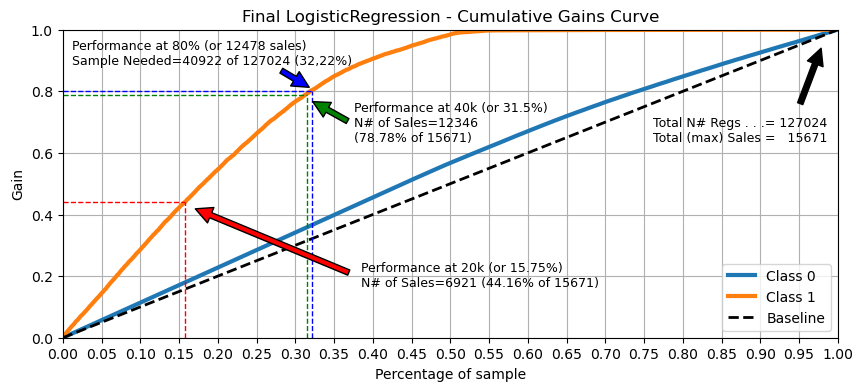

In [179]:
# Cumulative gain plot
skplt.metrics.plot_cumulative_gain( y_test_prep, yhat_final_model, figsize=(10, 4) );
plt.title('Final LogisticRegression - Cumulative Gains Curve')
plt.xticks([i/20.0 for i in range(21)])

plt.annotate( 'Total N# Regs . . .= 127024\nTotal (max) Sales =   15671', 
             xy=(470,180), fontsize=9, xycoords='figure points' );
plt.annotate( '', xy=(0.98, 0.95), xycoords='axes fraction', 
              xytext=(0.95, 0.75), textcoords='axes fraction', 
              arrowprops=dict(facecolor='black', shrink=0.05));
# 20k-case: eixo.x: 20k/127k = 15,745%  -  eixo.y: 6921/15671 = 0,4416
plt.axhline( 0.4416, 0, 0.15745, color='red', ls='--', lw=1 )
plt.axvline( 0.15745, 0, 0.4416, color='red', ls='--', lw=1 )
plt.annotate( 'Performance at 20k (or 15.75%)\nN# of Sales=6921 (44.16% of 15671)', 
             xy=(260,75), fontsize=9, xycoords='figure points' );
plt.annotate( '', xy=(0.16, 0.43), xycoords='axes fraction', 
              xytext=(0.38, 0.20), textcoords='axes fraction', 
              arrowprops=dict(facecolor='red', shrink=0.05));
# 40k-case: eixo.x: 40k/127k = 31,490%  -  eixo.y: 12346/15671 = 0,7878
plt.axhline( 0.7878, 0, 0.3149, color='green', ls='--', lw=1 )
plt.axvline( 0.3149, 0, 0.7878, color='green', ls='--', lw=1 )
plt.annotate( 'Performance at 40k (or 31.5%)\nN# of Sales=12346\n(78.78% of 15671)', 
             xy=(255,180), fontsize=9, xycoords='figure points' );
plt.annotate( '', xy=(0.32, 0.77), xycoords='axes fraction', 
              xytext=(0.37, 0.70), textcoords='axes fraction', 
              arrowprops=dict(facecolor='green', shrink=0.05));
# 80% case: eixo.x: 0,3222  -  eixo.y: 0,80
plt.axhline( 0.8, 0, 0.3222, color='blue', ls='--', lw=1 )
plt.axvline( 0.3222, 0, 0.8, color='blue', ls='--', lw=1 )
plt.annotate( 'Performance at 80% (or 12478 sales)\nSample Needed=40922 of 127024 (32,22%)', 
             xy=(52,235), fontsize=9, xycoords='figure points' );
plt.annotate( '', xy=(0.32, 0.81), xycoords='axes fraction', 
              xytext=(0.28, 0.87), textcoords='axes fraction', 
              arrowprops=dict(facecolor='blue', shrink=0.05));
plt.show()

# 11. DEPLOY TO PRODUCTION

## 11.1. Final Model (train+val+test)

- The idea is: train the winner model in train+val+test dataset, then deploy it.

In [180]:
# Using dataframe "df5" (as in section 6.2)
# ...where: df5 = train+validation+test
df_final = df5[ (df5['annual_premium_f3'] == 0) ]

x_final = df_final.drop( ['response', 'annual_premium_f3'], axis=1 )
y_final = df_final['response'].copy()

# Adjust train data
x_final_prep = data_preparation_models.DataFitting(x_final, y_final) # scaling variables
y_final_prep = y_final
# Resampling: Smote+Tomek
x_final_prep, y_final_prep = SMOTETomek(random_state=42).fit_resample(x_final_prep, y_final_prep)

# train model
x_final_prep = x_final_prep[ cols_selected_boruta ]
final_model.fit( x_final_prep, y_final_prep )

LogisticRegression(C=3.9152224535720896, class_weight='balanced', max_iter=200)

In [181]:
# Read models & save to pickle files
trained_models = data_preparation_models.get_parameters()

# Save final winner model
pickle.dump( final_model, open( '../webapp/models/final_model.pkl', 'wb' ) )

# Save pickle files
pickle.dump( trained_models['mms_age'], open(                 '../webapp/models/age_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['age_rbf_23'], open(              '../webapp/models/age_rbf_23_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['age_rbf_43'], open(              '../webapp/models/age_rbf_43_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['ss0'], open(                     '../webapp/models/annual_premium_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['ss1'], open(                     '../webapp/models/annual_premium_scaler_f1.pkl', 'wb' ) )
pickle.dump( trained_models['ss2'], open(                     '../webapp/models/annual_premium_scaler_f2.pkl', 'wb' ) )
pickle.dump( trained_models['ohe_gender_enc'], open(          '../webapp/models/ohe_gender_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['fe_policy_sales_channel'], open( '../webapp/models/fe_policy_sales_channel_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['policy_importance_dict'], open(  '../webapp/models/fe_policy_sales_channel_dict.pkl', 'wb' ) )
pickle.dump( trained_models['looe_region_code_enc'], open(    '../webapp/models/looe_region_code_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['ohe_vehicle_age'], open(         '../webapp/models/ohe_vehicle_age_scaler.pkl', 'wb' ) )
pickle.dump( trained_models['mms_vintage'], open(             '../webapp/models/vintage_scaler.pkl', 'wb' ) )
#pickle.dump( trained_models['ss3'], open(                     '../webapp/models/annual_premium_scaler_f3.pkl', 'wb' ) )
#print("\nFitted Parameters:")
#print(trained_models)

## 11.2. Health Insurance Class

In [182]:
class HealthInsurance:
    def __init__(self) -> None:
        #self.home_path = '../webapp/models/'
        self.home_path = 'C:/MeusEstudos/CURSOS TI/Em 2023 - ComunidadeDS/Projetos do Aluno/PA.04 health_insurance_priv/webapp/models/'
        # variáveis utilizadas na versão "atual": ver método "DataTransforming"
        self.age_scaler                       = pickle.load( open( self.home_path + 'age_scaler.pkl', 'rb' ) )
        self.age_rbf_23_scaler                = pickle.load( open( self.home_path + 'age_rbf_23_scaler.pkl', 'rb' ) )
        self.age_rbf_43_scaler                = pickle.load( open( self.home_path + 'age_rbf_43_scaler.pkl', 'rb' ) )
        self.annual_premium_scaler            = pickle.load( open( self.home_path + 'annual_premium_scaler.pkl', 'rb' ) )
        self.annual_premium_scaler_f1         = pickle.load( open( self.home_path + 'annual_premium_scaler_f1.pkl', 'rb' ) )
        self.annual_premium_scaler_f2         = pickle.load( open( self.home_path + 'annual_premium_scaler_f2.pkl', 'rb' ) )
        self.ohe_gender                       = pickle.load( open( self.home_path + 'ohe_gender_scaler.pkl', 'rb' ) )
        self.fe_policy_sales_channel_scaler   = pickle.load( open( self.home_path + 'fe_policy_sales_channel_scaler.pkl', 'rb' ) )
        self.policy_sales_chn_importance_dict = pickle.load( open( self.home_path + 'fe_policy_sales_channel_dict.pkl', 'rb' ) )
        self.looe_region_code_scaler          = pickle.load( open( self.home_path + 'looe_region_code_scaler.pkl', 'rb' ) )
        self.ohe_vehicle_age                  = pickle.load( open( self.home_path + 'ohe_vehicle_age_scaler.pkl', 'rb' ) )
        self.vintage_scaler                   = pickle.load( open( self.home_path + 'vintage_scaler.pkl', 'rb' ) )

        # variáveis constantes na versão "original" e descontinuados
        #self.annual_premium_scaler_f3         = pickle.load( open( self.home_path + 'annual_premium_scaler_f3.pkl', 'rb' ) )
        #self.target_encode_gender_scaler      = pickle.load( open( self.home_path + 'target_encode_gender_scaler.pkl', 'rb' ) )

    def data_cleaning( self, df1 ):
        # 1.0. Rename Columns to LowerCase
        df1.columns = df1.columns.str.lower()
        return df1

    def feature_engineering( self, df3 ):
        # 3.1. Create Features

        # vehicle damage number
        df3['vehicle_damage'] = df3['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

        # vehicle age
        df3['vehicle_age'] = df3['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 
                                                            'between_1_2_years' if x == '1-2 Year'  else 
                                                            'bellow_1_year' )

        # From 'annual_premium', derive 3 features
        #    - feature.1: points with values between 2630-2675, others =ZERO
        #    - feature.2: values from 2675 to 74301 (or 83260), others =ZERO
        #    - feature.3: values above previous limits, others =ZERO
        df3['annual_premium_f1'] = df3['annual_premium'].apply( lambda x: 0.0 if x>2675.0 else x )
        df3['annual_premium_f2'] = df3['annual_premium'].apply( lambda x: x if x>2675.0 and x<74301.0 else 0.0 )
#       df3['annual_premium_f3'] = df3['annual_premium'].apply( lambda x: 0.0 if x<74301.0 else x )

        return df3

    def DataTransforming(self, in_df):

        # The code here is (almost) a mirror of Section 6.1: DataFitAndTransform.DataTransforming

        out_df = in_df.copy()

        # age: rescaling
        out_df['age_rbf_23'] = out_df['age'].map(self.age_rbf_23_dict)
        out_df['age_rbf_43'] = out_df['age'].map(self.age_rbf_43_scaler)
        out_df['age'] = self.age_scaler.transform(out_df[['age']].values)
        
        # annual_premium: standardization
        out_df['annual_premium'] = self.annual_premium_scaler.transform(out_df[['annual_premium']].values)
        out_df['annual_premium_f1'] = self.annual_premium_scaler_f1.transform(out_df[['annual_premium_f1']].values)
        out_df['annual_premium_f2'] = self.annual_premium_scaler_f2.transform(out_df[['annual_premium_f2']].values)
#       out_df['annual_premium_f3'] = self.ss3.transform(out_df[['annual_premium_f3']].values)

        # gender: encoding
        ohe_gender = self.ohe_gender.transform(out_df[['gender']])
        out_df = pd.concat([out_df, ohe_gender], axis=1).drop(columns=['gender'])

        # policy_sales_channel: encoding
        out_df['policy_sales_channel_importance'] = out_df['policy_sales_channel'].map(self.policy_sales_chn_importance_dict)
        out_df['policy_sales_channel'] = out_df['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)

        # region_code: encoding
        out_df = self.looe_region_code_scaler.transform(out_df)

        # vehicle_age: encoding
        ohe = self.ohe_vehicle_age.transform(out_df[['vehicle_age']])
        out_df = pd.concat([out_df, ohe], axis=1).drop(columns=['vehicle_age'])

        # vintage: rescaling
        out_df['vintage'] = self.vintage_scaler.transform(out_df[['vintage']].values)

        return out_df

    def data_preparation( self, df6 ):

        # 6.2. Split data
        # treat "annual_premium_f3"
        df6 = df6[ (df6['annual_premium_f3'] == 0) ]
        df6 = df6.drop( 'annual_premium_f3', axis=1 )
        # Apply scalers&encodings to validation set
        df6 = df6.drop(columns=['response'], errors='ignore')
        df6 = self.DataTransforming(df6)

        # 6.3. Resampling: nop

        # 7.6. Manual feature selection
        cols_selected = ['age', 'age_rbf_23',
                         'age_rbf_43', 'annual_premium', 'annual_premium_f1', 
                         'annual_premium_f2', 'driving_license',
                         'gender_Female', 'gender_Male', 'policy_sales_channel', 
                         'policy_sales_channel_importance', 'previously_insured',  
                         'region_code', 'vehicle_age_bellow_1_year', 
                         #'vehicle_age_between_1_2_years', 'vehicle_age_over_2_years', 
                         'vehicle_damage', 'vintage']

        return df6[ cols_selected ]

    def get_prediction( self, model, original_data, test_data ):

        # DEBUG
        #test_data.to_csv('test_data.csv', index=False)

        # model prediction
        pred = model.predict_proba( test_data )

        # From predict_proba, get only col.1: probability of True-Response
        pred1 = [ col[1] for col in pred ]

        # join prediction into original data
        original_data['score'] = pred1

        # convert to JSON & return results
        return original_data.to_json( orient='records', date_format='iso' )


## 11.3. API Tester

In [183]:
# Import original dataset & apply all transformations...
import requests

# load test data (see STEP 5.0 INITIAL PROCEDURES)

df_raw = pd.read_csv('../data/raw/train.csv')

df_test_raw = pd.read_csv('../data/raw/test.csv')
#df_test_raw.sample(4).T

# choose some regs for prediction...
df_test = df_test_raw.sample(8)
# ...or: define one specific reg
df_test = df_test_raw.loc[ df_test_raw['id']==393529, : ].copy()

df_test.head()


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
12419,393529,Female,40,1,35.0,0,1-2 Year,Yes,40484.0,26.0,202


In [184]:
# Some fixed examples
casos = [ 251190, 84147, 79843, 91712, 191839, 310928, 8990, 295386, 
          72318, 327357, 244367, 329955, 173781, 348823, 81273, 173138, 
          347844, 131322, 114694, 270409, 130199, 117138, 127363, 251867,
          329466, 123665 ]

df_raw = pd.read_csv('../data/raw/train.csv')
df_raw['id'] = pd.Categorical( df_raw['id'], categories=casos, ordered=True )
df_test2 = df_raw[ df_raw['id'].isin(casos) ].sort_values('id')
df_test2 = df_test2.reset_index(drop=True)

# save to CSV
df_test2.to_csv('../data/df_test2.csv', index=False)
df_test2


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,251190,Male,37,1,28.0,0,1-2 Year,No,24228.0,30.0,25,0
1,84147,Male,35,1,28.0,0,1-2 Year,Yes,28789.0,154.0,156,1
2,79843,Male,69,1,28.0,0,1-2 Year,Yes,41046.0,122.0,127,0
3,91712,Male,35,1,28.0,0,1-2 Year,Yes,28816.0,124.0,166,0
4,191839,Female,44,1,28.0,0,1-2 Year,Yes,32343.0,124.0,63,1
5,310928,Female,51,1,28.0,0,1-2 Year,Yes,41779.0,124.0,33,0
6,8990,Male,30,1,3.0,0,< 1 Year,Yes,23555.0,156.0,103,1
7,295386,Female,48,1,28.0,0,1-2 Year,Yes,42612.0,26.0,288,0
8,72318,Male,55,1,28.0,0,1-2 Year,Yes,44982.0,124.0,113,0
9,327357,Female,70,1,28.0,0,> 2 Years,Yes,35099.0,124.0,57,0


In [185]:
# Convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

# MLMM: DEBUG - show formatted json
json_formatted_str = json.dumps( df_test.to_dict( orient='records' ), indent=2 )
print( json_formatted_str )

[
  {
    "id": 393529,
    "Gender": "Female",
    "Age": 40,
    "Driving_License": 1,
    "Region_Code": 35.0,
    "Previously_Insured": 0,
    "Vehicle_Age": "1-2 Year",
    "Vehicle_Damage": "Yes",
    "Annual_Premium": 40484.0,
    "Policy_Sales_Channel": 26.0,
    "Vintage": 202
  }
]


In [186]:
# Before calling the API (next step), go to terminal, change path and run the handler...

# cd C:\MeusEstudos\CURSOS TI\Em 2023 - ComunidadeDS\Projetos do Aluno\PA.04 health_insurance_priv\webapp
# ...or simply: cd webapp

# > python handler.py
xxx

NameError: name 'xxx' is not defined

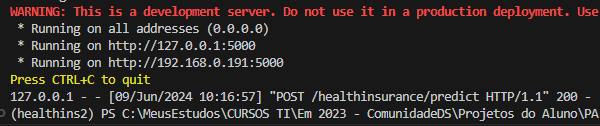

In [187]:
Image('../img/RunningHealthInsuranceHandler.png')

In [188]:
# API call
url = 'https://health-insurance-priv.onrender.com/healthinsurance/predict'
#url = 'http://127.0.0.1:5000/healthinsurance/predict'

# Kind of data to be sent
header = {'Content-type': 'application/json'}

r = requests.post( url, data=data, headers=header )
print( 'Status code {}'.format( r.status_code ) )

Status code 200


In [189]:
# Convert response from Json to DataFrame
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head().T

,0
id,393529
gender,Female
age,40
driving_license,1
region_code,35.0
previously_insured,0
vehicle_age,between_1_2_years
vehicle_damage,1
annual_premium,40484.0
policy_sales_channel,26.0


## 11.4. API Handler

In [190]:
xxx   # rustic breakpoint

NameError: name 'xxx' is not defined

In [ ]:
# OBS: como testar no VS-Code??
# R: ver DS em Produção, módulo 10, video 47
# R: ver "propensão de compra", vídeo 9

import os
import pickle
import pandas as pd
from flask             import Flask, request, Response

# from "pasta.NomeDoArquivo" import "NomeDaClasse"
from healthinsurance.HealthInsurance  import HealthInsurance

#............... Load model
# before the loop, to make it faster...
model = pickle.load( open( 'models/final_model.pkl', 'rb' ) )
#model = pickle.load( open( 'C:/MeusEstudos/CURSOS TI/Em 2023 - ComunidadeDS/Projetos do Aluno/PA.04 health_insurance_priv/webapp/models/model_linear_regression.pkl', 'rb' ) )

#............... Init API
# REF: https://flask.palletsprojects.com/en/2.3.x/genindex/

app = Flask( __name__ )

#............... Create Endpoint Route
# REF: https://flask.palletsprojects.com/en/2.3.x/api/#flask.Blueprint.route
# predict function: that's the handler, activated when the API receives a request

@app.route( '/healthinsurance/predict', methods=['POST'] )
def health_insurance_predict():
    test_json = request.get_json()

    if test_json: # is there any data in the received request?
        if isinstance( test_json, dict ): # unique dt
            # Convert 1-line Json to DataFrame
            test_raw = pd.DataFrame( test_json, index=[0] )

        else: # multiple dt
            # Convert N-lines Json to DataFrame
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instantiate HealthInsurance class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        # prediction
        json_response = pipeline.get_prediction( model, test_raw, df3 )

        return json_response

    else:
        return Response( 'OK, but no data... {}', status=200, mimetype='application/json' )


#............... Run Flask API
if __name__ == '__main__':
    port = os.environ.get( 'PORT', 5000 )
    app.run( '0.0.0.0', port=port )
